In [1]:
#Install packages
%pip install wandb -qU
%pip install --no-deps scikeras
%pip install tensorflow-addons

     |████████████████████████████████| 1.9 MB 4.7 MB/s 
     |████████████████████████████████| 182 kB 50.2 MB/s 
     |████████████████████████████████| 173 kB 48.3 MB/s 
     |████████████████████████████████| 62 kB 567 kB/s 
     |████████████████████████████████| 168 kB 51.7 MB/s 
     |████████████████████████████████| 168 kB 45.4 MB/s 
     |████████████████████████████████| 166 kB 53.5 MB/s 
     |████████████████████████████████| 166 kB 27.8 MB/s 
     |████████████████████████████████| 162 kB 47.8 MB/s 
     |████████████████████████████████| 162 kB 16.9 MB/s 
     |████████████████████████████████| 158 kB 52.0 MB/s 
     |████████████████████████████████| 157 kB 61.6 MB/s 
     |████████████████████████████████| 157 kB 7.7 MB/s 
     |████████████████████████████████| 157 kB 12.2 MB/s 
     |████████████████████████████████| 157 kB 52.7 MB/s 
     |████████████████████████████████| 157 kB 44.4 MB/s 
     |████████████████████████████████| 157 kB 45.7 MB/s 
     |████████████

In [2]:
#imports
import wandb
from wandb.keras import WandbCallback
import numpy as np
import pandas as pd
from re import X
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
import sklearn
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
from sklearn.metrics import roc_auc_score
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dropout

In [3]:
#connect drive containing dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Obtain Dataset

In [4]:
#Use pandas read_csv() function to import data
df = pd.read_csv('/content/drive/MyDrive/CSC461/Final Data /SouthKingstown.csv')
df.head()

,CITY,ZIP CODE,CURRENT PARTY,YEAR OF BIRTH,ELECTION 3,ELECTION 4,ELECTION 5,ELECTION 6,ELECTION 7,ELECTION 8,PARTY 5,PARTY 6,PARTY 8,TGT STATEWIDE PRIMARY,TGT PARTY AFFILIATION
0,31,2879,2,1941,1,1,1,1,1,1,2,2,2,1,2
1,31,2879,2,1940,1,1,1,1,1,1,2,2,2,1,2
2,31,2879,3,1990,0,1,0,0,0,0,0,0,0,0,0
3,31,2879,3,1981,0,1,0,0,1,0,0,0,0,0,0
4,31,2879,2,1984,0,1,0,0,0,0,0,0,0,0,0


In [5]:
#Set datatype to int8 to conserve memory 
df = df.astype("int8")

Define features and label

In [6]:
#Drop unnecessary features
df = df.drop(["CITY",'ZIP CODE'], axis=1)
print(df.shape)

#Dropping rows that involve 0 (non-voters)
df = df.loc[df["TGT PARTY AFFILIATION"] != 0]
#Dropping the one row where someone voted as unafiliated (1) along with moderate party voters (4) because these act as outliers. 
#Since we are trying to predict where swing voters will vote for, only two output units are needed (democrat and republican)
df = df.loc[df["TGT PARTY AFFILIATION"] != 1]
df = df.loc[df["TGT PARTY AFFILIATION"] != 4]
print(df.shape)
print(df.head)


(23271, 13)
(4793, 13)
<bound method NDFrame.head of        CURRENT PARTY  YEAR OF BIRTH  ELECTION 3  ELECTION 4  ELECTION 5  \
0                  2           -107           1           1           1   
1                  2           -108           1           1           1   
21                 2           -104           1           1           1   
26                 2            -94           0           1           0   
28                 2           -101           1           1           0   
...              ...            ...         ...         ...         ...   
23261              2           -110           0           1           1   
23265              3            -85           0           1           0   
23266              3            -83           0           1           0   
23267              2            -95           1           1           1   
23268              2            -89           1           1           1   

       ELECTION 6  ELECTION 7  ELECTION 8  PAR

In [7]:
#Setting our prediction target and dropping target columns from the main dataset
predict = 'TGT PARTY AFFILIATION'
drops = ['TGT STATEWIDE PRIMARY','TGT PARTY AFFILIATION']
X = df.drop(drops, axis=1)
y = df[predict]
print(X.head())
print(y.head())

    CURRENT PARTY  YEAR OF BIRTH  ELECTION 3  ELECTION 4  ELECTION 5  \
0               2           -107           1           1           1   
1               2           -108           1           1           1   
21              2           -104           1           1           1   
26              2            -94           0           1           0   
28              2           -101           1           1           0   

    ELECTION 6  ELECTION 7  ELECTION 8  PARTY 5  PARTY 6  PARTY 8  
0            1           1           1        2        2        2  
1            1           1           1        2        2        2  
21           1           1           1        2        2        2  
26           1           1           0        0        2        0  
28           1           1           0        0        2        0  
0     2
1     2
21    2
26    2
28    2
Name: TGT PARTY AFFILIATION, dtype: int8


In [8]:
#transforming data values to 1,0 so that we can perform binary cross entropy
# 0 = Democrat
y = y.replace(2,0)
# 1 = Republican
y = y.replace(3,1)

In [9]:
#Sanity check
df[predict].unique()

array([2, 3], dtype=int8)

In [10]:
#Show the data-split (unbalanced dataset)
print(y.shape)
np.count_nonzero(y)

(4793,)


564

In [11]:
#creates labels for classes 
le = LabelEncoder()
le.fit_transform(y)

array([0, 0, 0, ..., 1, 0, 0])

In [12]:
#train_test_split the dataset
X_train, X_test, y_train, y_test =  sklearn.model_selection.train_test_split(X, y, test_size=0.3, shuffle=True)

print(f'Train y: {y_train.shape}')
print(f'Train X: {X_train.shape}')
print(f'Test y: {y_test.shape}')
print(f'Test X: {X_test.shape}')

Train y: (3355,)
Train X: (3355, 11)
Test y: (1438,)
Test X: (1438, 11)


In [13]:
#Perform undersampling in an attempt to fix the unbalanced dataset
##################################################################################
undersample = RandomUnderSampler(sampling_strategy='majority')

X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

print(f'Train y: {y_train_under.shape}')
print(f'Train X: {X_train_under.shape}')
###################################################################################
undersample = RandomUnderSampler(sampling_strategy='majority')

X_test_under, y_test_under = undersample.fit_resample(X_test, y_test)

print(f'Test y: {y_test_under.shape}')
print(f'Test X: {X_test_under.shape}')

Train y: (804,)
Train X: (804, 11)
Test y: (324,)
Test X: (324, 11)


--------------------
**W&B SWEEP START**

In [14]:
# W&B sweep configuration
sweep_configuration = {
    'method': 'random',
    'name': 'sweep',
    'metric': {
        'goal': 'maximize', 
        'name': 'val_auc'
		},
    'parameters': {
        'batch_size': {'values': [16,32,64,128]},
        'epochs': {'values': [50,100,150,200]},
        'fc_layer_size': {'values': [7,9,11,13,15]},
        'sc_layer_size': {'values': [7,9,11,13,15]},
        'lr': {'max': 0.1, 'min': 0.0001},
        'optimizer':{'values': ['adam','SGD','RMSprop','nadam','Adadelta','Adagrad','Adamax','Ftrl']},
        'dropout': {'values': [0, 0.3, 0.5]},
     },

}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="ann-party-sk", entity="gotv-ml")

from tensorflow.keras.optimizers import SGD
def get_optimizer(lr=1e-3, optimizer="adam"):
    "Select optmizer between adam and sgd with momentum"
    if optimizer.lower() == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    if optimizer.lower() == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.1)
    if optimizer.lower() == "rmsprop":
        return tf.keras.optimizers.RMSprop(learning_rate=lr)
    if optimizer.lower() == "nadam":
        return tf.keras.optimizers.Nadam(learning_rate=lr)
    if optimizer.lower() == "adadelta":
        return tf.keras.optimizers.Adadelta(learning_rate=lr)
    if optimizer.lower() == "adagrad":
        return tf.keras.optimizers.Adagrad(learning_rate=lr)
    if optimizer.lower() == "adamax":
        return tf.keras.optimizers.Adamax(learning_rate=lr)
    if optimizer.lower() == "ftrl":
        return tf.keras.optimizers.Ftrl(learning_rate=lr)

KeyboardInterrupt: ignored

Define Keras Model

In [ ]:
def Neural_Net(fc_layer_size=11,sc_layer_size=7,dropout=0):

  # initiate Network
  network = Sequential()

  # input layer that is fully connected with ReLU activation 
  network.add(Dense(11, input_dim=11, activation="relu",use_bias=True,bias_initializer="random_normal", kernel_initializer="he_normal"))
  network.add(Dropout(dropout))
  #hiddent layers 
  network.add(Dense(fc_layer_size, activation="relu", use_bias=True, bias_initializer="random_normal", kernel_initializer="he_normal"))
  network.add(Dropout(dropout))
  network.add(Dense(sc_layer_size, activation="relu", use_bias=True, bias_initializer="random_normal", kernel_initializer="he_normal"))

  #Output layer that is fully connected with softmax activation
  network.add(Dense(1, activation="sigmoid"))

  #return completed network
  return network 


In [ ]:
def train(model, batch_size=64, epochs=10, lr=1e-3, optimizer='adam', log_freq=10):  
    
    # Compile model like you usually do.
    tf.keras.backend.clear_session()
    model.compile(optimizer=get_optimizer(lr, optimizer) ,
               loss="binary_crossentropy",
               metrics=["accuracy",
               tfa.metrics.F1Score(num_classes=2,
                                  average='micro',
                                  threshold=0.5),
               tf.keras.metrics.AUC(from_logits=True)
                        ]) 

    model.fit(X_train_under, 
              y_train_under, 
              batch_size=batch_size, 
              epochs=epochs, 
              validation_data=(X_test, y_test), 
              callbacks=[WandbCallback()])
    
def sweep_train(config_defaults=None):
    # Initialize wandb with a sample project name
    with wandb.init(config=config_defaults):  # this gets over-written in the Sweep

        # Specify the other hyperparameters to the configuration, if any
        wandb.config.architecture_name = "NN_Binary"
        wandb.config.dataset_name = "Southkingstown_csv"

        # initialize model
        model = Neural_Net(wandb.config.fc_layer_size,wandb.config.sc_layer_size,wandb.config.dropout)

        train(model, 
              wandb.config.batch_size, 
              wandb.config.epochs,
              wandb.config.lr,
              wandb.config.optimizer)

import pprint
pprint.pprint(sweep_configuration)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'val_auc'},
 'name': 'sweep',
 'parameters': {'batch_size': {'values': [16, 32, 64, 128]},
                'dropout': {'values': [0, 0.3, 0.5]},
                'epochs': {'values': [50, 100, 150, 200]},
                'fc_layer_size': {'values': [7, 9, 11, 13, 15]},
                'lr': {'max': 0.1, 'min': 0.0001},
                'optimizer': {'values': ['adam',
                                         'SGD',
                                         'RMSprop',
                                         'nadam',
                                         'Adadelta',
                                         'Adagrad',
                                         'Adamax',
                                         'Ftrl']},
                'sc_layer_size': {'values': [7, 9, 11, 13, 15]}}}


In [ ]:
#Call the sweep agent to train the model under randomized parameters
wandb.agent(sweep_id, function=sweep_train, count=10)

wandb: Agent Starting Run: rvpng5hq with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	epochs: 100
wandb: 	fc_layer_size: 9
wandb: 	lr: 0.0576131923524072
wandb: 	optimizer: Adagrad
wandb: 	sc_layer_size: 13


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
51/51 [==============================] - ETA: 0s - loss: 1.5373 - accuracy: 0.4677 - f1_score: 0.5046 - auc: 0.4656

wandb: Adding directory to artifact (/content/wandb/run-20221218_031134-rvpng5hq/files/model-best)... Done. 0.0s


51/51 [==============================] - 5s 37ms/step - loss: 1.5373 - accuracy: 0.4677 - f1_score: 0.5046 - auc: 0.4656 - val_loss: 0.6717 - val_accuracy: 0.8720 - val_f1_score: 0.1636 - val_auc: 0.5466
Epoch 2/100
51/51 [==============================] - 0s 9ms/step - loss: 0.7506 - accuracy: 0.5025 - f1_score: 0.5360 - auc: 0.5042 - val_loss: 0.6798 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.4830
Epoch 3/100
50/51 [============================>.] - ETA: 0s - loss: 0.7344 - accuracy: 0.4875 - f1_score: 0.5131 - auc: 0.4903

wandb: Adding directory to artifact (/content/wandb/run-20221218_031134-rvpng5hq/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 0.7345 - accuracy: 0.4876 - f1_score: 0.5130 - auc: 0.4896 - val_loss: 0.6310 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.5773
Epoch 4/100
51/51 [==============================] - 0s 9ms/step - loss: 0.7132 - accuracy: 0.4938 - f1_score: 0.5483 - auc: 0.4837 - val_loss: 0.6859 - val_accuracy: 0.8199 - val_f1_score: 0.3342 - val_auc: 0.6052
Epoch 5/100
51/51 [==============================] - 1s 10ms/step - loss: 0.7159 - accuracy: 0.4789 - f1_score: 0.4480 - auc: 0.4758 - val_loss: 0.6522 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.5564
Epoch 6/100
51/51 [==============================] - 0s 9ms/step - loss: 0.7029 - accuracy: 0.4900 - f1_score: 0.4661 - auc: 0.4939 - val_loss: 0.6810 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.5000
Epoch 7/100
51/51 [==============================] - 0s 9ms/step - loss: 0.7091 - accuracy: 0.4614 - f1_score: 0.4726 - auc: 0.4560 - val_

wandb: Adding directory to artifact (/content/wandb/run-20221218_031134-rvpng5hq/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 28ms/step - loss: 0.6784 - accuracy: 0.5473 - f1_score: 0.4583 - auc: 0.5586 - val_loss: 0.6309 - val_accuracy: 0.8915 - val_f1_score: 0.0714 - val_auc: 0.7049
Epoch 69/100
51/51 [==============================] - 1s 10ms/step - loss: 0.6703 - accuracy: 0.5871 - f1_score: 0.4829 - auc: 0.6118 - val_loss: 0.6348 - val_accuracy: 0.8887 - val_f1_score: 0.0244 - val_auc: 0.6638
Epoch 70/100
51/51 [==============================] - 1s 10ms/step - loss: 0.6749 - accuracy: 0.5697 - f1_score: 0.4709 - auc: 0.5985 - val_loss: 0.6341 - val_accuracy: 0.8964 - val_f1_score: 0.1486 - val_auc: 0.5927
Epoch 71/100
51/51 [==============================] - 1s 11ms/step - loss: 0.6693 - accuracy: 0.5746 - f1_score: 0.4755 - auc: 0.5975 - val_loss: 0.6524 - val_accuracy: 0.8588 - val_f1_score: 0.3904 - val_auc: 0.8098
Epoch 72/100
49/51 [===========================>..] - ETA: 0s - loss: 0.6686 - accuracy: 0.5995 - f1_score: 0.5063 - auc: 0.6058

wandb: Adding directory to artifact (/content/wandb/run-20221218_031134-rvpng5hq/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 34ms/step - loss: 0.6678 - accuracy: 0.5995 - f1_score: 0.5076 - auc: 0.6057 - val_loss: 0.6303 - val_accuracy: 0.9166 - val_f1_score: 0.4118 - val_auc: 0.7299
Epoch 73/100
42/51 [=======================>......] - ETA: 0s - loss: 0.6715 - accuracy: 0.5655 - f1_score: 0.4613 - auc: 0.6021

wandb: Adding directory to artifact (/content/wandb/run-20221218_031134-rvpng5hq/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 0.6733 - accuracy: 0.5659 - f1_score: 0.4487 - auc: 0.5906 - val_loss: 0.6301 - val_accuracy: 0.9006 - val_f1_score: 0.2099 - val_auc: 0.6741
Epoch 74/100
50/51 [============================>.] - ETA: 0s - loss: 0.6664 - accuracy: 0.6000 - f1_score: 0.5000 - auc: 0.6292

wandb: Adding directory to artifact (/content/wandb/run-20221218_031134-rvpng5hq/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 0.6661 - accuracy: 0.5995 - f1_score: 0.5000 - auc: 0.6299 - val_loss: 0.6287 - val_accuracy: 0.8922 - val_f1_score: 0.3969 - val_auc: 0.7951
Epoch 75/100
51/51 [==============================] - 1s 10ms/step - loss: 0.6728 - accuracy: 0.5883 - f1_score: 0.4771 - auc: 0.5948 - val_loss: 0.6310 - val_accuracy: 0.9006 - val_f1_score: 0.2099 - val_auc: 0.6719
Epoch 76/100
51/51 [==============================] - 1s 11ms/step - loss: 0.6554 - accuracy: 0.6219 - f1_score: 0.5294 - auc: 0.6454 - val_loss: 0.6364 - val_accuracy: 0.8853 - val_f1_score: 0.5576 - val_auc: 0.8012
Epoch 77/100
50/51 [============================>.] - ETA: 0s - loss: 0.6549 - accuracy: 0.6112 - f1_score: 0.5193 - auc: 0.6248

wandb: Adding directory to artifact (/content/wandb/run-20221218_031134-rvpng5hq/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 0.6552 - accuracy: 0.6107 - f1_score: 0.5192 - auc: 0.6235 - val_loss: 0.6259 - val_accuracy: 0.9026 - val_f1_score: 0.2391 - val_auc: 0.6799
Epoch 78/100
51/51 [==============================] - 1s 11ms/step - loss: 0.6419 - accuracy: 0.6244 - f1_score: 0.5506 - auc: 0.6824 - val_loss: 0.6264 - val_accuracy: 0.8894 - val_f1_score: 0.5521 - val_auc: 0.8035
Epoch 79/100
50/51 [============================>.] - ETA: 0s - loss: 0.6505 - accuracy: 0.6162 - f1_score: 0.5270 - auc: 0.6512

wandb: Adding directory to artifact (/content/wandb/run-20221218_031134-rvpng5hq/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 0.6499 - accuracy: 0.6157 - f1_score: 0.5282 - auc: 0.6526 - val_loss: 0.6149 - val_accuracy: 0.9242 - val_f1_score: 0.5918 - val_auc: 0.7931
Epoch 80/100
51/51 [==============================] - ETA: 0s - loss: 0.6394 - accuracy: 0.6231 - f1_score: 0.5653 - auc: 0.6692

wandb: Adding directory to artifact (/content/wandb/run-20221218_031134-rvpng5hq/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 0.6394 - accuracy: 0.6231 - f1_score: 0.5653 - auc: 0.6692 - val_loss: 0.6105 - val_accuracy: 0.9117 - val_f1_score: 0.6116 - val_auc: 0.8186
Epoch 81/100
41/51 [=======================>......] - ETA: 0s - loss: 0.6316 - accuracy: 0.6463 - f1_score: 0.5639 - auc: 0.6706

wandb: Adding directory to artifact (/content/wandb/run-20221218_031134-rvpng5hq/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 30ms/step - loss: 0.6297 - accuracy: 0.6493 - f1_score: 0.5753 - auc: 0.6767 - val_loss: 0.6052 - val_accuracy: 0.9082 - val_f1_score: 0.6071 - val_auc: 0.8536
Epoch 82/100
51/51 [==============================] - 1s 11ms/step - loss: 0.6163 - accuracy: 0.6791 - f1_score: 0.6206 - auc: 0.7033 - val_loss: 0.6267 - val_accuracy: 0.7337 - val_f1_score: 0.4006 - val_auc: 0.8587
Epoch 83/100
42/51 [=======================>......] - ETA: 0s - loss: 0.6229 - accuracy: 0.6652 - f1_score: 0.5872 - auc: 0.6915

wandb: Adding directory to artifact (/content/wandb/run-20221218_031134-rvpng5hq/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 33ms/step - loss: 0.6250 - accuracy: 0.6580 - f1_score: 0.5852 - auc: 0.6901 - val_loss: 0.5929 - val_accuracy: 0.9228 - val_f1_score: 0.5316 - val_auc: 0.8389
Epoch 84/100
51/51 [==============================] - 1s 11ms/step - loss: 0.6184 - accuracy: 0.6480 - f1_score: 0.5666 - auc: 0.7111 - val_loss: 0.5974 - val_accuracy: 0.9221 - val_f1_score: 0.6725 - val_auc: 0.9007
Epoch 85/100
51/51 [==============================] - 0s 10ms/step - loss: 0.6137 - accuracy: 0.6803 - f1_score: 0.6385 - auc: 0.7242 - val_loss: 0.6203 - val_accuracy: 0.8032 - val_f1_score: 0.4991 - val_auc: 0.9001
Epoch 86/100
51/51 [==============================] - 1s 11ms/step - loss: 0.6030 - accuracy: 0.6803 - f1_score: 0.6281 - auc: 0.7270 - val_loss: 0.6201 - val_accuracy: 0.7524 - val_f1_score: 0.4437 - val_auc: 0.9106
Epoch 87/100
49/51 [===========================>..] - ETA: 0s - loss: 0.6236 - accuracy: 0.6429 - f1_score: 0.5796 - auc: 0.6921

wandb: Adding directory to artifact (/content/wandb/run-20221218_031134-rvpng5hq/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 30ms/step - loss: 0.6226 - accuracy: 0.6480 - f1_score: 0.5869 - auc: 0.6948 - val_loss: 0.5807 - val_accuracy: 0.9471 - val_f1_score: 0.7483 - val_auc: 0.9289
Epoch 88/100
50/51 [============================>.] - ETA: 0s - loss: 0.5917 - accuracy: 0.6938 - f1_score: 0.6525 - auc: 0.7467

wandb: Adding directory to artifact (/content/wandb/run-20221218_031134-rvpng5hq/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 28ms/step - loss: 0.5920 - accuracy: 0.6928 - f1_score: 0.6516 - auc: 0.7462 - val_loss: 0.5800 - val_accuracy: 0.8769 - val_f1_score: 0.6040 - val_auc: 0.9429
Epoch 89/100
48/51 [===========================>..] - ETA: 0s - loss: 0.5817 - accuracy: 0.7109 - f1_score: 0.6783 - auc: 0.7566

wandb: Adding directory to artifact (/content/wandb/run-20221218_031134-rvpng5hq/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 28ms/step - loss: 0.5825 - accuracy: 0.7114 - f1_score: 0.6796 - auc: 0.7554 - val_loss: 0.5661 - val_accuracy: 0.8331 - val_f1_score: 0.5331 - val_auc: 0.9274
Epoch 90/100
51/51 [==============================] - 1s 10ms/step - loss: 0.5749 - accuracy: 0.7027 - f1_score: 0.6501 - auc: 0.7452 - val_loss: 0.6209 - val_accuracy: 0.7253 - val_f1_score: 0.4365 - val_auc: 0.9428
Epoch 91/100
50/51 [============================>.] - ETA: 0s - loss: 0.5796 - accuracy: 0.7200 - f1_score: 0.6836 - auc: 0.7518

wandb: Adding directory to artifact (/content/wandb/run-20221218_031134-rvpng5hq/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 28ms/step - loss: 0.5794 - accuracy: 0.7201 - f1_score: 0.6853 - auc: 0.7519 - val_loss: 0.5594 - val_accuracy: 0.9458 - val_f1_score: 0.7771 - val_auc: 0.9593
Epoch 92/100
50/51 [============================>.] - ETA: 0s - loss: 0.5583 - accuracy: 0.7150 - f1_score: 0.6752 - auc: 0.7708

wandb: Adding directory to artifact (/content/wandb/run-20221218_031134-rvpng5hq/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 0.5576 - accuracy: 0.7164 - f1_score: 0.6771 - auc: 0.7720 - val_loss: 0.5214 - val_accuracy: 0.8790 - val_f1_score: 0.6250 - val_auc: 0.9472
Epoch 93/100
51/51 [==============================] - ETA: 0s - loss: 0.5575 - accuracy: 0.7152 - f1_score: 0.6841 - auc: 0.7720

wandb: Adding directory to artifact (/content/wandb/run-20221218_031134-rvpng5hq/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 0.5575 - accuracy: 0.7152 - f1_score: 0.6841 - auc: 0.7720 - val_loss: 0.4849 - val_accuracy: 0.9444 - val_f1_score: 0.7419 - val_auc: 0.9485
Epoch 94/100
51/51 [==============================] - 0s 9ms/step - loss: 0.5570 - accuracy: 0.7139 - f1_score: 0.6637 - auc: 0.7660 - val_loss: 0.5409 - val_accuracy: 0.8394 - val_f1_score: 0.5714 - val_auc: 0.9674
Epoch 95/100
51/51 [==============================] - 1s 10ms/step - loss: 0.5349 - accuracy: 0.7463 - f1_score: 0.7198 - auc: 0.7857 - val_loss: 0.4866 - val_accuracy: 0.9047 - val_f1_score: 0.6851 - val_auc: 0.9620
Epoch 96/100
51/51 [==============================] - 0s 9ms/step - loss: 0.5195 - accuracy: 0.7600 - f1_score: 0.7331 - auc: 0.8229 - val_loss: 0.5840 - val_accuracy: 0.7309 - val_f1_score: 0.4495 - val_auc: 0.9639
Epoch 97/100
42/51 [=======================>......] - ETA: 0s - loss: 0.5144 - accuracy: 0.7545 - f1_score: 0.7393 - auc: 0.8097

wandb: Adding directory to artifact (/content/wandb/run-20221218_031134-rvpng5hq/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 28ms/step - loss: 0.5129 - accuracy: 0.7612 - f1_score: 0.7384 - auc: 0.8112 - val_loss: 0.4171 - val_accuracy: 0.9353 - val_f1_score: 0.7621 - val_auc: 0.9630
Epoch 98/100
51/51 [==============================] - 0s 10ms/step - loss: 0.5164 - accuracy: 0.7512 - f1_score: 0.7183 - auc: 0.8109 - val_loss: 0.4315 - val_accuracy: 0.9047 - val_f1_score: 0.6921 - val_auc: 0.9680
Epoch 99/100
51/51 [==============================] - 1s 10ms/step - loss: 0.4816 - accuracy: 0.7811 - f1_score: 0.7589 - auc: 0.8339 - val_loss: 0.4390 - val_accuracy: 0.9152 - val_f1_score: 0.7176 - val_auc: 0.9663
Epoch 100/100
42/51 [=======================>......] - ETA: 0s - loss: 0.4735 - accuracy: 0.7917 - f1_score: 0.7659 - auc: 0.8468

wandb: Adding directory to artifact (/content/wandb/run-20221218_031134-rvpng5hq/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 34ms/step - loss: 0.4731 - accuracy: 0.7923 - f1_score: 0.7709 - auc: 0.8452 - val_loss: 0.3838 - val_accuracy: 0.9346 - val_f1_score: 0.7673 - val_auc: 0.9716


accuracy,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▂▃▄▄▄▄▄▆▅▅▆▆▆▇█
auc,▁▁▂▁▂▂▁▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▆▅▆▇▇▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▄▄▃▂▃▃▁▂▂▃▃▁▂▁▃▁▃▂▂▂▂▂▃▂▃▃▄▃▄▄▄▄▆▅▅▆▆▆▇█
loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
val_accuracy,▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▁▇█▄▆▄██
val_auc,▃▃▂▂▂▂▂▃▂▃▂▃▁▁▂▁▃▂▄▂▂▃▂▂▃▂▃▄▅▆▄▆▇▇▇▇████
val_f1_score,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▅▅▃▆▅▇█▆▇▆██
val_loss,█▇██▇▇▇█▇█▇▇████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▆▆▅▄▅▂▁
accuracy,0.79229
auc,0.84523


wandb: Agent Starting Run: uup070bs with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	epochs: 100
wandb: 	fc_layer_size: 7
wandb: 	lr: 0.009622827320128669
wandb: 	optimizer: Adadelta
wandb: 	sc_layer_size: 7


Epoch 1/100
50/51 [============================>.] - ETA: 0s - loss: 38.0965 - accuracy: 0.5013 - f1_score: 0.6610 - auc: 0.4905

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 3s 36ms/step - loss: 37.9298 - accuracy: 0.5012 - f1_score: 0.6610 - auc: 0.4903 - val_loss: 48.7099 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 2/100
39/51 [=====================>........] - ETA: 0s - loss: 34.3690 - accuracy: 0.4952 - f1_score: 0.6587 - auc: 0.4971

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 33.8401 - accuracy: 0.4963 - f1_score: 0.6599 - auc: 0.4887 - val_loss: 48.2688 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 3/100
49/51 [===========================>..] - ETA: 0s - loss: 38.9096 - accuracy: 0.4949 - f1_score: 0.6580 - auc: 0.4901

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 30ms/step - loss: 38.7490 - accuracy: 0.4963 - f1_score: 0.6594 - auc: 0.4894 - val_loss: 47.7925 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 4/100
50/51 [============================>.] - ETA: 0s - loss: 40.8797 - accuracy: 0.4900 - f1_score: 0.6548 - auc: 0.4825

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 40.7149 - accuracy: 0.4913 - f1_score: 0.6560 - auc: 0.4817 - val_loss: 47.2950 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 5/100
49/51 [===========================>..] - ETA: 0s - loss: 34.5243 - accuracy: 0.5051 - f1_score: 0.6649 - auc: 0.5199

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 34.5326 - accuracy: 0.5062 - f1_score: 0.6655 - auc: 0.5220 - val_loss: 46.8610 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 6/100
43/51 [========================>.....] - ETA: 0s - loss: 36.8826 - accuracy: 0.5145 - f1_score: 0.6725 - auc: 0.5058

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 37ms/step - loss: 37.7502 - accuracy: 0.5075 - f1_score: 0.6650 - auc: 0.5004 - val_loss: 46.3791 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 7/100
49/51 [===========================>..] - ETA: 0s - loss: 35.8797 - accuracy: 0.5077 - f1_score: 0.6684 - auc: 0.4859

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 30ms/step - loss: 36.2567 - accuracy: 0.5050 - f1_score: 0.6661 - auc: 0.4867 - val_loss: 45.9267 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 8/100
46/51 [==========================>...] - ETA: 0s - loss: 35.0023 - accuracy: 0.5027 - f1_score: 0.6636 - auc: 0.4945

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 35.2588 - accuracy: 0.4988 - f1_score: 0.6599 - auc: 0.4974 - val_loss: 45.4877 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 9/100
49/51 [===========================>..] - ETA: 0s - loss: 34.1319 - accuracy: 0.4987 - f1_score: 0.6632 - auc: 0.5088

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 34.3349 - accuracy: 0.4975 - f1_score: 0.6622 - auc: 0.5054 - val_loss: 45.0899 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 10/100
50/51 [============================>.] - ETA: 0s - loss: 34.8492 - accuracy: 0.5013 - f1_score: 0.6593 - auc: 0.4995

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 34.7661 - accuracy: 0.5025 - f1_score: 0.6604 - auc: 0.4999 - val_loss: 44.6811 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 11/100
51/51 [==============================] - ETA: 0s - loss: 34.4884 - accuracy: 0.5062 - f1_score: 0.6655 - auc: 0.5060

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 30ms/step - loss: 34.4884 - accuracy: 0.5062 - f1_score: 0.6655 - auc: 0.5060 - val_loss: 44.2769 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 12/100
48/51 [===========================>..] - ETA: 0s - loss: 37.0859 - accuracy: 0.5000 - f1_score: 0.6584 - auc: 0.5096

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 37.0002 - accuracy: 0.5050 - f1_score: 0.6627 - auc: 0.5105 - val_loss: 43.8586 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 13/100
49/51 [===========================>..] - ETA: 0s - loss: 36.2810 - accuracy: 0.4911 - f1_score: 0.6533 - auc: 0.4890

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 35ms/step - loss: 36.0709 - accuracy: 0.4938 - f1_score: 0.6560 - auc: 0.4925 - val_loss: 43.4210 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 14/100
38/51 [=====================>........] - ETA: 0s - loss: 32.9745 - accuracy: 0.5099 - f1_score: 0.6659 - auc: 0.5136

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 32.4423 - accuracy: 0.5050 - f1_score: 0.6639 - auc: 0.5121 - val_loss: 43.0510 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 15/100
47/51 [==========================>...] - ETA: 0s - loss: 34.2396 - accuracy: 0.5053 - f1_score: 0.6600 - auc: 0.5047

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 34.4817 - accuracy: 0.5075 - f1_score: 0.6610 - auc: 0.5058 - val_loss: 42.6444 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 16/100
48/51 [===========================>..] - ETA: 0s - loss: 33.6571 - accuracy: 0.4909 - f1_score: 0.6537 - auc: 0.4767

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 33.8705 - accuracy: 0.4925 - f1_score: 0.6554 - auc: 0.4735 - val_loss: 42.2460 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 17/100
39/51 [=====================>........] - ETA: 0s - loss: 32.7731 - accuracy: 0.5192 - f1_score: 0.6696 - auc: 0.5328

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 32.4880 - accuracy: 0.5124 - f1_score: 0.6655 - auc: 0.5230 - val_loss: 41.8716 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 18/100
48/51 [===========================>..] - ETA: 0s - loss: 30.6824 - accuracy: 0.5156 - f1_score: 0.6655 - auc: 0.5039

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 31.2076 - accuracy: 0.5100 - f1_score: 0.6609 - auc: 0.5029 - val_loss: 41.5060 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 19/100
47/51 [==========================>...] - ETA: 0s - loss: 31.2118 - accuracy: 0.4840 - f1_score: 0.6440 - auc: 0.4752

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 31.2275 - accuracy: 0.4913 - f1_score: 0.6507 - auc: 0.4803 - val_loss: 41.1476 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 20/100
47/51 [==========================>...] - ETA: 0s - loss: 31.3281 - accuracy: 0.4894 - f1_score: 0.6471 - auc: 0.4974

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 30ms/step - loss: 31.7111 - accuracy: 0.4900 - f1_score: 0.6484 - auc: 0.4922 - val_loss: 40.7772 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 21/100
51/51 [==============================] - ETA: 0s - loss: 33.1049 - accuracy: 0.4888 - f1_score: 0.6478 - auc: 0.4869

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 36ms/step - loss: 33.1049 - accuracy: 0.4888 - f1_score: 0.6478 - auc: 0.4869 - val_loss: 40.3769 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 22/100
41/51 [=======================>......] - ETA: 0s - loss: 30.4768 - accuracy: 0.5061 - f1_score: 0.6625 - auc: 0.5219

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 30.7441 - accuracy: 0.5050 - f1_score: 0.6610 - auc: 0.5197 - val_loss: 40.0042 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 23/100
50/51 [============================>.] - ETA: 0s - loss: 30.8051 - accuracy: 0.4913 - f1_score: 0.6512 - auc: 0.5050

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 30.6661 - accuracy: 0.4925 - f1_score: 0.6519 - auc: 0.5063 - val_loss: 39.6303 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 24/100
50/51 [============================>.] - ETA: 0s - loss: 29.8374 - accuracy: 0.4938 - f1_score: 0.6506 - auc: 0.4938

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 30ms/step - loss: 29.6898 - accuracy: 0.4950 - f1_score: 0.6518 - auc: 0.4944 - val_loss: 39.2620 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 25/100
51/51 [==============================] - ETA: 0s - loss: 32.1641 - accuracy: 0.4963 - f1_score: 0.6524 - auc: 0.5009

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 30ms/step - loss: 32.1641 - accuracy: 0.4963 - f1_score: 0.6524 - auc: 0.5009 - val_loss: 38.8603 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 26/100
47/51 [==========================>...] - ETA: 0s - loss: 31.7602 - accuracy: 0.5066 - f1_score: 0.6630 - auc: 0.5076

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 31.5083 - accuracy: 0.5025 - f1_score: 0.6593 - auc: 0.5072 - val_loss: 38.4562 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 27/100
49/51 [===========================>..] - ETA: 0s - loss: 30.9214 - accuracy: 0.4974 - f1_score: 0.6418 - auc: 0.4853

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 31.1980 - accuracy: 0.4975 - f1_score: 0.6418 - auc: 0.4877 - val_loss: 38.0698 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 28/100
51/51 [==============================] - ETA: 0s - loss: 30.6247 - accuracy: 0.4938 - f1_score: 0.6427 - auc: 0.5002

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 36ms/step - loss: 30.6247 - accuracy: 0.4938 - f1_score: 0.6427 - auc: 0.5002 - val_loss: 37.6845 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 29/100
50/51 [============================>.] - ETA: 0s - loss: 31.3464 - accuracy: 0.4975 - f1_score: 0.6449 - auc: 0.4899

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 31.2555 - accuracy: 0.4975 - f1_score: 0.6450 - auc: 0.4879 - val_loss: 37.3055 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 30/100
48/51 [===========================>..] - ETA: 0s - loss: 31.2151 - accuracy: 0.5052 - f1_score: 0.6507 - auc: 0.4933

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 30.7791 - accuracy: 0.5037 - f1_score: 0.6478 - auc: 0.4998 - val_loss: 36.9424 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 31/100
49/51 [===========================>..] - ETA: 0s - loss: 29.1186 - accuracy: 0.5051 - f1_score: 0.6473 - auc: 0.4931

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 28.9850 - accuracy: 0.5050 - f1_score: 0.6472 - auc: 0.4925 - val_loss: 36.5800 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 32/100
41/51 [=======================>......] - ETA: 0s - loss: 28.1200 - accuracy: 0.4970 - f1_score: 0.6429 - auc: 0.4999

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 29.0817 - accuracy: 0.4888 - f1_score: 0.6340 - auc: 0.5021 - val_loss: 36.2218 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 33/100
50/51 [============================>.] - ETA: 0s - loss: 28.0775 - accuracy: 0.5150 - f1_score: 0.6536 - auc: 0.5217

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 28.0959 - accuracy: 0.5149 - f1_score: 0.6536 - auc: 0.5216 - val_loss: 35.8759 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 34/100
40/51 [======================>.......] - ETA: 0s - loss: 29.1653 - accuracy: 0.5094 - f1_score: 0.6542 - auc: 0.5132

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 30.7766 - accuracy: 0.4913 - f1_score: 0.6403 - auc: 0.4902 - val_loss: 35.4909 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 35/100
49/51 [===========================>..] - ETA: 0s - loss: 29.3200 - accuracy: 0.4872 - f1_score: 0.6339 - auc: 0.4905

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 35ms/step - loss: 29.6085 - accuracy: 0.4863 - f1_score: 0.6335 - auc: 0.4881 - val_loss: 35.1286 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 36/100
49/51 [===========================>..] - ETA: 0s - loss: 29.7977 - accuracy: 0.5051 - f1_score: 0.6517 - auc: 0.4848

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 30.0321 - accuracy: 0.5025 - f1_score: 0.6497 - auc: 0.4829 - val_loss: 34.7797 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 37/100
45/51 [=========================>....] - ETA: 0s - loss: 29.6393 - accuracy: 0.5111 - f1_score: 0.6508 - auc: 0.5049

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 30.2199 - accuracy: 0.5012 - f1_score: 0.6436 - auc: 0.5034 - val_loss: 34.4210 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 38/100
49/51 [===========================>..] - ETA: 0s - loss: 28.0402 - accuracy: 0.4847 - f1_score: 0.6300 - auc: 0.4799

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 27.9821 - accuracy: 0.4863 - f1_score: 0.6309 - auc: 0.4807 - val_loss: 34.0830 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 39/100
49/51 [===========================>..] - ETA: 0s - loss: 27.7301 - accuracy: 0.5013 - f1_score: 0.6449 - auc: 0.5119

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 27.5370 - accuracy: 0.5000 - f1_score: 0.6430 - auc: 0.5120 - val_loss: 33.7448 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 40/100
50/51 [============================>.] - ETA: 0s - loss: 27.9338 - accuracy: 0.5063 - f1_score: 0.6508 - auc: 0.5038

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 27.9139 - accuracy: 0.5037 - f1_score: 0.6485 - auc: 0.5030 - val_loss: 33.4105 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 41/100
50/51 [============================>.] - ETA: 0s - loss: 27.9696 - accuracy: 0.5150 - f1_score: 0.6498 - auc: 0.5133

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 27.9811 - accuracy: 0.5149 - f1_score: 0.6499 - auc: 0.5132 - val_loss: 33.0645 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 42/100
50/51 [============================>.] - ETA: 0s - loss: 28.0472 - accuracy: 0.5038 - f1_score: 0.6490 - auc: 0.5013

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 34ms/step - loss: 27.9917 - accuracy: 0.5037 - f1_score: 0.6491 - auc: 0.5013 - val_loss: 32.7182 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 43/100
38/51 [=====================>........] - ETA: 0s - loss: 25.2538 - accuracy: 0.5115 - f1_score: 0.6566 - auc: 0.4943

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 26.2072 - accuracy: 0.4975 - f1_score: 0.6431 - auc: 0.4982 - val_loss: 32.3897 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 44/100
40/51 [======================>.......] - ETA: 0s - loss: 25.7711 - accuracy: 0.4969 - f1_score: 0.6422 - auc: 0.4987

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 25.3073 - accuracy: 0.4950 - f1_score: 0.6394 - auc: 0.5045 - val_loss: 32.0653 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 45/100
48/51 [===========================>..] - ETA: 0s - loss: 26.7421 - accuracy: 0.4909 - f1_score: 0.6363 - auc: 0.4861

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 27.1611 - accuracy: 0.4913 - f1_score: 0.6371 - auc: 0.4837 - val_loss: 31.7379 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 46/100
48/51 [===========================>..] - ETA: 0s - loss: 26.4615 - accuracy: 0.4857 - f1_score: 0.6346 - auc: 0.4906

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 26.7099 - accuracy: 0.4851 - f1_score: 0.6343 - auc: 0.4929 - val_loss: 31.4130 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 47/100
47/51 [==========================>...] - ETA: 0s - loss: 24.0397 - accuracy: 0.5040 - f1_score: 0.6471 - auc: 0.5095

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 24.0247 - accuracy: 0.5012 - f1_score: 0.6454 - auc: 0.5086 - val_loss: 31.1030 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 48/100
49/51 [===========================>..] - ETA: 0s - loss: 27.1915 - accuracy: 0.5179 - f1_score: 0.6545 - auc: 0.5265

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 27.0540 - accuracy: 0.5174 - f1_score: 0.6548 - auc: 0.5228 - val_loss: 30.7550 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 49/100
48/51 [===========================>..] - ETA: 0s - loss: 24.7652 - accuracy: 0.5039 - f1_score: 0.6416 - auc: 0.4961

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 24.8013 - accuracy: 0.5012 - f1_score: 0.6391 - auc: 0.4970 - val_loss: 30.4226 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 50/100
51/51 [==============================] - ETA: 0s - loss: 25.5321 - accuracy: 0.4900 - f1_score: 0.6372 - auc: 0.4922

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 35ms/step - loss: 25.5321 - accuracy: 0.4900 - f1_score: 0.6372 - auc: 0.4922 - val_loss: 30.1096 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 51/100
45/51 [=========================>....] - ETA: 0s - loss: 26.3084 - accuracy: 0.5042 - f1_score: 0.6483 - auc: 0.5022

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 27.4208 - accuracy: 0.4900 - f1_score: 0.6352 - auc: 0.4951 - val_loss: 29.7526 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 52/100
47/51 [==========================>...] - ETA: 0s - loss: 25.2736 - accuracy: 0.5000 - f1_score: 0.6453 - auc: 0.4858

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 25.0475 - accuracy: 0.5012 - f1_score: 0.6442 - auc: 0.4878 - val_loss: 29.4357 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 53/100
50/51 [============================>.] - ETA: 0s - loss: 25.0005 - accuracy: 0.5038 - f1_score: 0.6446 - auc: 0.5044

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 30ms/step - loss: 25.0205 - accuracy: 0.5025 - f1_score: 0.6435 - auc: 0.5031 - val_loss: 29.1058 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 54/100
51/51 [==============================] - ETA: 0s - loss: 23.1492 - accuracy: 0.5100 - f1_score: 0.6438 - auc: 0.5122

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 23.1492 - accuracy: 0.5100 - f1_score: 0.6438 - auc: 0.5122 - val_loss: 28.7983 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 55/100
46/51 [==========================>...] - ETA: 0s - loss: 24.5937 - accuracy: 0.4959 - f1_score: 0.6366 - auc: 0.5062

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 24.1516 - accuracy: 0.5000 - f1_score: 0.6423 - auc: 0.5106 - val_loss: 28.4790 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 56/100
48/51 [===========================>..] - ETA: 0s - loss: 24.7208 - accuracy: 0.5013 - f1_score: 0.6410 - auc: 0.5130

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 24.3979 - accuracy: 0.5050 - f1_score: 0.6459 - auc: 0.5133 - val_loss: 28.1518 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 57/100
48/51 [===========================>..] - ETA: 0s - loss: 23.1157 - accuracy: 0.5208 - f1_score: 0.6618 - auc: 0.5198

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 37ms/step - loss: 23.7114 - accuracy: 0.5112 - f1_score: 0.6531 - auc: 0.5194 - val_loss: 27.8269 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 58/100
48/51 [===========================>..] - ETA: 0s - loss: 24.2498 - accuracy: 0.4909 - f1_score: 0.6342 - auc: 0.4799

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 23.8064 - accuracy: 0.4950 - f1_score: 0.6375 - auc: 0.4905 - val_loss: 27.5195 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 59/100
50/51 [============================>.] - ETA: 0s - loss: 24.4027 - accuracy: 0.4975 - f1_score: 0.6442 - auc: 0.5184

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 24.5925 - accuracy: 0.4975 - f1_score: 0.6444 - auc: 0.5171 - val_loss: 27.1778 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 60/100
51/51 [==============================] - ETA: 0s - loss: 23.6025 - accuracy: 0.5149 - f1_score: 0.6543 - auc: 0.5351

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 30ms/step - loss: 23.6025 - accuracy: 0.5149 - f1_score: 0.6543 - auc: 0.5351 - val_loss: 26.8851 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 61/100
47/51 [==========================>...] - ETA: 0s - loss: 21.8025 - accuracy: 0.5080 - f1_score: 0.6442 - auc: 0.5151

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 22.2472 - accuracy: 0.5075 - f1_score: 0.6452 - auc: 0.5143 - val_loss: 26.5929 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 62/100
50/51 [============================>.] - ETA: 0s - loss: 23.5965 - accuracy: 0.5100 - f1_score: 0.6487 - auc: 0.5045

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 30ms/step - loss: 23.5183 - accuracy: 0.5112 - f1_score: 0.6500 - auc: 0.5049 - val_loss: 26.2764 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 63/100
51/51 [==============================] - ETA: 0s - loss: 22.3534 - accuracy: 0.5124 - f1_score: 0.6531 - auc: 0.5220

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 22.3534 - accuracy: 0.5124 - f1_score: 0.6531 - auc: 0.5220 - val_loss: 25.9747 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 64/100
51/51 [==============================] - ETA: 0s - loss: 23.4758 - accuracy: 0.4975 - f1_score: 0.6393 - auc: 0.4862

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 36ms/step - loss: 23.4758 - accuracy: 0.4975 - f1_score: 0.6393 - auc: 0.4862 - val_loss: 25.6540 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 65/100
48/51 [===========================>..] - ETA: 0s - loss: 20.7273 - accuracy: 0.5286 - f1_score: 0.6623 - auc: 0.5378

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 21.3979 - accuracy: 0.5187 - f1_score: 0.6523 - auc: 0.5361 - val_loss: 25.3544 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 66/100
48/51 [===========================>..] - ETA: 0s - loss: 21.8185 - accuracy: 0.5052 - f1_score: 0.6475 - auc: 0.5174

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 22.1057 - accuracy: 0.5062 - f1_score: 0.6484 - auc: 0.5177 - val_loss: 25.0469 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 67/100
49/51 [===========================>..] - ETA: 0s - loss: 23.2696 - accuracy: 0.4974 - f1_score: 0.6412 - auc: 0.4928

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 22.9337 - accuracy: 0.5012 - f1_score: 0.6442 - auc: 0.4951 - val_loss: 24.7606 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 68/100
47/51 [==========================>...] - ETA: 0s - loss: 23.2257 - accuracy: 0.5199 - f1_score: 0.6591 - auc: 0.5149

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 23.3459 - accuracy: 0.5211 - f1_score: 0.6602 - auc: 0.5138 - val_loss: 24.4600 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 69/100
51/51 [==============================] - ETA: 0s - loss: 23.1590 - accuracy: 0.4888 - f1_score: 0.6385 - auc: 0.5086

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 23.1590 - accuracy: 0.4888 - f1_score: 0.6385 - auc: 0.5086 - val_loss: 24.1538 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 70/100
51/51 [==============================] - ETA: 0s - loss: 22.2808 - accuracy: 0.4963 - f1_score: 0.6394 - auc: 0.5084

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 22.2808 - accuracy: 0.4963 - f1_score: 0.6394 - auc: 0.5084 - val_loss: 23.8627 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 71/100
49/51 [===========================>..] - ETA: 0s - loss: 20.1407 - accuracy: 0.4898 - f1_score: 0.6370 - auc: 0.5069

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 35ms/step - loss: 20.5563 - accuracy: 0.4888 - f1_score: 0.6366 - auc: 0.5065 - val_loss: 23.5756 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 72/100
51/51 [==============================] - ETA: 0s - loss: 20.9992 - accuracy: 0.4938 - f1_score: 0.6376 - auc: 0.5010

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 20.9992 - accuracy: 0.4938 - f1_score: 0.6376 - auc: 0.5010 - val_loss: 23.2835 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 73/100
40/51 [======================>.......] - ETA: 0s - loss: 22.2042 - accuracy: 0.4875 - f1_score: 0.6339 - auc: 0.4788

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 22.5961 - accuracy: 0.4851 - f1_score: 0.6330 - auc: 0.4819 - val_loss: 22.9582 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 74/100
40/51 [======================>.......] - ETA: 0s - loss: 23.8906 - accuracy: 0.4703 - f1_score: 0.6204 - auc: 0.4851

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 22.8275 - accuracy: 0.4813 - f1_score: 0.6293 - auc: 0.4906 - val_loss: 22.6401 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 75/100
50/51 [============================>.] - ETA: 0s - loss: 23.0987 - accuracy: 0.5188 - f1_score: 0.6566 - auc: 0.5058

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 23.0508 - accuracy: 0.5187 - f1_score: 0.6566 - auc: 0.5049 - val_loss: 22.3272 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 76/100
51/51 [==============================] - ETA: 0s - loss: 21.1073 - accuracy: 0.5162 - f1_score: 0.6542 - auc: 0.5166

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 21.1073 - accuracy: 0.5162 - f1_score: 0.6542 - auc: 0.5166 - val_loss: 22.0441 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 77/100
49/51 [===========================>..] - ETA: 0s - loss: 20.6887 - accuracy: 0.5013 - f1_score: 0.6436 - auc: 0.4966

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 30ms/step - loss: 20.6236 - accuracy: 0.5012 - f1_score: 0.6429 - auc: 0.4967 - val_loss: 21.7636 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 78/100
51/51 [==============================] - ETA: 0s - loss: 22.7185 - accuracy: 0.5249 - f1_score: 0.6589 - auc: 0.4909

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 22.7185 - accuracy: 0.5249 - f1_score: 0.6589 - auc: 0.4909 - val_loss: 21.4605 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 79/100
44/51 [========================>.....] - ETA: 0s - loss: 20.6516 - accuracy: 0.5085 - f1_score: 0.6491 - auc: 0.5033

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 37ms/step - loss: 20.6691 - accuracy: 0.5037 - f1_score: 0.6441 - auc: 0.4991 - val_loss: 21.1686 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 80/100
51/51 [==============================] - ETA: 0s - loss: 19.8278 - accuracy: 0.5112 - f1_score: 0.6507 - auc: 0.5084

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 19.8278 - accuracy: 0.5112 - f1_score: 0.6507 - auc: 0.5084 - val_loss: 20.8796 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 81/100
51/51 [==============================] - ETA: 0s - loss: 20.6338 - accuracy: 0.4888 - f1_score: 0.6340 - auc: 0.4823

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 20.6338 - accuracy: 0.4888 - f1_score: 0.6340 - auc: 0.4823 - val_loss: 20.5956 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 82/100
50/51 [============================>.] - ETA: 0s - loss: 21.9146 - accuracy: 0.5100 - f1_score: 0.6525 - auc: 0.4925

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 21.8104 - accuracy: 0.5112 - f1_score: 0.6537 - auc: 0.4941 - val_loss: 20.3014 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 83/100
50/51 [============================>.] - ETA: 0s - loss: 20.5723 - accuracy: 0.5013 - f1_score: 0.6409 - auc: 0.4944

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 30ms/step - loss: 20.4708 - accuracy: 0.5037 - f1_score: 0.6428 - auc: 0.4964 - val_loss: 20.0239 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 84/100
44/51 [========================>.....] - ETA: 0s - loss: 18.6878 - accuracy: 0.5043 - f1_score: 0.6478 - auc: 0.4978

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 19.5211 - accuracy: 0.4925 - f1_score: 0.6351 - auc: 0.4923 - val_loss: 19.7480 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 85/100
48/51 [===========================>..] - ETA: 0s - loss: 20.0196 - accuracy: 0.4987 - f1_score: 0.6405 - auc: 0.4991

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 30ms/step - loss: 20.0651 - accuracy: 0.4988 - f1_score: 0.6411 - auc: 0.5010 - val_loss: 19.4601 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 86/100
47/51 [==========================>...] - ETA: 0s - loss: 18.4046 - accuracy: 0.5213 - f1_score: 0.6545 - auc: 0.5063

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 35ms/step - loss: 18.7054 - accuracy: 0.5100 - f1_score: 0.6450 - auc: 0.5013 - val_loss: 19.1896 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 87/100
40/51 [======================>.......] - ETA: 0s - loss: 16.8569 - accuracy: 0.5063 - f1_score: 0.6326 - auc: 0.5116

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 17.2604 - accuracy: 0.5037 - f1_score: 0.6349 - auc: 0.4999 - val_loss: 18.9411 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 88/100
46/51 [==========================>...] - ETA: 0s - loss: 17.5162 - accuracy: 0.5095 - f1_score: 0.6512 - auc: 0.5036

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 17.7198 - accuracy: 0.5062 - f1_score: 0.6490 - auc: 0.5013 - val_loss: 18.6791 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 89/100
40/51 [======================>.......] - ETA: 0s - loss: 17.2044 - accuracy: 0.5031 - f1_score: 0.6378 - auc: 0.4976

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 17.3843 - accuracy: 0.5149 - f1_score: 0.6499 - auc: 0.5054 - val_loss: 18.4387 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 90/100
44/51 [========================>.....] - ETA: 0s - loss: 19.3431 - accuracy: 0.5142 - f1_score: 0.6559 - auc: 0.5012

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 33ms/step - loss: 19.7138 - accuracy: 0.5062 - f1_score: 0.6490 - auc: 0.5005 - val_loss: 18.1427 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 91/100
40/51 [======================>.......] - ETA: 0s - loss: 18.6219 - accuracy: 0.5000 - f1_score: 0.6380 - auc: 0.4945

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 18.6154 - accuracy: 0.5025 - f1_score: 0.6409 - auc: 0.5017 - val_loss: 17.8645 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 92/100
50/51 [============================>.] - ETA: 0s - loss: 17.1690 - accuracy: 0.5000 - f1_score: 0.6403 - auc: 0.5004

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 17.0848 - accuracy: 0.5025 - f1_score: 0.6422 - auc: 0.5013 - val_loss: 17.5900 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 93/100
50/51 [============================>.] - ETA: 0s - loss: 19.2636 - accuracy: 0.5025 - f1_score: 0.6459 - auc: 0.5001

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 19.1826 - accuracy: 0.5037 - f1_score: 0.6466 - auc: 0.5016 - val_loss: 17.3000 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 94/100
50/51 [============================>.] - ETA: 0s - loss: 18.2689 - accuracy: 0.4950 - f1_score: 0.6327 - auc: 0.4973

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 34ms/step - loss: 18.1815 - accuracy: 0.4963 - f1_score: 0.6341 - auc: 0.4989 - val_loss: 17.0260 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 95/100
49/51 [===========================>..] - ETA: 0s - loss: 17.6759 - accuracy: 0.4885 - f1_score: 0.6338 - auc: 0.4817

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 17.6163 - accuracy: 0.4863 - f1_score: 0.6309 - auc: 0.4810 - val_loss: 16.7515 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 96/100
51/51 [==============================] - ETA: 0s - loss: 16.9862 - accuracy: 0.4950 - f1_score: 0.6336 - auc: 0.5017

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 31ms/step - loss: 16.9862 - accuracy: 0.4950 - f1_score: 0.6336 - auc: 0.5017 - val_loss: 16.5071 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 97/100
48/51 [===========================>..] - ETA: 0s - loss: 16.5559 - accuracy: 0.4896 - f1_score: 0.6281 - auc: 0.5092

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 16.3648 - accuracy: 0.4950 - f1_score: 0.6329 - auc: 0.5087 - val_loss: 16.2386 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 98/100
49/51 [===========================>..] - ETA: 0s - loss: 17.5697 - accuracy: 0.5013 - f1_score: 0.6363 - auc: 0.5076

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 30ms/step - loss: 17.7174 - accuracy: 0.5000 - f1_score: 0.6359 - auc: 0.5089 - val_loss: 15.9740 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 99/100
49/51 [===========================>..] - ETA: 0s - loss: 16.8602 - accuracy: 0.5115 - f1_score: 0.6477 - auc: 0.5118

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 30ms/step - loss: 16.7222 - accuracy: 0.5124 - f1_score: 0.6481 - auc: 0.5129 - val_loss: 15.6956 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 100/100
50/51 [============================>.] - ETA: 0s - loss: 17.2468 - accuracy: 0.4988 - f1_score: 0.6324 - auc: 0.5090

wandb: Adding directory to artifact (/content/wandb/run-20221218_031339-uup070bs/files/model-best)... Done. 0.0s


51/51 [==============================] - 1s 29ms/step - loss: 17.1941 - accuracy: 0.4975 - f1_score: 0.6314 - auc: 0.5095 - val_loss: 15.4330 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000


accuracy,▅▄▆▅▆▄▃▇▃▃▅▄▆▃▅▅█▄▂▅▃▇▆▄▆▄▅▃▄▁▅▆▇▃▆█▅▄▄▄
auc,▄▄▅▅▆▄▁▆▃▆▆▅▄▄▃▇▇▆▄▅▄▇▇██▃▄▇▅▄▅▅▄▄▅▆▅▅▇▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▇▇█▇█▆▆▇▅▅▇▄▄▃▅▄▅▃▂▃▂▄▄▄▄▃▄▃▃▁▄▄▆▂▂▅▃▂▂▁
loss,███▇▇▇▆▆▆▅▆▅▅▆▅▄▅▄▄▄▄▃▄▄▃▃▃▃▂▃▂▂▃▂▁▁▁▂▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_auc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,███▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
accuracy,0.49751
auc,0.50947


wandb: Agent Starting Run: pr066bbt with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	epochs: 100
wandb: 	fc_layer_size: 7
wandb: 	lr: 0.01941149172428798
wandb: 	optimizer: Ftrl
wandb: 	sc_layer_size: 7


Epoch 1/100
41/51 [=======================>......] - ETA: 0s - loss: 6.6203 - accuracy: 0.5046 - f1_score: 0.5283 - auc: 0.5124

wandb: Adding directory to artifact (/content/wandb/run-20221218_032042-pr066bbt/files/model-best)... Done. 0.0s


51/51 [==============================] - 3s 37ms/step - loss: 5.9650 - accuracy: 0.4938 - f1_score: 0.5262 - auc: 0.5008 - val_loss: 0.3839 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.4820
Epoch 2/100
51/51 [==============================] - 0s 9ms/step - loss: 1.9801 - accuracy: 0.4876 - f1_score: 0.5463 - auc: 0.4835 - val_loss: 0.7150 - val_accuracy: 0.2531 - val_f1_score: 0.1864 - val_auc: 0.4762
Epoch 3/100
51/51 [==============================] - 1s 11ms/step - loss: 1.4305 - accuracy: 0.4353 - f1_score: 0.4646 - auc: 0.4198 - val_loss: 0.7658 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5483
Epoch 4/100
51/51 [==============================] - 1s 13ms/step - loss: 0.9634 - accuracy: 0.5025 - f1_score: 0.5012 - auc: 0.5116 - val_loss: 1.1568 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5438
Epoch 5/100
51/51 [==============================] - 1s 13ms/step - loss: 0.9008 - accuracy: 0.4863 - f1_score: 0.5181 - auc: 0.4849 - val_loss: 

accuracy,▅▁▄▅▅▅▆▅█▆▅▄▆▅▄▃▅▄▄▅▄▅▅▅▅▆▄▃▆▆▅▅▅▆▆▄▅▆▅▄
auc,▅▁▄▄▅▄▆▆█▆▅▃▆▆▅▃▅▄▃▅▅▅▆▅▆▆▄▅▇▅▅▅▆▆▆▅▅▆▆▄
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▄▁▃▄▅▄▆▄▆▅▅▅▄▇▅▇▆▆▇▅▇▄▆▆█▇▆▅▇▆▆▄▅▇▅▄▇▄▆▇
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_auc,▁▆▆▆▆▆▃▆▄▅▂▅▆▆▆▆▆▆▇▆▆▃▇▂▅▆▃▆▆▂▅█▇▇▂▇▄▆▄▆
val_f1_score,▁███████████████████████████████████████
val_loss,▁▄█▅▆▅▅▅▅▅▄▅▅▅▅▅▄▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
accuracy,0.47761
auc,0.48339


wandb: Agent Starting Run: tlt9lets with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 150
wandb: 	fc_layer_size: 15
wandb: 	lr: 0.0843503927607456
wandb: 	optimizer: Ftrl
wandb: 	sc_layer_size: 13


Epoch 1/150
1/7 [===>..........................] - ETA: 4s - loss: 43.2447 - accuracy: 0.5156 - f1_score: 0.0312 - auc: 0.5028

wandb: Adding directory to artifact (/content/wandb/run-20221218_032200-tlt9lets/files/model-best)... Done. 0.0s


7/7 [==============================] - 2s 228ms/step - loss: 9.8295 - accuracy: 0.4988 - f1_score: 0.4472 - auc: 0.4915 - val_loss: 0.9548 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.4630
Epoch 2/150
1/7 [===>..........................] - ETA: 0s - loss: 1.4368 - accuracy: 0.5234 - f1_score: 0.6013 - auc: 0.5584

wandb: Adding directory to artifact (/content/wandb/run-20221218_032200-tlt9lets/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 189ms/step - loss: 1.1311 - accuracy: 0.5075 - f1_score: 0.5308 - auc: 0.5205 - val_loss: 0.6661 - val_accuracy: 0.7969 - val_f1_score: 0.0818 - val_auc: 0.5016
Epoch 3/150
7/7 [==============================] - 0s 14ms/step - loss: 0.9374 - accuracy: 0.4963 - f1_score: 0.4774 - auc: 0.4894 - val_loss: 0.6911 - val_accuracy: 0.6460 - val_f1_score: 0.1503 - val_auc: 0.4796
Epoch 4/150
7/7 [==============================] - 0s 13ms/step - loss: 0.9031 - accuracy: 0.4813 - f1_score: 0.4728 - auc: 0.4763 - val_loss: 0.6889 - val_accuracy: 0.6794 - val_f1_score: 0.1285 - val_auc: 0.4844
Epoch 5/150
7/7 [==============================] - 0s 18ms/step - loss: 0.7768 - accuracy: 0.5124 - f1_score: 0.5038 - auc: 0.5151 - val_loss: 0.6954 - val_accuracy: 0.4847 - val_f1_score: 0.1884 - val_auc: 0.4864
Epoch 6/150
7/7 [==============================] - 0s 15ms/step - loss: 0.8291 - accuracy: 0.4789 - f1_score: 0.4909 - auc: 0.4750 - val_loss: 0.6945 - val

accuracy,▆▃▃▇▅▃▅▂▅▁▆▅▄▆▄▇▅▄▄▃▇▄▁▅▅▂▅▄▅▅▄▄▅▄▅▄█▄▄▇
auc,▇▃▂█▄▂▄▃▅▁▆▄▅▆▃▄▆▄▄▃▇▄▂▆▄▂▆▅▅▄▄▅▆▆▅▃▇▅▃▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▆▅▇█▇▆▇▇█▆▇▆▇▇▇▆▇▄▆▁▆▄▆▆▇▇█▅▃▃▂▅▄▃▂▁▂▃▄▅
loss,█▄▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▇▆▁▁▁▁▁▁▁▁▃█▁▁▁▁▁█▇██▁▁▁▁▁▁█████████████
val_auc,▇▂▇▇▇▇▇▇▇▂▃▇▁▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val_f1_score,▄▅████████▇▁█████▁▃▁▁██████▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▃▅█▆▅▆▅▅▄▃▃▄▄▄▃▄▃▃▃▃▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃
accuracy,0.51741
auc,0.51283


wandb: Agent Starting Run: zuhfla3a with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	epochs: 150
wandb: 	fc_layer_size: 9
wandb: 	lr: 0.002847692531681741
wandb: 	optimizer: Ftrl
wandb: 	sc_layer_size: 11


Epoch 1/150
10/13 [======================>.......] - ETA: 0s - loss: 13.9782 - accuracy: 0.4938 - f1_score: 0.0000e+00 - auc: 0.5000

wandb: Adding directory to artifact (/content/wandb/run-20221218_032237-zuhfla3a/files/model-best)... Done. 0.0s


13/13 [==============================] - 2s 142ms/step - loss: 13.3811 - accuracy: 0.5000 - f1_score: 0.0000e+00 - auc: 0.5000 - val_loss: 2.4865 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.5000
Epoch 2/150
13/13 [==============================] - ETA: 0s - loss: 9.4663 - accuracy: 0.5000 - f1_score: 0.0000e+00 - auc: 0.5000 

wandb: Adding directory to artifact (/content/wandb/run-20221218_032237-zuhfla3a/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 95ms/step - loss: 9.4663 - accuracy: 0.5000 - f1_score: 0.0000e+00 - auc: 0.5000 - val_loss: 1.8165 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.5000
Epoch 3/150
13/13 [==============================] - ETA: 0s - loss: 6.9300 - accuracy: 0.5000 - f1_score: 0.0000e+00 - auc: 0.5000

wandb: Adding directory to artifact (/content/wandb/run-20221218_032237-zuhfla3a/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 6.9300 - accuracy: 0.5000 - f1_score: 0.0000e+00 - auc: 0.5000 - val_loss: 1.3187 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.5000
Epoch 4/150
11/13 [========================>.....] - ETA: 0s - loss: 4.9979 - accuracy: 0.5057 - f1_score: 0.0000e+00 - auc: 0.5000

wandb: Adding directory to artifact (/content/wandb/run-20221218_032237-zuhfla3a/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 4.9386 - accuracy: 0.5000 - f1_score: 0.0000e+00 - auc: 0.5012 - val_loss: 0.9135 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.4843
Epoch 5/150
13/13 [==============================] - ETA: 0s - loss: 3.2668 - accuracy: 0.5000 - f1_score: 0.0000e+00 - auc: 0.4933

wandb: Adding directory to artifact (/content/wandb/run-20221218_032237-zuhfla3a/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 3.2668 - accuracy: 0.5000 - f1_score: 0.0000e+00 - auc: 0.4933 - val_loss: 0.5664 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.4661
Epoch 6/150
13/13 [==============================] - ETA: 0s - loss: 1.8332 - accuracy: 0.5000 - f1_score: 0.0000e+00 - auc: 0.4688

wandb: Adding directory to artifact (/content/wandb/run-20221218_032237-zuhfla3a/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 95ms/step - loss: 1.8332 - accuracy: 0.5000 - f1_score: 0.0000e+00 - auc: 0.4688 - val_loss: 0.3756 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.4122
Epoch 7/150
13/13 [==============================] - 0s 19ms/step - loss: 0.9500 - accuracy: 0.5000 - f1_score: 0.0000e+00 - auc: 0.4277 - val_loss: 0.5151 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.3608
Epoch 8/150
13/13 [==============================] - 0s 18ms/step - loss: 0.7341 - accuracy: 0.4876 - f1_score: 0.0636 - auc: 0.4181 - val_loss: 0.6645 - val_accuracy: 0.6954 - val_f1_score: 0.0875 - val_auc: 0.3496
Epoch 9/150
13/13 [==============================] - 0s 11ms/step - loss: 0.7119 - accuracy: 0.4602 - f1_score: 0.3764 - auc: 0.4215 - val_loss: 0.7232 - val_accuracy: 0.2803 - val_f1_score: 0.1397 - val_auc: 0.3562
Epoch 10/150
13/13 [==============================] - 0s 12ms/step - loss: 0.7090 - accuracy: 0.4254 - f1_score: 0.5011 - auc: 0.421

accuracy,▂▂▁▁▁▃▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇█▇██
auc,▃▃▁▂▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█▇▇█████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▁▂▆▇███████████████████████████████████
loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,██▆▁▃▄▄▄▄▄▅▅▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
val_auc,▃▃▁▂▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██▇████████
val_f1_score,▁▁▃▄▅▆▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇
val_loss,█▃▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.62189
auc,0.78562


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gfjwhnuq with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	epochs: 100
wandb: 	fc_layer_size: 15
wandb: 	lr: 0.006865236021489442
wandb: 	optimizer: Adamax
wandb: 	sc_layer_size: 11


Epoch 1/100
11/13 [========================>.....] - ETA: 0s - loss: 6.7400 - accuracy: 0.4943 - f1_score: 0.6616 - auc: 0.5081 

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 2s 117ms/step - loss: 6.1587 - accuracy: 0.5000 - f1_score: 0.6667 - auc: 0.5084 - val_loss: 3.1884 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5425
Epoch 2/100
 9/13 [===================>..........] - ETA: 0s - loss: 1.1421 - accuracy: 0.4965 - f1_score: 0.6636 - auc: 0.5326

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 119ms/step - loss: 1.0087 - accuracy: 0.5087 - f1_score: 0.6598 - auc: 0.5284 - val_loss: 0.7140 - val_accuracy: 0.4993 - val_f1_score: 0.1743 - val_auc: 0.5250
Epoch 3/100
 1/13 [=>............................] - ETA: 0s - loss: 0.6805 - accuracy: 0.4531 - f1_score: 0.4444 - auc: 0.5411

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 88ms/step - loss: 0.6777 - accuracy: 0.5771 - f1_score: 0.4925 - auc: 0.5843 - val_loss: 0.6744 - val_accuracy: 0.6752 - val_f1_score: 0.2480 - val_auc: 0.6004
Epoch 4/100
13/13 [==============================] - 0s 11ms/step - loss: 0.6717 - accuracy: 0.5274 - f1_score: 0.5285 - auc: 0.5834 - val_loss: 0.6765 - val_accuracy: 0.6412 - val_f1_score: 0.2321 - val_auc: 0.6079
Epoch 5/100
13/13 [==============================] - ETA: 0s - loss: 0.6700 - accuracy: 0.5286 - f1_score: 0.5097 - auc: 0.5891

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.6700 - accuracy: 0.5286 - f1_score: 0.5097 - auc: 0.5891 - val_loss: 0.6496 - val_accuracy: 0.7983 - val_f1_score: 0.3224 - val_auc: 0.6085
Epoch 6/100
13/13 [==============================] - 0s 12ms/step - loss: 0.6671 - accuracy: 0.5597 - f1_score: 0.5042 - auc: 0.6005 - val_loss: 0.6678 - val_accuracy: 0.6759 - val_f1_score: 0.2484 - val_auc: 0.6328
Epoch 7/100
13/13 [==============================] - 0s 11ms/step - loss: 0.6625 - accuracy: 0.5871 - f1_score: 0.5337 - auc: 0.6141 - val_loss: 0.6850 - val_accuracy: 0.5487 - val_f1_score: 0.1978 - val_auc: 0.5964
Epoch 8/100
13/13 [==============================] - 0s 11ms/step - loss: 0.6579 - accuracy: 0.5684 - f1_score: 0.5279 - auc: 0.6204 - val_loss: 0.6632 - val_accuracy: 0.6892 - val_f1_score: 0.2562 - val_auc: 0.6431
Epoch 9/100
10/13 [======================>.......] - ETA: 0s - loss: 0.6546 - accuracy: 0.5609 - f1_score: 0.5213 - auc: 0.6102

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 97ms/step - loss: 0.6564 - accuracy: 0.5734 - f1_score: 0.5216 - auc: 0.6098 - val_loss: 0.6426 - val_accuracy: 0.7942 - val_f1_score: 0.3273 - val_auc: 0.6749
Epoch 10/100
13/13 [==============================] - 0s 10ms/step - loss: 0.6512 - accuracy: 0.5622 - f1_score: 0.5429 - auc: 0.6408 - val_loss: 0.6498 - val_accuracy: 0.7399 - val_f1_score: 0.2917 - val_auc: 0.6891
Epoch 11/100
13/13 [==============================] - 0s 13ms/step - loss: 0.6438 - accuracy: 0.5784 - f1_score: 0.5522 - auc: 0.6517 - val_loss: 0.6685 - val_accuracy: 0.6690 - val_f1_score: 0.2586 - val_auc: 0.6717
Epoch 12/100
13/13 [==============================] - 0s 11ms/step - loss: 0.6373 - accuracy: 0.5933 - f1_score: 0.5563 - auc: 0.6695 - val_loss: 0.7158 - val_accuracy: 0.4798 - val_f1_score: 0.2026 - val_auc: 0.6482
Epoch 13/100
13/13 [==============================] - 0s 11ms/step - loss: 0.6321 - accuracy: 0.5983 - f1_score: 0.5756 - auc: 0.6818 - val_loss:

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 91ms/step - loss: 0.6143 - accuracy: 0.6617 - f1_score: 0.6574 - auc: 0.7274 - val_loss: 0.6386 - val_accuracy: 0.7636 - val_f1_score: 0.3281 - val_auc: 0.7104
Epoch 17/100
13/13 [==============================] - 0s 17ms/step - loss: 0.6086 - accuracy: 0.6468 - f1_score: 0.6292 - auc: 0.7111 - val_loss: 0.6878 - val_accuracy: 0.6739 - val_f1_score: 0.3310 - val_auc: 0.7663
Epoch 18/100
13/13 [==============================] - 0s 11ms/step - loss: 0.5965 - accuracy: 0.6729 - f1_score: 0.6615 - auc: 0.7622 - val_loss: 0.6560 - val_accuracy: 0.7427 - val_f1_score: 0.3813 - val_auc: 0.8074
Epoch 19/100
13/13 [==============================] - 0s 12ms/step - loss: 0.5898 - accuracy: 0.6878 - f1_score: 0.6835 - auc: 0.7697 - val_loss: 0.6415 - val_accuracy: 0.7455 - val_f1_score: 0.3579 - val_auc: 0.8108
Epoch 20/100
13/13 [==============================] - 0s 12ms/step - loss: 0.5810 - accuracy: 0.7114 - f1_score: 0.7048 - auc: 0.7899 - val_loss:

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.5656 - accuracy: 0.7313 - f1_score: 0.7410 - auc: 0.8083 - val_loss: 0.6102 - val_accuracy: 0.7712 - val_f1_score: 0.3781 - val_auc: 0.8353
Epoch 23/100
13/13 [==============================] - 0s 12ms/step - loss: 0.5612 - accuracy: 0.7338 - f1_score: 0.7390 - auc: 0.8125 - val_loss: 0.6524 - val_accuracy: 0.7371 - val_f1_score: 0.4167 - val_auc: 0.8483
Epoch 24/100
13/13 [==============================] - 0s 19ms/step - loss: 0.5454 - accuracy: 0.7736 - f1_score: 0.7894 - auc: 0.8311 - val_loss: 0.6464 - val_accuracy: 0.7406 - val_f1_score: 0.4374 - val_auc: 0.8568
Epoch 25/100
13/13 [==============================] - 0s 11ms/step - loss: 0.5358 - accuracy: 0.7637 - f1_score: 0.7743 - auc: 0.8428 - val_loss: 0.6317 - val_accuracy: 0.7350 - val_f1_score: 0.4165 - val_auc: 0.8672
Epoch 26/100
13/13 [==============================] - 0s 13ms/step - loss: 0.5303 - accuracy: 0.7500 - f1_score: 0.7627 - auc: 0.8492 - val_loss:

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 92ms/step - loss: 0.5409 - accuracy: 0.7164 - f1_score: 0.7379 - auc: 0.8357 - val_loss: 0.6025 - val_accuracy: 0.7462 - val_f1_score: 0.4234 - val_auc: 0.8860
Epoch 28/100
11/13 [========================>.....] - ETA: 0s - loss: 0.5341 - accuracy: 0.7372 - f1_score: 0.7434 - auc: 0.8415

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 122ms/step - loss: 0.5250 - accuracy: 0.7475 - f1_score: 0.7527 - auc: 0.8548 - val_loss: 0.5685 - val_accuracy: 0.8255 - val_f1_score: 0.4760 - val_auc: 0.8892
Epoch 29/100
13/13 [==============================] - 0s 12ms/step - loss: 0.4984 - accuracy: 0.7948 - f1_score: 0.8019 - auc: 0.8865 - val_loss: 0.6203 - val_accuracy: 0.7288 - val_f1_score: 0.4380 - val_auc: 0.9252
Epoch 30/100
13/13 [==============================] - 0s 11ms/step - loss: 0.4778 - accuracy: 0.8022 - f1_score: 0.8207 - auc: 0.9086 - val_loss: 0.5898 - val_accuracy: 0.7823 - val_f1_score: 0.4860 - val_auc: 0.9378
Epoch 31/100
12/13 [==========================>...] - ETA: 0s - loss: 0.4610 - accuracy: 0.8294 - f1_score: 0.8439 - auc: 0.9224

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 103ms/step - loss: 0.4639 - accuracy: 0.8284 - f1_score: 0.8406 - auc: 0.9208 - val_loss: 0.5529 - val_accuracy: 0.8498 - val_f1_score: 0.5731 - val_auc: 0.9444
Epoch 32/100
 1/13 [=>............................] - ETA: 0s - loss: 0.4515 - accuracy: 0.9062 - f1_score: 0.9167 - auc: 0.9557

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 91ms/step - loss: 0.4529 - accuracy: 0.8433 - f1_score: 0.8565 - auc: 0.9338 - val_loss: 0.5326 - val_accuracy: 0.8866 - val_f1_score: 0.6402 - val_auc: 0.9512
Epoch 33/100
13/13 [==============================] - 0s 13ms/step - loss: 0.4353 - accuracy: 0.8644 - f1_score: 0.8725 - auc: 0.9450 - val_loss: 0.5679 - val_accuracy: 0.8018 - val_f1_score: 0.5258 - val_auc: 0.9631
Epoch 34/100
13/13 [==============================] - 0s 11ms/step - loss: 0.4179 - accuracy: 0.8943 - f1_score: 0.9015 - auc: 0.9560 - val_loss: 0.5874 - val_accuracy: 0.7803 - val_f1_score: 0.5000 - val_auc: 0.9685
Epoch 35/100
13/13 [==============================] - 0s 13ms/step - loss: 0.4089 - accuracy: 0.8893 - f1_score: 0.8954 - auc: 0.9575 - val_loss: 0.5404 - val_accuracy: 0.8394 - val_f1_score: 0.5777 - val_auc: 0.9707
Epoch 36/100
13/13 [==============================] - 0s 11ms/step - loss: 0.3966 - accuracy: 0.9055 - f1_score: 0.9110 - auc: 0.9621 - val_loss:

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 91ms/step - loss: 0.3831 - accuracy: 0.9042 - f1_score: 0.9097 - auc: 0.9659 - val_loss: 0.5085 - val_accuracy: 0.8672 - val_f1_score: 0.6233 - val_auc: 0.9733
Epoch 38/100
11/13 [========================>.....] - ETA: 0s - loss: 0.3778 - accuracy: 0.9006 - f1_score: 0.9064 - auc: 0.9639

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.3779 - accuracy: 0.9017 - f1_score: 0.9078 - auc: 0.9640 - val_loss: 0.4470 - val_accuracy: 0.9444 - val_f1_score: 0.7790 - val_auc: 0.9688
Epoch 39/100
13/13 [==============================] - 0s 12ms/step - loss: 0.3769 - accuracy: 0.9142 - f1_score: 0.9170 - auc: 0.9637 - val_loss: 0.5264 - val_accuracy: 0.8428 - val_f1_score: 0.5830 - val_auc: 0.9756
Epoch 40/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3459 - accuracy: 0.9193 - f1_score: 0.9236 - auc: 0.9732

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 95ms/step - loss: 0.3478 - accuracy: 0.9154 - f1_score: 0.9200 - auc: 0.9736 - val_loss: 0.4376 - val_accuracy: 0.9207 - val_f1_score: 0.7349 - val_auc: 0.9755
Epoch 41/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3459 - accuracy: 0.9258 - f1_score: 0.9283 - auc: 0.9720

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 92ms/step - loss: 0.3431 - accuracy: 0.9279 - f1_score: 0.9308 - auc: 0.9734 - val_loss: 0.4349 - val_accuracy: 0.9159 - val_f1_score: 0.7231 - val_auc: 0.9769
Epoch 42/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3283 - accuracy: 0.9206 - f1_score: 0.9246 - auc: 0.9767

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 92ms/step - loss: 0.3272 - accuracy: 0.9229 - f1_score: 0.9267 - auc: 0.9780 - val_loss: 0.4221 - val_accuracy: 0.9193 - val_f1_score: 0.7315 - val_auc: 0.9776
Epoch 43/100
13/13 [==============================] - 0s 11ms/step - loss: 0.3191 - accuracy: 0.9266 - f1_score: 0.9300 - auc: 0.9776 - val_loss: 0.4241 - val_accuracy: 0.9124 - val_f1_score: 0.7149 - val_auc: 0.9782
Epoch 44/100
13/13 [==============================] - 0s 12ms/step - loss: 0.3125 - accuracy: 0.9279 - f1_score: 0.9311 - auc: 0.9781 - val_loss: 0.4230 - val_accuracy: 0.9013 - val_f1_score: 0.6900 - val_auc: 0.9797
Epoch 45/100
13/13 [==============================] - ETA: 0s - loss: 0.3058 - accuracy: 0.9341 - f1_score: 0.9367 - auc: 0.9788

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 2s 125ms/step - loss: 0.3058 - accuracy: 0.9341 - f1_score: 0.9367 - auc: 0.9788 - val_loss: 0.3843 - val_accuracy: 0.9444 - val_f1_score: 0.7980 - val_auc: 0.9783
Epoch 46/100
13/13 [==============================] - 0s 11ms/step - loss: 0.2963 - accuracy: 0.9353 - f1_score: 0.9375 - auc: 0.9790 - val_loss: 0.3962 - val_accuracy: 0.9186 - val_f1_score: 0.7298 - val_auc: 0.9803
Epoch 47/100
11/13 [========================>.....] - ETA: 0s - loss: 0.2915 - accuracy: 0.9375 - f1_score: 0.9387 - auc: 0.9797

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 91ms/step - loss: 0.2897 - accuracy: 0.9391 - f1_score: 0.9412 - auc: 0.9798 - val_loss: 0.3708 - val_accuracy: 0.9339 - val_f1_score: 0.7689 - val_auc: 0.9806
Epoch 48/100
10/13 [======================>.......] - ETA: 0s - loss: 0.2847 - accuracy: 0.9438 - f1_score: 0.9451 - auc: 0.9802

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.2823 - accuracy: 0.9440 - f1_score: 0.9457 - auc: 0.9807 - val_loss: 0.3703 - val_accuracy: 0.9270 - val_f1_score: 0.7506 - val_auc: 0.9816
Epoch 49/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2778 - accuracy: 0.9362 - f1_score: 0.9384 - auc: 0.9809

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 94ms/step - loss: 0.2773 - accuracy: 0.9366 - f1_score: 0.9388 - auc: 0.9813 - val_loss: 0.3567 - val_accuracy: 0.9360 - val_f1_score: 0.7745 - val_auc: 0.9812
Epoch 50/100
13/13 [==============================] - ETA: 0s - loss: 0.2677 - accuracy: 0.9478 - f1_score: 0.9492 - auc: 0.9814

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.2677 - accuracy: 0.9478 - f1_score: 0.9492 - auc: 0.9814 - val_loss: 0.3522 - val_accuracy: 0.9318 - val_f1_score: 0.7633 - val_auc: 0.9819
Epoch 51/100
10/13 [======================>.......] - ETA: 0s - loss: 0.2646 - accuracy: 0.9547 - f1_score: 0.9543 - auc: 0.9795

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 97ms/step - loss: 0.2588 - accuracy: 0.9515 - f1_score: 0.9526 - auc: 0.9824 - val_loss: 0.3450 - val_accuracy: 0.9312 - val_f1_score: 0.7614 - val_auc: 0.9826
Epoch 52/100
13/13 [==============================] - ETA: 0s - loss: 0.2532 - accuracy: 0.9540 - f1_score: 0.9549 - auc: 0.9831

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.2532 - accuracy: 0.9540 - f1_score: 0.9549 - auc: 0.9831 - val_loss: 0.3184 - val_accuracy: 0.9618 - val_f1_score: 0.8518 - val_auc: 0.9824
Epoch 53/100
13/13 [==============================] - 0s 12ms/step - loss: 0.2485 - accuracy: 0.9552 - f1_score: 0.9561 - auc: 0.9824 - val_loss: 0.3469 - val_accuracy: 0.9242 - val_f1_score: 0.7435 - val_auc: 0.9824
Epoch 54/100
13/13 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.9552 - f1_score: 0.9561 - auc: 0.9816

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 114ms/step - loss: 0.2453 - accuracy: 0.9552 - f1_score: 0.9561 - auc: 0.9816 - val_loss: 0.3041 - val_accuracy: 0.9631 - val_f1_score: 0.8564 - val_auc: 0.9833
Epoch 55/100
13/13 [==============================] - 0s 11ms/step - loss: 0.2421 - accuracy: 0.9577 - f1_score: 0.9582 - auc: 0.9821 - val_loss: 0.3048 - val_accuracy: 0.9527 - val_f1_score: 0.8229 - val_auc: 0.9838
Epoch 56/100
 1/13 [=>............................] - ETA: 0s - loss: 0.2229 - accuracy: 0.9688 - f1_score: 0.9714 - auc: 0.9823

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 91ms/step - loss: 0.2283 - accuracy: 0.9552 - f1_score: 0.9561 - auc: 0.9817 - val_loss: 0.2895 - val_accuracy: 0.9673 - val_f1_score: 0.8705 - val_auc: 0.9839
Epoch 57/100
13/13 [==============================] - 0s 13ms/step - loss: 0.2218 - accuracy: 0.9627 - f1_score: 0.9631 - auc: 0.9831 - val_loss: 0.3063 - val_accuracy: 0.9423 - val_f1_score: 0.7920 - val_auc: 0.9835
Epoch 58/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2191 - accuracy: 0.9570 - f1_score: 0.9579 - auc: 0.9828

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.2181 - accuracy: 0.9590 - f1_score: 0.9596 - auc: 0.9836 - val_loss: 0.2721 - val_accuracy: 0.9715 - val_f1_score: 0.8852 - val_auc: 0.9848
Epoch 59/100
13/13 [==============================] - 0s 12ms/step - loss: 0.2097 - accuracy: 0.9627 - f1_score: 0.9631 - auc: 0.9842 - val_loss: 0.2802 - val_accuracy: 0.9604 - val_f1_score: 0.8472 - val_auc: 0.9848
Epoch 60/100
13/13 [==============================] - 0s 11ms/step - loss: 0.2064 - accuracy: 0.9689 - f1_score: 0.9691 - auc: 0.9845 - val_loss: 0.2890 - val_accuracy: 0.9451 - val_f1_score: 0.8000 - val_auc: 0.9835
Epoch 61/100
13/13 [==============================] - ETA: 0s - loss: 0.1982 - accuracy: 0.9652 - f1_score: 0.9655 - auc: 0.9838

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 94ms/step - loss: 0.1982 - accuracy: 0.9652 - f1_score: 0.9655 - auc: 0.9838 - val_loss: 0.2660 - val_accuracy: 0.9638 - val_f1_score: 0.8587 - val_auc: 0.9847
Epoch 62/100
13/13 [==============================] - ETA: 0s - loss: 0.1965 - accuracy: 0.9689 - f1_score: 0.9691 - auc: 0.9839

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.1965 - accuracy: 0.9689 - f1_score: 0.9691 - auc: 0.9839 - val_loss: 0.2514 - val_accuracy: 0.9715 - val_f1_score: 0.8852 - val_auc: 0.9848
Epoch 63/100
13/13 [==============================] - 0s 11ms/step - loss: 0.1891 - accuracy: 0.9714 - f1_score: 0.9715 - auc: 0.9847 - val_loss: 0.3019 - val_accuracy: 0.9270 - val_f1_score: 0.7506 - val_auc: 0.9820
Epoch 64/100
13/13 [==============================] - ETA: 0s - loss: 0.1917 - accuracy: 0.9701 - f1_score: 0.9703 - auc: 0.9841

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 92ms/step - loss: 0.1917 - accuracy: 0.9701 - f1_score: 0.9703 - auc: 0.9841 - val_loss: 0.2418 - val_accuracy: 0.9708 - val_f1_score: 0.8827 - val_auc: 0.9846
Epoch 65/100
13/13 [==============================] - ETA: 0s - loss: 0.1843 - accuracy: 0.9689 - f1_score: 0.9691 - auc: 0.9840

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.1843 - accuracy: 0.9689 - f1_score: 0.9691 - auc: 0.9840 - val_loss: 0.2245 - val_accuracy: 0.9812 - val_f1_score: 0.9213 - val_auc: 0.9856
Epoch 66/100
13/13 [==============================] - 0s 13ms/step - loss: 0.1755 - accuracy: 0.9751 - f1_score: 0.9751 - auc: 0.9844 - val_loss: 0.2307 - val_accuracy: 0.9722 - val_f1_score: 0.8876 - val_auc: 0.9853
Epoch 67/100
13/13 [==============================] - 0s 11ms/step - loss: 0.1700 - accuracy: 0.9751 - f1_score: 0.9751 - auc: 0.9848 - val_loss: 0.2323 - val_accuracy: 0.9687 - val_f1_score: 0.8753 - val_auc: 0.9848
Epoch 68/100
13/13 [==============================] - ETA: 0s - loss: 0.1670 - accuracy: 0.9739 - f1_score: 0.9739 - auc: 0.9843

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 91ms/step - loss: 0.1670 - accuracy: 0.9739 - f1_score: 0.9739 - auc: 0.9843 - val_loss: 0.2169 - val_accuracy: 0.9771 - val_f1_score: 0.9054 - val_auc: 0.9857
Epoch 69/100
13/13 [==============================] - 0s 11ms/step - loss: 0.1689 - accuracy: 0.9776 - f1_score: 0.9776 - auc: 0.9856 - val_loss: 0.2584 - val_accuracy: 0.9465 - val_f1_score: 0.8041 - val_auc: 0.9820
Epoch 70/100
 1/13 [=>............................] - ETA: 0s - loss: 0.1491 - accuracy: 0.9688 - f1_score: 0.9688 - auc: 0.9795

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 113ms/step - loss: 0.1686 - accuracy: 0.9689 - f1_score: 0.9689 - auc: 0.9834 - val_loss: 0.1982 - val_accuracy: 0.9833 - val_f1_score: 0.9294 - val_auc: 0.9859
Epoch 71/100
13/13 [==============================] - 0s 19ms/step - loss: 0.1573 - accuracy: 0.9801 - f1_score: 0.9800 - auc: 0.9847 - val_loss: 0.2211 - val_accuracy: 0.9680 - val_f1_score: 0.8729 - val_auc: 0.9843
Epoch 72/100
 1/13 [=>............................] - ETA: 0s - loss: 0.1395 - accuracy: 0.9844 - f1_score: 0.9831 - auc: 1.0000

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 91ms/step - loss: 0.1543 - accuracy: 0.9776 - f1_score: 0.9776 - auc: 0.9844 - val_loss: 0.1882 - val_accuracy: 0.9896 - val_f1_score: 0.9547 - val_auc: 0.9859
Epoch 73/100
13/13 [==============================] - 0s 12ms/step - loss: 0.1513 - accuracy: 0.9789 - f1_score: 0.9788 - auc: 0.9853 - val_loss: 0.2376 - val_accuracy: 0.9583 - val_f1_score: 0.8404 - val_auc: 0.9829
Epoch 74/100
13/13 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.9801 - f1_score: 0.9800 - auc: 0.9847

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 92ms/step - loss: 0.1507 - accuracy: 0.9801 - f1_score: 0.9800 - auc: 0.9847 - val_loss: 0.1780 - val_accuracy: 0.9896 - val_f1_score: 0.9547 - val_auc: 0.9865
Epoch 75/100
13/13 [==============================] - 0s 11ms/step - loss: 0.1414 - accuracy: 0.9801 - f1_score: 0.9800 - auc: 0.9837 - val_loss: 0.1813 - val_accuracy: 0.9854 - val_f1_score: 0.9377 - val_auc: 0.9856
Epoch 76/100
13/13 [==============================] - 0s 12ms/step - loss: 0.1374 - accuracy: 0.9826 - f1_score: 0.9825 - auc: 0.9851 - val_loss: 0.1923 - val_accuracy: 0.9771 - val_f1_score: 0.9054 - val_auc: 0.9844
Epoch 77/100
13/13 [==============================] - 0s 11ms/step - loss: 0.1346 - accuracy: 0.9801 - f1_score: 0.9800 - auc: 0.9852 - val_loss: 0.1790 - val_accuracy: 0.9833 - val_f1_score: 0.9294 - val_auc: 0.9853
Epoch 78/100
13/13 [==============================] - ETA: 0s - loss: 0.1309 - accuracy: 0.9813 - f1_score: 0.9812 - auc: 0.9854

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 92ms/step - loss: 0.1309 - accuracy: 0.9813 - f1_score: 0.9812 - auc: 0.9854 - val_loss: 0.1681 - val_accuracy: 0.9875 - val_f1_score: 0.9461 - val_auc: 0.9859
Epoch 79/100
13/13 [==============================] - 0s 13ms/step - loss: 0.1297 - accuracy: 0.9838 - f1_score: 0.9837 - auc: 0.9857 - val_loss: 0.1723 - val_accuracy: 0.9826 - val_f1_score: 0.9267 - val_auc: 0.9855
Epoch 80/100
13/13 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.9813 - f1_score: 0.9812 - auc: 0.9854

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 95ms/step - loss: 0.1294 - accuracy: 0.9813 - f1_score: 0.9812 - auc: 0.9854 - val_loss: 0.1598 - val_accuracy: 0.9896 - val_f1_score: 0.9547 - val_auc: 0.9861
Epoch 81/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1243 - accuracy: 0.9844 - f1_score: 0.9840 - auc: 0.9850

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 92ms/step - loss: 0.1236 - accuracy: 0.9838 - f1_score: 0.9837 - auc: 0.9859 - val_loss: 0.1595 - val_accuracy: 0.9868 - val_f1_score: 0.9433 - val_auc: 0.9860
Epoch 82/100
 1/13 [=>............................] - ETA: 0s - loss: 0.1127 - accuracy: 0.9844 - f1_score: 0.9863 - auc: 0.9840

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 94ms/step - loss: 0.1215 - accuracy: 0.9838 - f1_score: 0.9837 - auc: 0.9869 - val_loss: 0.1474 - val_accuracy: 0.9910 - val_f1_score: 0.9605 - val_auc: 0.9862
Epoch 83/100
13/13 [==============================] - 0s 12ms/step - loss: 0.1197 - accuracy: 0.9851 - f1_score: 0.9849 - auc: 0.9855 - val_loss: 0.1500 - val_accuracy: 0.9896 - val_f1_score: 0.9547 - val_auc: 0.9856
Epoch 84/100
13/13 [==============================] - 0s 11ms/step - loss: 0.1171 - accuracy: 0.9851 - f1_score: 0.9849 - auc: 0.9855 - val_loss: 0.1487 - val_accuracy: 0.9896 - val_f1_score: 0.9547 - val_auc: 0.9858
Epoch 85/100
13/13 [==============================] - 0s 13ms/step - loss: 0.1150 - accuracy: 0.9851 - f1_score: 0.9849 - auc: 0.9856 - val_loss: 0.1513 - val_accuracy: 0.9854 - val_f1_score: 0.9377 - val_auc: 0.9854
Epoch 86/100
13/13 [==============================] - 0s 12ms/step - loss: 0.1127 - accuracy: 0.9863 - f1_score: 0.9862 - auc: 0.9857 - val_loss:

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 94ms/step - loss: 0.1113 - accuracy: 0.9851 - f1_score: 0.9849 - auc: 0.9858 - val_loss: 0.1372 - val_accuracy: 0.9903 - val_f1_score: 0.9576 - val_auc: 0.9861
Epoch 88/100
13/13 [==============================] - 0s 13ms/step - loss: 0.1094 - accuracy: 0.9863 - f1_score: 0.9862 - auc: 0.9859 - val_loss: 0.1415 - val_accuracy: 0.9882 - val_f1_score: 0.9489 - val_auc: 0.9857
Epoch 89/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1080 - accuracy: 0.9857 - f1_score: 0.9855 - auc: 0.9854

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 115ms/step - loss: 0.1079 - accuracy: 0.9851 - f1_score: 0.9849 - auc: 0.9860 - val_loss: 0.1264 - val_accuracy: 0.9958 - val_f1_score: 0.9814 - val_auc: 0.9868
Epoch 90/100
13/13 [==============================] - 0s 13ms/step - loss: 0.1065 - accuracy: 0.9863 - f1_score: 0.9862 - auc: 0.9860 - val_loss: 0.1315 - val_accuracy: 0.9903 - val_f1_score: 0.9576 - val_auc: 0.9861
Epoch 91/100
10/13 [======================>.......] - ETA: 0s - loss: 0.1107 - accuracy: 0.9844 - f1_score: 0.9838 - auc: 0.9852

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 96ms/step - loss: 0.1045 - accuracy: 0.9863 - f1_score: 0.9862 - auc: 0.9873 - val_loss: 0.1232 - val_accuracy: 0.9951 - val_f1_score: 0.9783 - val_auc: 0.9861
Epoch 92/100
11/13 [========================>.....] - ETA: 0s - loss: 0.0975 - accuracy: 0.9886 - f1_score: 0.9886 - auc: 0.9867

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 95ms/step - loss: 0.1023 - accuracy: 0.9863 - f1_score: 0.9862 - auc: 0.9854 - val_loss: 0.1200 - val_accuracy: 0.9958 - val_f1_score: 0.9814 - val_auc: 0.9864
Epoch 93/100
13/13 [==============================] - 0s 11ms/step - loss: 0.1011 - accuracy: 0.9863 - f1_score: 0.9862 - auc: 0.9860 - val_loss: 0.1202 - val_accuracy: 0.9937 - val_f1_score: 0.9723 - val_auc: 0.9861
Epoch 94/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0998 - accuracy: 0.9870 - f1_score: 0.9869 - auc: 0.9847

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 94ms/step - loss: 0.0999 - accuracy: 0.9863 - f1_score: 0.9862 - auc: 0.9853 - val_loss: 0.1140 - val_accuracy: 0.9965 - val_f1_score: 0.9844 - val_auc: 0.9867
Epoch 95/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0998 - accuracy: 0.9863 - f1_score: 0.9862 - auc: 0.9860 - val_loss: 0.1144 - val_accuracy: 0.9958 - val_f1_score: 0.9814 - val_auc: 0.9864
Epoch 96/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0972 - accuracy: 0.9863 - f1_score: 0.9862 - auc: 0.9863 - val_loss: 0.1243 - val_accuracy: 0.9889 - val_f1_score: 0.9518 - val_auc: 0.9854
Epoch 97/100
10/13 [======================>.......] - ETA: 0s - loss: 0.0910 - accuracy: 0.9891 - f1_score: 0.9891 - auc: 0.9878

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 94ms/step - loss: 0.0968 - accuracy: 0.9863 - f1_score: 0.9862 - auc: 0.9859 - val_loss: 0.1106 - val_accuracy: 0.9958 - val_f1_score: 0.9814 - val_auc: 0.9865
Epoch 98/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0948 - accuracy: 0.9863 - f1_score: 0.9862 - auc: 0.9865 - val_loss: 0.1143 - val_accuracy: 0.9937 - val_f1_score: 0.9723 - val_auc: 0.9860
Epoch 99/100
13/13 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.9863 - f1_score: 0.9862 - auc: 0.9860

wandb: Adding directory to artifact (/content/wandb/run-20221218_032334-gfjwhnuq/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.0944 - accuracy: 0.9863 - f1_score: 0.9862 - auc: 0.9860 - val_loss: 0.1042 - val_accuracy: 0.9965 - val_f1_score: 0.9844 - val_auc: 0.9869
Epoch 100/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0954 - accuracy: 0.9863 - f1_score: 0.9862 - auc: 0.9862 - val_loss: 0.1060 - val_accuracy: 0.9951 - val_f1_score: 0.9783 - val_auc: 0.9865


accuracy,▁▂▂▂▂▂▃▃▄▄▅▅▆▇▇▇▇▇▇▇▇███████████████████
auc,▁▂▂▃▃▄▄▅▅▅▆▆▇███████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▃▁▁▂▂▂▃▃▅▄▅▅▆▇▇▇▇▇▇▇████████████████████
loss,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▅▅▆▆▆▆▃▇▇▆▇▇▇▇▇█▇███████████████████
val_auc,▁▂▂▃▃▄▄▅▆▆▇▆▇███████████████████████████
val_f1_score,▁▁▁▁▂▂▂▃▃▃▂▃▄▄▄▄▆▅▆▆▆▇▇▇▇▇▇▆███▇████████
val_loss,█▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.98632
auc,0.98623


wandb: Agent Starting Run: p2bzlnxn with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0
wandb: 	epochs: 100
wandb: 	fc_layer_size: 15
wandb: 	lr: 0.05460162086979266
wandb: 	optimizer: SGD
wandb: 	sc_layer_size: 9


Epoch 1/100
48/51 [===========================>..] - ETA: 0s - loss: 1.0964 - accuracy: 0.5000 - f1_score: 0.0857 - auc: 0.4901

wandb: Adding directory to artifact (/content/wandb/run-20221218_032705-p2bzlnxn/files/model-best)... Done. 0.0s


51/51 [==============================] - 2s 34ms/step - loss: 1.0783 - accuracy: 0.5050 - f1_score: 0.0829 - auc: 0.4903 - val_loss: 0.6791 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.5000
Epoch 2/100
51/51 [==============================] - 1s 11ms/step - loss: 0.6937 - accuracy: 0.4950 - f1_score: 0.0978 - auc: 0.5000 - val_loss: 0.6869 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.5000
Epoch 3/100
51/51 [==============================] - 1s 10ms/step - loss: 0.6935 - accuracy: 0.4826 - f1_score: 0.4597 - auc: 0.4925 - val_loss: 0.6878 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.5000
Epoch 4/100
51/51 [==============================] - 0s 10ms/step - loss: 0.6936 - accuracy: 0.4826 - f1_score: 0.2151 - auc: 0.4975 - val_loss: 0.6971 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5000
Epoch 5/100
51/51 [==============================] - 1s 10ms/step - loss: 0.6934 - accuracy: 0.5075 - f1_score: 0.3550 - auc: 0.4861 - v

accuracy,█▅▆██▄▇▇▇▁▅▄▃▄▇▆▆▆▄▆▇▅▆▄▅▇▃▆▄▆▇▆▄▃▇▃▆▅█▄
auc,▅▆▃▄▆▄▇█▇▃▆▄▂▅▇▅▄▅▆▇▄▄▅▅▆▆▃▄▅▄▄▆▆▅▅▆▃▇▆▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▂▆██▅▇██▁▇██▇▆▃█▆▇▃▃▇▄█▇▅█▇█▆▇▅▅▅▄█▄▇▂██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,██▁█▁▁▁█▁▁█▁▁██▁▁▁▁██▁▁▁█▁███▁█▁█▁██▁███
val_auc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1_score,▁▁█▁███▁██▁██▁▁████▁▁███▁█▁▁▁█▁█▁█▁▁█▁▁▁
val_loss,▁▄▆▄██▇▂▅▆▄▅▇▅▄▆▅▆▇▄▃▇▆▆▃▇▃▃▄▆▅▇▃▆▃▂▅▄▃▄
accuracy,0.47761
auc,0.45522


wandb: Agent Starting Run: ka36yz2n with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 200
wandb: 	fc_layer_size: 13
wandb: 	lr: 0.09315885203607337
wandb: 	optimizer: Adadelta
wandb: 	sc_layer_size: 7


Epoch 1/200
1/7 [===>..........................] - ETA: 4s - loss: 5.4102 - accuracy: 0.4922 - f1_score: 0.5324 - auc: 0.5577

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 2s 225ms/step - loss: 6.2701 - accuracy: 0.5149 - f1_score: 0.5742 - auc: 0.5291 - val_loss: 6.7475 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5073
Epoch 2/200
1/7 [===>..........................] - ETA: 0s - loss: 5.1686 - accuracy: 0.5859 - f1_score: 0.6187 - auc: 0.6113

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 184ms/step - loss: 5.9217 - accuracy: 0.5249 - f1_score: 0.5892 - auc: 0.5246 - val_loss: 6.5836 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5131
Epoch 3/200
1/7 [===>..........................] - ETA: 0s - loss: 6.4255 - accuracy: 0.5312 - f1_score: 0.5946 - auc: 0.5569

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 185ms/step - loss: 6.5650 - accuracy: 0.4913 - f1_score: 0.5616 - auc: 0.4921 - val_loss: 6.3757 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5183
Epoch 4/200
1/7 [===>..........................] - ETA: 0s - loss: 6.3073 - accuracy: 0.5000 - f1_score: 0.5676 - auc: 0.4862

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 180ms/step - loss: 5.7337 - accuracy: 0.5323 - f1_score: 0.5966 - auc: 0.5488 - val_loss: 6.1603 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5250
Epoch 5/200
1/7 [===>..........................] - ETA: 0s - loss: 7.4058 - accuracy: 0.4531 - f1_score: 0.5333 - auc: 0.4756

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 182ms/step - loss: 6.9653 - accuracy: 0.4826 - f1_score: 0.5556 - auc: 0.4841 - val_loss: 5.8859 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5291
Epoch 6/200
1/7 [===>..........................] - ETA: 0s - loss: 7.8720 - accuracy: 0.5469 - f1_score: 0.5672 - auc: 0.5422

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 218ms/step - loss: 6.2573 - accuracy: 0.5311 - f1_score: 0.5915 - auc: 0.5387 - val_loss: 5.6938 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5364
Epoch 7/200
1/7 [===>..........................] - ETA: 0s - loss: 4.5538 - accuracy: 0.5547 - f1_score: 0.6415 - auc: 0.5654

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 179ms/step - loss: 6.0305 - accuracy: 0.5100 - f1_score: 0.5800 - auc: 0.5002 - val_loss: 5.4816 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5448
Epoch 8/200
1/7 [===>..........................] - ETA: 0s - loss: 5.6662 - accuracy: 0.5000 - f1_score: 0.5676 - auc: 0.5195

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 182ms/step - loss: 5.9850 - accuracy: 0.4863 - f1_score: 0.5630 - auc: 0.5042 - val_loss: 5.2666 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5444
Epoch 9/200
1/7 [===>..........................] - ETA: 0s - loss: 5.3332 - accuracy: 0.5156 - f1_score: 0.6125 - auc: 0.5122

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 179ms/step - loss: 6.1801 - accuracy: 0.4963 - f1_score: 0.5545 - auc: 0.4822 - val_loss: 5.0592 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5462
Epoch 10/200
7/7 [==============================] - ETA: 0s - loss: 5.8029 - accuracy: 0.5000 - f1_score: 0.5452 - auc: 0.5063

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 187ms/step - loss: 5.8029 - accuracy: 0.5000 - f1_score: 0.5452 - auc: 0.5063 - val_loss: 4.8814 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5350
Epoch 11/200
1/7 [===>..........................] - ETA: 0s - loss: 5.8077 - accuracy: 0.5312 - f1_score: 0.5385 - auc: 0.5507

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 183ms/step - loss: 5.1796 - accuracy: 0.5274 - f1_score: 0.5815 - auc: 0.5228 - val_loss: 4.7234 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5349
Epoch 12/200
1/7 [===>..........................] - ETA: 0s - loss: 7.3053 - accuracy: 0.4531 - f1_score: 0.4928 - auc: 0.5225

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 185ms/step - loss: 5.4379 - accuracy: 0.5336 - f1_score: 0.5911 - auc: 0.5472 - val_loss: 4.5496 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5437
Epoch 13/200
1/7 [===>..........................] - ETA: 0s - loss: 7.2482 - accuracy: 0.4922 - f1_score: 0.5455 - auc: 0.4557

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 177ms/step - loss: 5.9789 - accuracy: 0.5112 - f1_score: 0.5599 - auc: 0.5017 - val_loss: 4.3558 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5379
Epoch 14/200
1/7 [===>..........................] - ETA: 0s - loss: 4.4099 - accuracy: 0.5391 - f1_score: 0.5816 - auc: 0.5731

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 228ms/step - loss: 5.5514 - accuracy: 0.4876 - f1_score: 0.5339 - auc: 0.4948 - val_loss: 4.1830 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5528
Epoch 15/200
1/7 [===>..........................] - ETA: 0s - loss: 6.6737 - accuracy: 0.4766 - f1_score: 0.5180 - auc: 0.4341

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 188ms/step - loss: 6.0588 - accuracy: 0.4776 - f1_score: 0.5333 - auc: 0.4631 - val_loss: 3.9710 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5481
Epoch 16/200
1/7 [===>..........................] - ETA: 0s - loss: 5.1810 - accuracy: 0.5156 - f1_score: 0.5694 - auc: 0.5489

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 186ms/step - loss: 5.6489 - accuracy: 0.4851 - f1_score: 0.5379 - auc: 0.4923 - val_loss: 3.7667 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5606
Epoch 17/200
1/7 [===>..........................] - ETA: 0s - loss: 5.9324 - accuracy: 0.4844 - f1_score: 0.5714 - auc: 0.4815

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 196ms/step - loss: 5.0805 - accuracy: 0.4950 - f1_score: 0.5376 - auc: 0.5050 - val_loss: 3.6327 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5671
Epoch 18/200
1/7 [===>..........................] - ETA: 0s - loss: 5.0225 - accuracy: 0.5391 - f1_score: 0.5874 - auc: 0.5153

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 185ms/step - loss: 4.9776 - accuracy: 0.4913 - f1_score: 0.5272 - auc: 0.4900 - val_loss: 3.4859 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5702
Epoch 19/200
1/7 [===>..........................] - ETA: 0s - loss: 5.9495 - accuracy: 0.4922 - f1_score: 0.5752 - auc: 0.4777

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 177ms/step - loss: 5.1513 - accuracy: 0.5211 - f1_score: 0.5650 - auc: 0.5266 - val_loss: 3.3328 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5743
Epoch 20/200
1/7 [===>..........................] - ETA: 0s - loss: 5.7187 - accuracy: 0.4453 - f1_score: 0.5103 - auc: 0.4274

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 182ms/step - loss: 5.0511 - accuracy: 0.5087 - f1_score: 0.5557 - auc: 0.5131 - val_loss: 3.1687 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5735
Epoch 21/200
1/7 [===>..........................] - ETA: 0s - loss: 4.1382 - accuracy: 0.5625 - f1_score: 0.5692 - auc: 0.5903

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 187ms/step - loss: 4.9768 - accuracy: 0.4975 - f1_score: 0.5399 - auc: 0.5018 - val_loss: 3.0225 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5809
Epoch 22/200
1/7 [===>..........................] - ETA: 0s - loss: 3.9089 - accuracy: 0.5156 - f1_score: 0.5507 - auc: 0.5298

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 231ms/step - loss: 4.7296 - accuracy: 0.4938 - f1_score: 0.5411 - auc: 0.4923 - val_loss: 2.8748 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5842
Epoch 23/200
1/7 [===>..........................] - ETA: 0s - loss: 5.8781 - accuracy: 0.5156 - f1_score: 0.5867 - auc: 0.5044

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 180ms/step - loss: 5.0576 - accuracy: 0.4826 - f1_score: 0.5357 - auc: 0.4853 - val_loss: 2.7428 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5876
Epoch 24/200
1/7 [===>..........................] - ETA: 0s - loss: 5.4796 - accuracy: 0.4688 - f1_score: 0.4848 - auc: 0.4329

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 187ms/step - loss: 4.8467 - accuracy: 0.4776 - f1_score: 0.5128 - auc: 0.4710 - val_loss: 2.6142 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5718
Epoch 25/200
1/7 [===>..........................] - ETA: 0s - loss: 5.4321 - accuracy: 0.4531 - f1_score: 0.5070 - auc: 0.4197

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 180ms/step - loss: 4.5040 - accuracy: 0.5100 - f1_score: 0.5386 - auc: 0.5048 - val_loss: 2.5081 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5818
Epoch 26/200
1/7 [===>..........................] - ETA: 0s - loss: 4.5109 - accuracy: 0.5078 - f1_score: 0.5263 - auc: 0.5465

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 184ms/step - loss: 4.7318 - accuracy: 0.4950 - f1_score: 0.5428 - auc: 0.4955 - val_loss: 2.3961 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5857
Epoch 27/200
1/7 [===>..........................] - ETA: 0s - loss: 4.3595 - accuracy: 0.5312 - f1_score: 0.6203 - auc: 0.4921

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 179ms/step - loss: 4.7413 - accuracy: 0.5087 - f1_score: 0.5486 - auc: 0.5116 - val_loss: 2.2718 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5892
Epoch 28/200
1/7 [===>..........................] - ETA: 0s - loss: 3.3272 - accuracy: 0.4766 - f1_score: 0.5037 - auc: 0.4858

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 190ms/step - loss: 4.3257 - accuracy: 0.4701 - f1_score: 0.4941 - auc: 0.4809 - val_loss: 2.1596 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5840
Epoch 29/200
1/7 [===>..........................] - ETA: 0s - loss: 4.7058 - accuracy: 0.5078 - f1_score: 0.5116 - auc: 0.5611

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 226ms/step - loss: 4.2515 - accuracy: 0.5137 - f1_score: 0.5552 - auc: 0.5223 - val_loss: 2.0373 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5877
Epoch 30/200
1/7 [===>..........................] - ETA: 0s - loss: 4.7703 - accuracy: 0.5703 - f1_score: 0.5985 - auc: 0.5389

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 185ms/step - loss: 4.0709 - accuracy: 0.5224 - f1_score: 0.5461 - auc: 0.5168 - val_loss: 1.9704 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5921
Epoch 31/200
1/7 [===>..........................] - ETA: 0s - loss: 4.4653 - accuracy: 0.4688 - f1_score: 0.4925 - auc: 0.4753

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 190ms/step - loss: 4.3054 - accuracy: 0.5025 - f1_score: 0.5381 - auc: 0.5086 - val_loss: 1.8653 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5901
Epoch 32/200
1/7 [===>..........................] - ETA: 0s - loss: 4.3594 - accuracy: 0.5547 - f1_score: 0.6174 - auc: 0.4880

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 183ms/step - loss: 4.2096 - accuracy: 0.5000 - f1_score: 0.5400 - auc: 0.4974 - val_loss: 1.7951 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5921
Epoch 33/200
1/7 [===>..........................] - ETA: 0s - loss: 4.3062 - accuracy: 0.4844 - f1_score: 0.5417 - auc: 0.5321

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 184ms/step - loss: 4.7288 - accuracy: 0.4726 - f1_score: 0.5070 - auc: 0.4585 - val_loss: 1.7073 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5930
Epoch 34/200
1/7 [===>..........................] - ETA: 0s - loss: 3.1866 - accuracy: 0.5234 - f1_score: 0.5734 - auc: 0.5280

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 177ms/step - loss: 3.8914 - accuracy: 0.5174 - f1_score: 0.5540 - auc: 0.5262 - val_loss: 1.6536 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5926
Epoch 35/200
1/7 [===>..........................] - ETA: 0s - loss: 4.6610 - accuracy: 0.4609 - f1_score: 0.4964 - auc: 0.4897

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 182ms/step - loss: 4.2214 - accuracy: 0.5062 - f1_score: 0.5421 - auc: 0.5156 - val_loss: 1.5835 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5971
Epoch 36/200
1/7 [===>..........................] - ETA: 0s - loss: 4.1893 - accuracy: 0.4766 - f1_score: 0.5503 - auc: 0.4453

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 182ms/step - loss: 4.3753 - accuracy: 0.4913 - f1_score: 0.5078 - auc: 0.4735 - val_loss: 1.5027 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5975
Epoch 37/200
1/7 [===>..........................] - ETA: 0s - loss: 3.9470 - accuracy: 0.5469 - f1_score: 0.6081 - auc: 0.5084

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 224ms/step - loss: 4.2282 - accuracy: 0.5112 - f1_score: 0.5579 - auc: 0.5051 - val_loss: 1.4392 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.6006
Epoch 38/200
1/7 [===>..........................] - ETA: 0s - loss: 3.2001 - accuracy: 0.6172 - f1_score: 0.6370 - auc: 0.5877

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 183ms/step - loss: 3.9832 - accuracy: 0.4988 - f1_score: 0.5352 - auc: 0.4958 - val_loss: 1.3620 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.6032
Epoch 39/200
1/7 [===>..........................] - ETA: 0s - loss: 3.7153 - accuracy: 0.4844 - f1_score: 0.5147 - auc: 0.4887

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 197ms/step - loss: 3.7920 - accuracy: 0.4913 - f1_score: 0.5183 - auc: 0.4938 - val_loss: 1.3005 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.6073
Epoch 40/200
1/7 [===>..........................] - ETA: 0s - loss: 4.4256 - accuracy: 0.4609 - f1_score: 0.4889 - auc: 0.4667

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 179ms/step - loss: 4.2448 - accuracy: 0.4913 - f1_score: 0.5148 - auc: 0.4925 - val_loss: 1.2511 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.6143
Epoch 41/200
1/7 [===>..........................] - ETA: 0s - loss: 4.7155 - accuracy: 0.4609 - f1_score: 0.5106 - auc: 0.4732

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 181ms/step - loss: 4.3411 - accuracy: 0.4751 - f1_score: 0.5059 - auc: 0.4642 - val_loss: 1.1906 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.6259
Epoch 42/200
1/7 [===>..........................] - ETA: 0s - loss: 3.5790 - accuracy: 0.4609 - f1_score: 0.4889 - auc: 0.4778

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 181ms/step - loss: 3.8954 - accuracy: 0.4863 - f1_score: 0.5203 - auc: 0.4947 - val_loss: 1.1503 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.6302
Epoch 43/200
1/7 [===>..........................] - ETA: 0s - loss: 4.6931 - accuracy: 0.4531 - f1_score: 0.4776 - auc: 0.4617

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 181ms/step - loss: 3.9098 - accuracy: 0.4851 - f1_score: 0.5197 - auc: 0.4791 - val_loss: 1.1086 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.6396
Epoch 44/200
1/7 [===>..........................] - ETA: 0s - loss: 3.4563 - accuracy: 0.4766 - f1_score: 0.4274 - auc: 0.4436

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 228ms/step - loss: 3.6196 - accuracy: 0.4975 - f1_score: 0.5225 - auc: 0.4927 - val_loss: 1.0685 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.6411
Epoch 45/200
1/7 [===>..........................] - ETA: 0s - loss: 3.3610 - accuracy: 0.5078 - f1_score: 0.5401 - auc: 0.4995

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 181ms/step - loss: 3.7227 - accuracy: 0.5075 - f1_score: 0.5297 - auc: 0.5053 - val_loss: 1.0520 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.6384
Epoch 46/200
1/7 [===>..........................] - ETA: 0s - loss: 4.2046 - accuracy: 0.5312 - f1_score: 0.5385 - auc: 0.5147

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 185ms/step - loss: 3.6158 - accuracy: 0.5311 - f1_score: 0.5559 - auc: 0.5252 - val_loss: 1.0102 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.6359
Epoch 47/200
1/7 [===>..........................] - ETA: 0s - loss: 3.3530 - accuracy: 0.5859 - f1_score: 0.6395 - auc: 0.5934

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 185ms/step - loss: 3.7366 - accuracy: 0.5025 - f1_score: 0.5402 - auc: 0.5181 - val_loss: 0.9757 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.6365
Epoch 48/200
1/7 [===>..........................] - ETA: 0s - loss: 2.9386 - accuracy: 0.5156 - f1_score: 0.5441 - auc: 0.5187

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 188ms/step - loss: 3.6939 - accuracy: 0.4851 - f1_score: 0.5118 - auc: 0.4809 - val_loss: 0.9562 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.6270
Epoch 49/200
1/7 [===>..........................] - ETA: 0s - loss: 3.2666 - accuracy: 0.5469 - f1_score: 0.5397 - auc: 0.5732

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 182ms/step - loss: 3.6244 - accuracy: 0.5199 - f1_score: 0.5316 - auc: 0.5305 - val_loss: 0.9336 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.6278
Epoch 50/200
1/7 [===>..........................] - ETA: 0s - loss: 2.7345 - accuracy: 0.5781 - f1_score: 0.6197 - auc: 0.6023

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 191ms/step - loss: 3.4690 - accuracy: 0.5012 - f1_score: 0.5299 - auc: 0.4999 - val_loss: 0.9087 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.6282
Epoch 51/200
1/7 [===>..........................] - ETA: 0s - loss: 2.7815 - accuracy: 0.4688 - f1_score: 0.5000 - auc: 0.5241

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 177ms/step - loss: 3.2860 - accuracy: 0.4813 - f1_score: 0.4958 - auc: 0.5090 - val_loss: 0.8865 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.6239
Epoch 52/200
1/7 [===>..........................] - ETA: 0s - loss: 3.0113 - accuracy: 0.5312 - f1_score: 0.5775 - auc: 0.4692

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 226ms/step - loss: 3.5344 - accuracy: 0.5000 - f1_score: 0.5315 - auc: 0.4918 - val_loss: 0.8705 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.6090
Epoch 53/200
1/7 [===>..........................] - ETA: 0s - loss: 2.5575 - accuracy: 0.5625 - f1_score: 0.5692 - auc: 0.5489

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 187ms/step - loss: 3.4056 - accuracy: 0.5025 - f1_score: 0.5327 - auc: 0.5078 - val_loss: 0.8534 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5976
Epoch 54/200
1/7 [===>..........................] - ETA: 0s - loss: 3.0366 - accuracy: 0.4922 - f1_score: 0.5255 - auc: 0.5322

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 182ms/step - loss: 3.0843 - accuracy: 0.5050 - f1_score: 0.5158 - auc: 0.5137 - val_loss: 0.8375 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5929
Epoch 55/200
1/7 [===>..........................] - ETA: 0s - loss: 3.3164 - accuracy: 0.5000 - f1_score: 0.5362 - auc: 0.5148

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 183ms/step - loss: 3.3265 - accuracy: 0.5037 - f1_score: 0.5267 - auc: 0.5050 - val_loss: 0.8224 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5880
Epoch 56/200
1/7 [===>..........................] - ETA: 0s - loss: 3.5586 - accuracy: 0.5312 - f1_score: 0.5455 - auc: 0.5372

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 183ms/step - loss: 3.0712 - accuracy: 0.5137 - f1_score: 0.5295 - auc: 0.5260 - val_loss: 0.8133 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5846
Epoch 57/200
1/7 [===>..........................] - ETA: 0s - loss: 3.0903 - accuracy: 0.5625 - f1_score: 0.5821 - auc: 0.5406

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 182ms/step - loss: 3.1293 - accuracy: 0.5236 - f1_score: 0.5541 - auc: 0.5281 - val_loss: 0.8032 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5795
Epoch 58/200
1/7 [===>..........................] - ETA: 0s - loss: 3.3308 - accuracy: 0.5156 - f1_score: 0.5373 - auc: 0.5044

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 179ms/step - loss: 3.2008 - accuracy: 0.4988 - f1_score: 0.5174 - auc: 0.4994 - val_loss: 0.7944 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5702
Epoch 59/200
1/7 [===>..........................] - ETA: 0s - loss: 3.2597 - accuracy: 0.5469 - f1_score: 0.6133 - auc: 0.5276

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 182ms/step - loss: 3.1567 - accuracy: 0.5149 - f1_score: 0.5379 - auc: 0.5088 - val_loss: 0.7842 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5593
Epoch 60/200
1/7 [===>..........................] - ETA: 0s - loss: 2.9964 - accuracy: 0.4688 - f1_score: 0.4769 - auc: 0.4866

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 225ms/step - loss: 3.0148 - accuracy: 0.5075 - f1_score: 0.5341 - auc: 0.5104 - val_loss: 0.7739 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5690
Epoch 61/200
1/7 [===>..........................] - ETA: 0s - loss: 3.1623 - accuracy: 0.5234 - f1_score: 0.5271 - auc: 0.5349

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 185ms/step - loss: 3.1469 - accuracy: 0.5025 - f1_score: 0.5215 - auc: 0.4996 - val_loss: 0.7655 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5716
Epoch 62/200
1/7 [===>..........................] - ETA: 0s - loss: 3.4453 - accuracy: 0.4297 - f1_score: 0.4427 - auc: 0.4606

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 187ms/step - loss: 3.1438 - accuracy: 0.4938 - f1_score: 0.5102 - auc: 0.4925 - val_loss: 0.7585 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5641
Epoch 63/200
1/7 [===>..........................] - ETA: 0s - loss: 3.1590 - accuracy: 0.5781 - f1_score: 0.5846 - auc: 0.5847

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 184ms/step - loss: 3.0793 - accuracy: 0.5199 - f1_score: 0.5491 - auc: 0.5308 - val_loss: 0.7508 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5608
Epoch 64/200
1/7 [===>..........................] - ETA: 0s - loss: 3.9425 - accuracy: 0.4688 - f1_score: 0.4769 - auc: 0.4617

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 179ms/step - loss: 2.9574 - accuracy: 0.5261 - f1_score: 0.5448 - auc: 0.5159 - val_loss: 0.7456 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5523
Epoch 65/200
1/7 [===>..........................] - ETA: 0s - loss: 3.8175 - accuracy: 0.4531 - f1_score: 0.4444 - auc: 0.4291

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 181ms/step - loss: 3.1273 - accuracy: 0.4677 - f1_score: 0.4941 - auc: 0.4691 - val_loss: 0.7384 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5881
Epoch 66/200
1/7 [===>..........................] - ETA: 0s - loss: 2.9704 - accuracy: 0.5781 - f1_score: 0.5970 - auc: 0.5960

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 178ms/step - loss: 3.0465 - accuracy: 0.5286 - f1_score: 0.5515 - auc: 0.5219 - val_loss: 0.7332 - val_accuracy: 0.1147 - val_f1_score: 0.2029 - val_auc: 0.5751
Epoch 67/200
1/7 [===>..........................] - ETA: 0s - loss: 3.1680 - accuracy: 0.5234 - f1_score: 0.5481 - auc: 0.5017

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 232ms/step - loss: 3.0746 - accuracy: 0.4900 - f1_score: 0.4975 - auc: 0.4833 - val_loss: 0.7306 - val_accuracy: 0.1147 - val_f1_score: 0.2029 - val_auc: 0.5646
Epoch 68/200
1/7 [===>..........................] - ETA: 0s - loss: 3.0849 - accuracy: 0.5078 - f1_score: 0.5401 - auc: 0.4904

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 179ms/step - loss: 2.8891 - accuracy: 0.5100 - f1_score: 0.5408 - auc: 0.5035 - val_loss: 0.7263 - val_accuracy: 0.1161 - val_f1_score: 0.2031 - val_auc: 0.5590
Epoch 69/200
1/7 [===>..........................] - ETA: 0s - loss: 2.9655 - accuracy: 0.5312 - f1_score: 0.6104 - auc: 0.5300

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 184ms/step - loss: 2.8484 - accuracy: 0.4876 - f1_score: 0.5176 - auc: 0.4928 - val_loss: 0.7234 - val_accuracy: 0.1210 - val_f1_score: 0.2040 - val_auc: 0.5508
Epoch 70/200
1/7 [===>..........................] - ETA: 0s - loss: 2.8639 - accuracy: 0.4922 - f1_score: 0.4348 - auc: 0.5106

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 180ms/step - loss: 2.8473 - accuracy: 0.5025 - f1_score: 0.5146 - auc: 0.5019 - val_loss: 0.7210 - val_accuracy: 0.1217 - val_f1_score: 0.2042 - val_auc: 0.5512
Epoch 71/200
1/7 [===>..........................] - ETA: 0s - loss: 2.8558 - accuracy: 0.5469 - f1_score: 0.4821 - auc: 0.4930

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 180ms/step - loss: 2.9959 - accuracy: 0.4950 - f1_score: 0.4950 - auc: 0.4797 - val_loss: 0.7194 - val_accuracy: 0.1231 - val_f1_score: 0.2044 - val_auc: 0.5538
Epoch 72/200
1/7 [===>..........................] - ETA: 0s - loss: 2.5715 - accuracy: 0.5469 - f1_score: 0.5735 - auc: 0.5227

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 186ms/step - loss: 2.7673 - accuracy: 0.5087 - f1_score: 0.5269 - auc: 0.4969 - val_loss: 0.7174 - val_accuracy: 0.1238 - val_f1_score: 0.2045 - val_auc: 0.5474
Epoch 73/200
1/7 [===>..........................] - ETA: 0s - loss: 1.7837 - accuracy: 0.5469 - f1_score: 0.6027 - auc: 0.6196

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 184ms/step - loss: 2.4124 - accuracy: 0.5460 - f1_score: 0.5670 - auc: 0.5510 - val_loss: 0.7157 - val_accuracy: 0.1293 - val_f1_score: 0.2056 - val_auc: 0.5459
Epoch 74/200
1/7 [===>..........................] - ETA: 0s - loss: 2.0315 - accuracy: 0.5625 - f1_score: 0.5821 - auc: 0.6190

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 184ms/step - loss: 2.6215 - accuracy: 0.5224 - f1_score: 0.5461 - auc: 0.5168 - val_loss: 0.7134 - val_accuracy: 0.1328 - val_f1_score: 0.2052 - val_auc: 0.5448
Epoch 75/200
1/7 [===>..........................] - ETA: 0s - loss: 2.1483 - accuracy: 0.5156 - f1_score: 0.5441 - auc: 0.5405

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 228ms/step - loss: 2.4936 - accuracy: 0.5100 - f1_score: 0.5386 - auc: 0.5304 - val_loss: 0.7119 - val_accuracy: 0.1377 - val_f1_score: 0.2061 - val_auc: 0.5368
Epoch 76/200
1/7 [===>..........................] - ETA: 0s - loss: 3.1589 - accuracy: 0.5156 - f1_score: 0.5753 - auc: 0.4780

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 193ms/step - loss: 2.8363 - accuracy: 0.4938 - f1_score: 0.5295 - auc: 0.4875 - val_loss: 0.7108 - val_accuracy: 0.1398 - val_f1_score: 0.2045 - val_auc: 0.5376
Epoch 77/200
1/7 [===>..........................] - ETA: 0s - loss: 3.2104 - accuracy: 0.4688 - f1_score: 0.4333 - auc: 0.4579

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 185ms/step - loss: 2.7956 - accuracy: 0.4801 - f1_score: 0.4976 - auc: 0.4664 - val_loss: 0.7104 - val_accuracy: 0.1433 - val_f1_score: 0.2052 - val_auc: 0.5377
Epoch 78/200
1/7 [===>..........................] - ETA: 0s - loss: 2.8301 - accuracy: 0.4062 - f1_score: 0.3968 - auc: 0.3965

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 190ms/step - loss: 2.4544 - accuracy: 0.4900 - f1_score: 0.5048 - auc: 0.4878 - val_loss: 0.7097 - val_accuracy: 0.1446 - val_f1_score: 0.2023 - val_auc: 0.5392
Epoch 79/200
1/7 [===>..........................] - ETA: 0s - loss: 3.2434 - accuracy: 0.4922 - f1_score: 0.4961 - auc: 0.4660

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 187ms/step - loss: 2.6166 - accuracy: 0.5348 - f1_score: 0.5494 - auc: 0.5275 - val_loss: 0.7091 - val_accuracy: 0.1488 - val_f1_score: 0.2021 - val_auc: 0.5364
Epoch 80/200
1/7 [===>..........................] - ETA: 0s - loss: 2.2830 - accuracy: 0.5156 - f1_score: 0.5000 - auc: 0.5394

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 186ms/step - loss: 2.5869 - accuracy: 0.5025 - f1_score: 0.5283 - auc: 0.5028 - val_loss: 0.7084 - val_accuracy: 0.1523 - val_f1_score: 0.2017 - val_auc: 0.5419
Epoch 81/200
1/7 [===>..........................] - ETA: 0s - loss: 2.7860 - accuracy: 0.4453 - f1_score: 0.5035 - auc: 0.4418

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 183ms/step - loss: 2.5674 - accuracy: 0.4764 - f1_score: 0.4946 - auc: 0.4788 - val_loss: 0.7082 - val_accuracy: 0.1516 - val_f1_score: 0.2005 - val_auc: 0.5477
Epoch 82/200
1/7 [===>..........................] - ETA: 0s - loss: 2.3046 - accuracy: 0.5234 - f1_score: 0.5547 - auc: 0.5150

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 187ms/step - loss: 2.3847 - accuracy: 0.5348 - f1_score: 0.5439 - auc: 0.5246 - val_loss: 0.7078 - val_accuracy: 0.1537 - val_f1_score: 0.2009 - val_auc: 0.5393
Epoch 83/200
1/7 [===>..........................] - ETA: 0s - loss: 2.7488 - accuracy: 0.4766 - f1_score: 0.4274 - auc: 0.4916

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 235ms/step - loss: 2.3644 - accuracy: 0.5100 - f1_score: 0.5050 - auc: 0.5050 - val_loss: 0.7074 - val_accuracy: 0.1558 - val_f1_score: 0.2003 - val_auc: 0.5429
Epoch 84/200
1/7 [===>..........................] - ETA: 0s - loss: 2.4295 - accuracy: 0.5547 - f1_score: 0.5649 - auc: 0.5584

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 189ms/step - loss: 2.3294 - accuracy: 0.5162 - f1_score: 0.5319 - auc: 0.5102 - val_loss: 0.7067 - val_accuracy: 0.1599 - val_f1_score: 0.1989 - val_auc: 0.5257
Epoch 85/200
1/7 [===>..........................] - ETA: 0s - loss: 2.7650 - accuracy: 0.4453 - f1_score: 0.4496 - auc: 0.4234

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 192ms/step - loss: 2.2214 - accuracy: 0.4888 - f1_score: 0.4994 - auc: 0.5039 - val_loss: 0.7060 - val_accuracy: 0.1662 - val_f1_score: 0.1980 - val_auc: 0.5120
Epoch 86/200
1/7 [===>..........................] - ETA: 0s - loss: 2.2244 - accuracy: 0.5078 - f1_score: 0.4878 - auc: 0.5430

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 191ms/step - loss: 2.3016 - accuracy: 0.5075 - f1_score: 0.5229 - auc: 0.5177 - val_loss: 0.7055 - val_accuracy: 0.1794 - val_f1_score: 0.1995 - val_auc: 0.4950
Epoch 87/200
1/7 [===>..........................] - ETA: 0s - loss: 2.2186 - accuracy: 0.5156 - f1_score: 0.5373 - auc: 0.5320

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 190ms/step - loss: 2.3864 - accuracy: 0.4925 - f1_score: 0.4938 - auc: 0.4925 - val_loss: 0.7050 - val_accuracy: 0.1892 - val_f1_score: 0.2014 - val_auc: 0.4839
Epoch 88/200
1/7 [===>..........................] - ETA: 0s - loss: 2.9626 - accuracy: 0.4219 - f1_score: 0.4638 - auc: 0.4109

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 186ms/step - loss: 2.2794 - accuracy: 0.4963 - f1_score: 0.5126 - auc: 0.4934 - val_loss: 0.7042 - val_accuracy: 0.2156 - val_f1_score: 0.2045 - val_auc: 0.4602
Epoch 89/200
1/7 [===>..........................] - ETA: 0s - loss: 2.9285 - accuracy: 0.4766 - f1_score: 0.4724 - auc: 0.4588

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 182ms/step - loss: 2.6168 - accuracy: 0.4453 - f1_score: 0.4614 - auc: 0.4388 - val_loss: 0.7032 - val_accuracy: 0.2406 - val_f1_score: 0.2052 - val_auc: 0.4427
Epoch 90/200
7/7 [==============================] - 0s 14ms/step - loss: 2.2625 - accuracy: 0.5211 - f1_score: 0.5205 - auc: 0.5104 - val_loss: 0.7033 - val_accuracy: 0.2385 - val_f1_score: 0.2048 - val_auc: 0.4473
Epoch 91/200
1/7 [===>..........................] - ETA: 0s - loss: 1.8622 - accuracy: 0.5312 - f1_score: 0.5522 - auc: 0.5540

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 226ms/step - loss: 2.1348 - accuracy: 0.4950 - f1_score: 0.5212 - auc: 0.5134 - val_loss: 0.7019 - val_accuracy: 0.2858 - val_f1_score: 0.2020 - val_auc: 0.4252
Epoch 92/200
1/7 [===>..........................] - ETA: 0s - loss: 2.1791 - accuracy: 0.4922 - f1_score: 0.5638 - auc: 0.4381

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 189ms/step - loss: 2.1824 - accuracy: 0.4950 - f1_score: 0.5061 - auc: 0.4757 - val_loss: 0.7017 - val_accuracy: 0.2886 - val_f1_score: 0.2014 - val_auc: 0.4240
Epoch 93/200
1/7 [===>..........................] - ETA: 0s - loss: 2.5439 - accuracy: 0.4453 - f1_score: 0.4818 - auc: 0.4423

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 187ms/step - loss: 2.4468 - accuracy: 0.4863 - f1_score: 0.5018 - auc: 0.4728 - val_loss: 0.7011 - val_accuracy: 0.3011 - val_f1_score: 0.1928 - val_auc: 0.4126
Epoch 94/200
1/7 [===>..........................] - ETA: 0s - loss: 2.5134 - accuracy: 0.5625 - f1_score: 0.5882 - auc: 0.5228

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 191ms/step - loss: 2.1907 - accuracy: 0.5174 - f1_score: 0.5370 - auc: 0.5101 - val_loss: 0.7002 - val_accuracy: 0.3178 - val_f1_score: 0.1872 - val_auc: 0.4150
Epoch 95/200
1/7 [===>..........................] - ETA: 0s - loss: 1.6884 - accuracy: 0.6172 - f1_score: 0.6260 - auc: 0.6233

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 190ms/step - loss: 2.0882 - accuracy: 0.5100 - f1_score: 0.5354 - auc: 0.5220 - val_loss: 0.6992 - val_accuracy: 0.3373 - val_f1_score: 0.1806 - val_auc: 0.4097
Epoch 96/200
1/7 [===>..........................] - ETA: 0s - loss: 2.4350 - accuracy: 0.5234 - f1_score: 0.5850 - auc: 0.5088

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 181ms/step - loss: 2.3360 - accuracy: 0.5137 - f1_score: 0.5416 - auc: 0.5064 - val_loss: 0.6983 - val_accuracy: 0.3491 - val_f1_score: 0.1658 - val_auc: 0.4037
Epoch 97/200
1/7 [===>..........................] - ETA: 0s - loss: 2.2422 - accuracy: 0.4844 - f1_score: 0.4923 - auc: 0.4709

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 185ms/step - loss: 2.3319 - accuracy: 0.4975 - f1_score: 0.5179 - auc: 0.4994 - val_loss: 0.6974 - val_accuracy: 0.3609 - val_f1_score: 0.1546 - val_auc: 0.3973
Epoch 98/200
1/7 [===>..........................] - ETA: 0s - loss: 2.0740 - accuracy: 0.4688 - f1_score: 0.4848 - auc: 0.4973

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 184ms/step - loss: 2.2660 - accuracy: 0.4950 - f1_score: 0.5012 - auc: 0.4933 - val_loss: 0.6965 - val_accuracy: 0.3790 - val_f1_score: 0.1422 - val_auc: 0.3898
Epoch 99/200
1/7 [===>..........................] - ETA: 0s - loss: 1.9569 - accuracy: 0.5000 - f1_score: 0.3962 - auc: 0.4924

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 229ms/step - loss: 2.0968 - accuracy: 0.4863 - f1_score: 0.4818 - auc: 0.4683 - val_loss: 0.6959 - val_accuracy: 0.3915 - val_f1_score: 0.1396 - val_auc: 0.3888
Epoch 100/200
1/7 [===>..........................] - ETA: 0s - loss: 2.2510 - accuracy: 0.5625 - f1_score: 0.5410 - auc: 0.5459

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 181ms/step - loss: 2.1013 - accuracy: 0.5037 - f1_score: 0.5244 - auc: 0.5127 - val_loss: 0.6954 - val_accuracy: 0.3957 - val_f1_score: 0.1370 - val_auc: 0.4029
Epoch 101/200
1/7 [===>..........................] - ETA: 0s - loss: 2.1244 - accuracy: 0.5078 - f1_score: 0.5039 - auc: 0.5157

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 188ms/step - loss: 2.2542 - accuracy: 0.4851 - f1_score: 0.4889 - auc: 0.4840 - val_loss: 0.6947 - val_accuracy: 0.3999 - val_f1_score: 0.1327 - val_auc: 0.4098
Epoch 102/200
1/7 [===>..........................] - ETA: 0s - loss: 1.7933 - accuracy: 0.5391 - f1_score: 0.5630 - auc: 0.5732

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 183ms/step - loss: 2.1300 - accuracy: 0.5000 - f1_score: 0.5133 - auc: 0.5123 - val_loss: 0.6945 - val_accuracy: 0.4006 - val_f1_score: 0.1240 - val_auc: 0.4029
Epoch 103/200
1/7 [===>..........................] - ETA: 0s - loss: 1.9947 - accuracy: 0.5000 - f1_score: 0.5000 - auc: 0.5086

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 195ms/step - loss: 1.9442 - accuracy: 0.4963 - f1_score: 0.4981 - auc: 0.5041 - val_loss: 0.6942 - val_accuracy: 0.4006 - val_f1_score: 0.1186 - val_auc: 0.4150
Epoch 104/200
1/7 [===>..........................] - ETA: 0s - loss: 2.0521 - accuracy: 0.5078 - f1_score: 0.5263 - auc: 0.5106

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 186ms/step - loss: 1.8999 - accuracy: 0.5100 - f1_score: 0.5160 - auc: 0.5101 - val_loss: 0.6938 - val_accuracy: 0.4013 - val_f1_score: 0.1096 - val_auc: 0.4253
Epoch 105/200
1/7 [===>..........................] - ETA: 0s - loss: 1.8295 - accuracy: 0.5000 - f1_score: 0.4921 - auc: 0.4891

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 182ms/step - loss: 2.0115 - accuracy: 0.4838 - f1_score: 0.5042 - auc: 0.4788 - val_loss: 0.6933 - val_accuracy: 0.4089 - val_f1_score: 0.1053 - val_auc: 0.4317
Epoch 106/200
1/7 [===>..........................] - ETA: 0s - loss: 1.7547 - accuracy: 0.5547 - f1_score: 0.5839 - auc: 0.5602

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 184ms/step - loss: 1.9751 - accuracy: 0.5050 - f1_score: 0.5340 - auc: 0.4935 - val_loss: 0.6925 - val_accuracy: 0.4214 - val_f1_score: 0.0937 - val_auc: 0.4506
Epoch 107/200
1/7 [===>..........................] - ETA: 0s - loss: 1.7435 - accuracy: 0.4609 - f1_score: 0.4964 - auc: 0.4813

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 226ms/step - loss: 1.7652 - accuracy: 0.5199 - f1_score: 0.5235 - auc: 0.5375 - val_loss: 0.6919 - val_accuracy: 0.4444 - val_f1_score: 0.0889 - val_auc: 0.4698
Epoch 108/200
7/7 [==============================] - 0s 18ms/step - loss: 1.9472 - accuracy: 0.5075 - f1_score: 0.4987 - auc: 0.4904 - val_loss: 0.6920 - val_accuracy: 0.4395 - val_f1_score: 0.0964 - val_auc: 0.4659
Epoch 109/200
1/7 [===>..........................] - ETA: 0s - loss: 1.9884 - accuracy: 0.4453 - f1_score: 0.4409 - auc: 0.4631

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 187ms/step - loss: 2.0048 - accuracy: 0.4863 - f1_score: 0.5042 - auc: 0.4825 - val_loss: 0.6914 - val_accuracy: 0.4729 - val_f1_score: 0.0955 - val_auc: 0.4990
Epoch 110/200
1/7 [===>..........................] - ETA: 0s - loss: 2.1710 - accuracy: 0.4922 - f1_score: 0.4961 - auc: 0.5029

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 187ms/step - loss: 1.9344 - accuracy: 0.5025 - f1_score: 0.4987 - auc: 0.5011 - val_loss: 0.6911 - val_accuracy: 0.4979 - val_f1_score: 0.0998 - val_auc: 0.5128
Epoch 111/200
1/7 [===>..........................] - ETA: 0s - loss: 2.2022 - accuracy: 0.4453 - f1_score: 0.4662 - auc: 0.4170

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 190ms/step - loss: 1.9421 - accuracy: 0.5025 - f1_score: 0.5283 - auc: 0.4965 - val_loss: 0.6904 - val_accuracy: 0.5396 - val_f1_score: 0.1078 - val_auc: 0.5410
Epoch 112/200
1/7 [===>..........................] - ETA: 0s - loss: 1.9784 - accuracy: 0.5234 - f1_score: 0.5120 - auc: 0.5467

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 180ms/step - loss: 1.8792 - accuracy: 0.5037 - f1_score: 0.5164 - auc: 0.5111 - val_loss: 0.6903 - val_accuracy: 0.5424 - val_f1_score: 0.1084 - val_auc: 0.5387
Epoch 113/200
1/7 [===>..........................] - ETA: 0s - loss: 1.4487 - accuracy: 0.5625 - f1_score: 0.5333 - auc: 0.5840

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 183ms/step - loss: 1.7756 - accuracy: 0.5087 - f1_score: 0.5117 - auc: 0.5155 - val_loss: 0.6901 - val_accuracy: 0.5508 - val_f1_score: 0.1102 - val_auc: 0.5461
Epoch 114/200
1/7 [===>..........................] - ETA: 0s - loss: 2.1650 - accuracy: 0.4453 - f1_score: 0.4228 - auc: 0.4455

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 187ms/step - loss: 1.8446 - accuracy: 0.4863 - f1_score: 0.4933 - auc: 0.4723 - val_loss: 0.6900 - val_accuracy: 0.5598 - val_f1_score: 0.1122 - val_auc: 0.5565
Epoch 115/200
1/7 [===>..........................] - ETA: 0s - loss: 1.8708 - accuracy: 0.5312 - f1_score: 0.5161 - auc: 0.5283

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 219ms/step - loss: 1.7731 - accuracy: 0.5062 - f1_score: 0.5031 - auc: 0.5230 - val_loss: 0.6896 - val_accuracy: 0.5876 - val_f1_score: 0.1189 - val_auc: 0.5692
Epoch 116/200
1/7 [===>..........................] - ETA: 0s - loss: 1.8596 - accuracy: 0.5234 - f1_score: 0.4874 - auc: 0.5074

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 186ms/step - loss: 1.8341 - accuracy: 0.5062 - f1_score: 0.5081 - auc: 0.5111 - val_loss: 0.6892 - val_accuracy: 0.6168 - val_f1_score: 0.1268 - val_auc: 0.5681
Epoch 117/200
1/7 [===>..........................] - ETA: 0s - loss: 2.0583 - accuracy: 0.3828 - f1_score: 0.4476 - auc: 0.3359

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 190ms/step - loss: 1.7207 - accuracy: 0.4851 - f1_score: 0.4976 - auc: 0.4792 - val_loss: 0.6887 - val_accuracy: 0.6537 - val_f1_score: 0.1354 - val_auc: 0.5735
Epoch 118/200
1/7 [===>..........................] - ETA: 0s - loss: 1.3787 - accuracy: 0.5234 - f1_score: 0.5344 - auc: 0.5508

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 185ms/step - loss: 1.6070 - accuracy: 0.5112 - f1_score: 0.5057 - auc: 0.5252 - val_loss: 0.6886 - val_accuracy: 0.6808 - val_f1_score: 0.1421 - val_auc: 0.5727
Epoch 119/200
1/7 [===>..........................] - ETA: 0s - loss: 1.4897 - accuracy: 0.4688 - f1_score: 0.5000 - auc: 0.5202

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 184ms/step - loss: 1.6987 - accuracy: 0.5112 - f1_score: 0.5225 - auc: 0.5171 - val_loss: 0.6884 - val_accuracy: 0.7121 - val_f1_score: 0.1585 - val_auc: 0.5734
Epoch 120/200
1/7 [===>..........................] - ETA: 0s - loss: 1.9108 - accuracy: 0.4141 - f1_score: 0.4755 - auc: 0.3932

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 184ms/step - loss: 1.7392 - accuracy: 0.4863 - f1_score: 0.4970 - auc: 0.4884 - val_loss: 0.6880 - val_accuracy: 0.7691 - val_f1_score: 0.1823 - val_auc: 0.5719
Epoch 121/200
1/7 [===>..........................] - ETA: 0s - loss: 1.7193 - accuracy: 0.4688 - f1_score: 0.4603 - auc: 0.4930

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 187ms/step - loss: 1.6260 - accuracy: 0.5025 - f1_score: 0.5000 - auc: 0.5000 - val_loss: 0.6880 - val_accuracy: 0.7663 - val_f1_score: 0.1845 - val_auc: 0.5728
Epoch 122/200
1/7 [===>..........................] - ETA: 0s - loss: 1.5323 - accuracy: 0.4922 - f1_score: 0.5038 - auc: 0.4730

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 191ms/step - loss: 1.6224 - accuracy: 0.4876 - f1_score: 0.4863 - auc: 0.4899 - val_loss: 0.6878 - val_accuracy: 0.7844 - val_f1_score: 0.2092 - val_auc: 0.5689
Epoch 123/200
1/7 [===>..........................] - ETA: 0s - loss: 1.7953 - accuracy: 0.4844 - f1_score: 0.5217 - auc: 0.4558

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 230ms/step - loss: 1.5970 - accuracy: 0.5087 - f1_score: 0.5153 - auc: 0.5181 - val_loss: 0.6876 - val_accuracy: 0.7886 - val_f1_score: 0.2124 - val_auc: 0.5685
Epoch 124/200
7/7 [==============================] - 0s 18ms/step - loss: 1.5454 - accuracy: 0.5510 - f1_score: 0.5571 - auc: 0.5446 - val_loss: 0.6877 - val_accuracy: 0.7809 - val_f1_score: 0.2065 - val_auc: 0.5736
Epoch 125/200
1/7 [===>..........................] - ETA: 0s - loss: 1.7485 - accuracy: 0.4531 - f1_score: 0.4776 - auc: 0.4604

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 181ms/step - loss: 1.6593 - accuracy: 0.5012 - f1_score: 0.5092 - auc: 0.5028 - val_loss: 0.6875 - val_accuracy: 0.7782 - val_f1_score: 0.2045 - val_auc: 0.5732
Epoch 126/200
1/7 [===>..........................] - ETA: 0s - loss: 1.6635 - accuracy: 0.4531 - f1_score: 0.4355 - auc: 0.4858

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 190ms/step - loss: 1.6195 - accuracy: 0.4888 - f1_score: 0.4804 - auc: 0.4885 - val_loss: 0.6872 - val_accuracy: 0.7775 - val_f1_score: 0.2079 - val_auc: 0.5709
Epoch 127/200
1/7 [===>..........................] - ETA: 0s - loss: 1.6555 - accuracy: 0.4609 - f1_score: 0.4889 - auc: 0.4490

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 181ms/step - loss: 1.7586 - accuracy: 0.4789 - f1_score: 0.5030 - auc: 0.4634 - val_loss: 0.6870 - val_accuracy: 0.7747 - val_f1_score: 0.2059 - val_auc: 0.5732
Epoch 128/200
1/7 [===>..........................] - ETA: 0s - loss: 1.7022 - accuracy: 0.4922 - f1_score: 0.4444 - auc: 0.5434

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 182ms/step - loss: 1.6931 - accuracy: 0.4764 - f1_score: 0.4678 - auc: 0.4883 - val_loss: 0.6870 - val_accuracy: 0.7733 - val_f1_score: 0.2049 - val_auc: 0.5735
Epoch 129/200
7/7 [==============================] - 0s 19ms/step - loss: 1.6002 - accuracy: 0.4975 - f1_score: 0.4975 - auc: 0.4815 - val_loss: 0.6872 - val_accuracy: 0.7643 - val_f1_score: 0.1986 - val_auc: 0.5727
Epoch 130/200
1/7 [===>..........................] - ETA: 0s - loss: 1.8920 - accuracy: 0.4922 - f1_score: 0.5185 - auc: 0.4629

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 181ms/step - loss: 1.4315 - accuracy: 0.5261 - f1_score: 0.5337 - auc: 0.5376 - val_loss: 0.6869 - val_accuracy: 0.7677 - val_f1_score: 0.2010 - val_auc: 0.5750
Epoch 131/200
7/7 [==============================] - 0s 16ms/step - loss: 1.6610 - accuracy: 0.4950 - f1_score: 0.5144 - auc: 0.4921 - val_loss: 0.6871 - val_accuracy: 0.7580 - val_f1_score: 0.1944 - val_auc: 0.5750
Epoch 132/200
1/7 [===>..........................] - ETA: 0s - loss: 1.7849 - accuracy: 0.5000 - f1_score: 0.5152 - auc: 0.4631

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 186ms/step - loss: 1.6239 - accuracy: 0.4913 - f1_score: 0.4957 - auc: 0.4756 - val_loss: 0.6867 - val_accuracy: 0.7573 - val_f1_score: 0.1940 - val_auc: 0.5750
Epoch 133/200
1/7 [===>..........................] - ETA: 0s - loss: 1.4190 - accuracy: 0.5781 - f1_score: 0.5345 - auc: 0.5354

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 196ms/step - loss: 1.5288 - accuracy: 0.4988 - f1_score: 0.4944 - auc: 0.4946 - val_loss: 0.6864 - val_accuracy: 0.7643 - val_f1_score: 0.1986 - val_auc: 0.5765
Epoch 134/200
1/7 [===>..........................] - ETA: 0s - loss: 1.7916 - accuracy: 0.4219 - f1_score: 0.4032 - auc: 0.3970

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 231ms/step - loss: 1.5276 - accuracy: 0.4838 - f1_score: 0.4908 - auc: 0.4914 - val_loss: 0.6859 - val_accuracy: 0.7712 - val_f1_score: 0.2034 - val_auc: 0.5765
Epoch 135/200
7/7 [==============================] - 0s 13ms/step - loss: 1.5435 - accuracy: 0.5149 - f1_score: 0.4895 - auc: 0.5012 - val_loss: 0.6860 - val_accuracy: 0.7566 - val_f1_score: 0.1935 - val_auc: 0.5750
Epoch 136/200
1/7 [===>..........................] - ETA: 0s - loss: 1.8085 - accuracy: 0.5547 - f1_score: 0.5512 - auc: 0.5079

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 184ms/step - loss: 1.6205 - accuracy: 0.5100 - f1_score: 0.5230 - auc: 0.4972 - val_loss: 0.6856 - val_accuracy: 0.7636 - val_f1_score: 0.1981 - val_auc: 0.5773
Epoch 137/200
1/7 [===>..........................] - ETA: 0s - loss: 1.7650 - accuracy: 0.4297 - f1_score: 0.4511 - auc: 0.4283

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 181ms/step - loss: 1.5959 - accuracy: 0.4776 - f1_score: 0.4789 - auc: 0.4749 - val_loss: 0.6855 - val_accuracy: 0.7712 - val_f1_score: 0.2034 - val_auc: 0.5793
Epoch 138/200
1/7 [===>..........................] - ETA: 0s - loss: 1.5916 - accuracy: 0.4453 - f1_score: 0.4409 - auc: 0.4234

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 182ms/step - loss: 1.5253 - accuracy: 0.4652 - f1_score: 0.4638 - auc: 0.4774 - val_loss: 0.6851 - val_accuracy: 0.7712 - val_f1_score: 0.2034 - val_auc: 0.5793
Epoch 139/200
1/7 [===>..........................] - ETA: 0s - loss: 1.3140 - accuracy: 0.4609 - f1_score: 0.4567 - auc: 0.5115

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 187ms/step - loss: 1.5031 - accuracy: 0.5050 - f1_score: 0.5013 - auc: 0.5095 - val_loss: 0.6851 - val_accuracy: 0.7663 - val_f1_score: 0.2000 - val_auc: 0.5786
Epoch 140/200
7/7 [==============================] - 0s 20ms/step - loss: 1.3951 - accuracy: 0.4963 - f1_score: 0.5018 - auc: 0.5156 - val_loss: 0.6852 - val_accuracy: 0.7545 - val_f1_score: 0.1922 - val_auc: 0.5762
Epoch 141/200
1/7 [===>..........................] - ETA: 0s - loss: 2.2120 - accuracy: 0.4766 - f1_score: 0.4806 - auc: 0.4493

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 187ms/step - loss: 1.5752 - accuracy: 0.4838 - f1_score: 0.4933 - auc: 0.4809 - val_loss: 0.6850 - val_accuracy: 0.7580 - val_f1_score: 0.1944 - val_auc: 0.5769
Epoch 142/200
1/7 [===>..........................] - ETA: 0s - loss: 1.3270 - accuracy: 0.5312 - f1_score: 0.5385 - auc: 0.5375

wandb: Adding directory to artifact (/content/wandb/run-20221218_032814-ka36yz2n/files/model-best)... Done. 0.0s


7/7 [==============================] - 1s 181ms/step - loss: 1.3827 - accuracy: 0.5137 - f1_score: 0.5226 - auc: 0.5182 - val_loss: 0.6847 - val_accuracy: 0.7587 - val_f1_score: 0.1949 - val_auc: 0.5770
Epoch 143/200
7/7 [==============================] - 0s 17ms/step - loss: 1.3703 - accuracy: 0.5075 - f1_score: 0.5013 - auc: 0.5106 - val_loss: 0.6854 - val_accuracy: 0.7357 - val_f1_score: 0.1845 - val_auc: 0.5673
Epoch 144/200
7/7 [==============================] - 0s 13ms/step - loss: 1.2486 - accuracy: 0.5311 - f1_score: 0.5317 - auc: 0.5562 - val_loss: 0.6854 - val_accuracy: 0.7309 - val_f1_score: 0.1818 - val_auc: 0.5654
Epoch 145/200
7/7 [==============================] - 0s 13ms/step - loss: 1.3185 - accuracy: 0.4988 - f1_score: 0.5067 - auc: 0.5009 - val_loss: 0.6857 - val_accuracy: 0.7197 - val_f1_score: 0.1759 - val_auc: 0.5636
Epoch 146/200
7/7 [==============================] - 0s 13ms/step - loss: 1.2977 - accuracy: 0.5187 - f1_score: 0.5083 - auc: 0.5147 - val_loss: 0.68

accuracy,▇██▃▄▄▄▄▃█▄▆▄▅▅▃█▄▄▄▄▅▅▆▃▂▃▁█▂▅▅▅▃▅█▇▅█▃
auc,▆▇▇▃▃▃▃▂▃▆▃▆▃▄▃▃▆▃▂▃▅▃▅▆▃▃▃▂█▁▂▄▂▃▃█▇▅▆▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,███▅▅▅▅▃▄▆▅▅▄▅▄▃▅▄▃▃▄▃▄▃▂▁▂▁▅▁▂▂▂▃▃▄▅▂▄▁
loss,██▇▇▆▆▅▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▄▄▅▇████▇▇▅▄▄▃▃▄▄▄▃▂
val_auc,▅▅▅▆▆▆▆▇▇█▇▆▆▆▅▅▅▃▂▁▂▃▅▆▆▆▆▆▆▆▄▃▁▁▁▁▂▄▇█
val_f1_score,▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▄▃▂▂▄▇▆▆▆▅▅▂▁▁▁▁▃▅██▇
val_loss,█▇▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.48134
auc,0.48892


wandb: Agent Starting Run: a7e2h41w with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0
wandb: 	epochs: 200
wandb: 	fc_layer_size: 13
wandb: 	lr: 0.0035710146119166237
wandb: 	optimizer: Adamax
wandb: 	sc_layer_size: 15


Epoch 1/200
10/13 [======================>.......] - ETA: 0s - loss: 15.7693 - accuracy: 0.4938 - f1_score: 0.0000e+00 - auc: 0.4968

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 2s 150ms/step - loss: 13.1274 - accuracy: 0.4938 - f1_score: 0.0240 - auc: 0.4688 - val_loss: 1.9782 - val_accuracy: 0.2337 - val_f1_score: 0.1639 - val_auc: 0.3503
Epoch 2/200
12/13 [==========================>...] - ETA: 0s - loss: 2.5296 - accuracy: 0.4870 - f1_score: 0.6495 - auc: 0.4313

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 2.4611 - accuracy: 0.4851 - f1_score: 0.6462 - auc: 0.4297 - val_loss: 1.1537 - val_accuracy: 0.3428 - val_f1_score: 0.0922 - val_auc: 0.3421
Epoch 3/200
13/13 [==============================] - 0s 12ms/step - loss: 1.4680 - accuracy: 0.4639 - f1_score: 0.2658 - auc: 0.4095 - val_loss: 1.6356 - val_accuracy: 0.2420 - val_f1_score: 0.1550 - val_auc: 0.3473
Epoch 4/200
13/13 [==============================] - ETA: 0s - loss: 1.2351 - accuracy: 0.4453 - f1_score: 0.5467 - auc: 0.4189

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 94ms/step - loss: 1.2351 - accuracy: 0.4453 - f1_score: 0.5467 - auc: 0.4189 - val_loss: 0.7345 - val_accuracy: 0.6558 - val_f1_score: 0.1081 - val_auc: 0.3410
Epoch 5/200
13/13 [==============================] - 0s 11ms/step - loss: 1.1180 - accuracy: 0.4192 - f1_score: 0.3782 - auc: 0.4040 - val_loss: 1.3527 - val_accuracy: 0.2559 - val_f1_score: 0.1481 - val_auc: 0.3495
Epoch 6/200
13/13 [==============================] - 0s 11ms/step - loss: 1.0397 - accuracy: 0.3955 - f1_score: 0.4044 - auc: 0.4027 - val_loss: 0.9632 - val_accuracy: 0.3435 - val_f1_score: 0.0923 - val_auc: 0.3491
Epoch 7/200
13/13 [==============================] - 0s 13ms/step - loss: 0.9799 - accuracy: 0.3930 - f1_score: 0.4378 - auc: 0.4049 - val_loss: 1.0007 - val_accuracy: 0.3227 - val_f1_score: 0.1064 - val_auc: 0.3521
Epoch 8/200
13/13 [==============================] - 0s 12ms/step - loss: 0.9444 - accuracy: 0.3968 - f1_score: 0.4064 - auc: 0.4115 - val_loss: 0.9

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 95ms/step - loss: 0.8115 - accuracy: 0.4776 - f1_score: 0.5513 - auc: 0.4755 - val_loss: 0.7261 - val_accuracy: 0.6300 - val_f1_score: 0.1447 - val_auc: 0.4393
Epoch 15/200
13/13 [==============================] - 0s 12ms/step - loss: 0.7989 - accuracy: 0.4975 - f1_score: 0.5012 - auc: 0.4816 - val_loss: 0.8024 - val_accuracy: 0.4256 - val_f1_score: 0.1773 - val_auc: 0.4589
Epoch 16/200
13/13 [==============================] - 0s 18ms/step - loss: 0.7875 - accuracy: 0.5174 - f1_score: 0.4799 - auc: 0.5018 - val_loss: 0.9762 - val_accuracy: 0.2211 - val_f1_score: 0.1716 - val_auc: 0.4977
Epoch 17/200
12/13 [==========================>...] - ETA: 0s - loss: 0.7917 - accuracy: 0.4961 - f1_score: 0.5309 - auc: 0.4884

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.7906 - accuracy: 0.4963 - f1_score: 0.5296 - auc: 0.4870 - val_loss: 0.7106 - val_accuracy: 0.6426 - val_f1_score: 0.1815 - val_auc: 0.4880
Epoch 18/200
13/13 [==============================] - ETA: 0s - loss: 0.7652 - accuracy: 0.5050 - f1_score: 0.5802 - auc: 0.5229

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 91ms/step - loss: 0.7652 - accuracy: 0.5050 - f1_score: 0.5802 - auc: 0.5229 - val_loss: 0.6724 - val_accuracy: 0.6843 - val_f1_score: 0.1805 - val_auc: 0.4996
Epoch 19/200
13/13 [==============================] - 0s 12ms/step - loss: 0.7610 - accuracy: 0.5149 - f1_score: 0.5051 - auc: 0.5197 - val_loss: 0.9142 - val_accuracy: 0.2246 - val_f1_score: 0.1735 - val_auc: 0.5474
Epoch 20/200
13/13 [==============================] - 0s 10ms/step - loss: 0.7551 - accuracy: 0.5211 - f1_score: 0.5345 - auc: 0.5142 - val_loss: 0.8349 - val_accuracy: 0.2663 - val_f1_score: 0.1764 - val_auc: 0.5443
Epoch 21/200
12/13 [==========================>...] - ETA: 0s - loss: 0.7367 - accuracy: 0.5547 - f1_score: 0.6131 - auc: 0.5526

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.7350 - accuracy: 0.5634 - f1_score: 0.6156 - auc: 0.5578 - val_loss: 0.6671 - val_accuracy: 0.6878 - val_f1_score: 0.2351 - val_auc: 0.5366
Epoch 22/200
13/13 [==============================] - 0s 12ms/step - loss: 0.7340 - accuracy: 0.5373 - f1_score: 0.5350 - auc: 0.5424 - val_loss: 0.8009 - val_accuracy: 0.3609 - val_f1_score: 0.1903 - val_auc: 0.5555
Epoch 23/200
13/13 [==============================] - 0s 12ms/step - loss: 0.7236 - accuracy: 0.5684 - f1_score: 0.5753 - auc: 0.5566 - val_loss: 0.6976 - val_accuracy: 0.6370 - val_f1_score: 0.2648 - val_auc: 0.5531
Epoch 24/200
13/13 [==============================] - 0s 13ms/step - loss: 0.7140 - accuracy: 0.5821 - f1_score: 0.6000 - auc: 0.5728 - val_loss: 0.7462 - val_accuracy: 0.5452 - val_f1_score: 0.2395 - val_auc: 0.5653
Epoch 25/200
13/13 [==============================] - 0s 11ms/step - loss: 0.7079 - accuracy: 0.5995 - f1_score: 0.6064 - auc: 0.5774 - val_loss:

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 116ms/step - loss: 0.6567 - accuracy: 0.6368 - f1_score: 0.6465 - auc: 0.6574 - val_loss: 0.5785 - val_accuracy: 0.7197 - val_f1_score: 0.3064 - val_auc: 0.6401
Epoch 35/200
13/13 [==============================] - 0s 12ms/step - loss: 0.6612 - accuracy: 0.6393 - f1_score: 0.6580 - auc: 0.6537 - val_loss: 0.6035 - val_accuracy: 0.6766 - val_f1_score: 0.2944 - val_auc: 0.6504
Epoch 36/200
13/13 [==============================] - 0s 11ms/step - loss: 0.6599 - accuracy: 0.6517 - f1_score: 0.6602 - auc: 0.6528 - val_loss: 0.5860 - val_accuracy: 0.6940 - val_f1_score: 0.2994 - val_auc: 0.6563
Epoch 37/200
13/13 [==============================] - 0s 13ms/step - loss: 0.6500 - accuracy: 0.6592 - f1_score: 0.6592 - auc: 0.6723 - val_loss: 0.7265 - val_accuracy: 0.6231 - val_f1_score: 0.3122 - val_auc: 0.6829
Epoch 38/200
13/13 [==============================] - 0s 10ms/step - loss: 0.6477 - accuracy: 0.6281 - f1_score: 0.6248 - auc: 0.6742 - val_loss

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 92ms/step - loss: 0.6222 - accuracy: 0.6617 - f1_score: 0.6699 - auc: 0.7300 - val_loss: 0.5505 - val_accuracy: 0.7191 - val_f1_score: 0.3311 - val_auc: 0.7583
Epoch 46/200
10/13 [======================>.......] - ETA: 0s - loss: 0.6225 - accuracy: 0.6781 - f1_score: 0.6916 - auc: 0.7309

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.6261 - accuracy: 0.6642 - f1_score: 0.6739 - auc: 0.7214 - val_loss: 0.5037 - val_accuracy: 0.8401 - val_f1_score: 0.4498 - val_auc: 0.7559
Epoch 47/200
13/13 [==============================] - 0s 12ms/step - loss: 0.6172 - accuracy: 0.6542 - f1_score: 0.6445 - auc: 0.7419 - val_loss: 0.7042 - val_accuracy: 0.6300 - val_f1_score: 0.3162 - val_auc: 0.8105
Epoch 48/200
13/13 [==============================] - 0s 12ms/step - loss: 0.6121 - accuracy: 0.6343 - f1_score: 0.6458 - auc: 0.7788 - val_loss: 0.5739 - val_accuracy: 0.6579 - val_f1_score: 0.2911 - val_auc: 0.7906
Epoch 49/200
13/13 [==============================] - 0s 13ms/step - loss: 0.6112 - accuracy: 0.6269 - f1_score: 0.6269 - auc: 0.7685 - val_loss: 0.5942 - val_accuracy: 0.6342 - val_f1_score: 0.2814 - val_auc: 0.8064
Epoch 50/200
13/13 [==============================] - 0s 13ms/step - loss: 0.6068 - accuracy: 0.6318 - f1_score: 0.6309 - auc: 0.7867 - val_loss:

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 95ms/step - loss: 0.5943 - accuracy: 0.6754 - f1_score: 0.6774 - auc: 0.7711 - val_loss: 0.4882 - val_accuracy: 0.8408 - val_f1_score: 0.4612 - val_auc: 0.8196
Epoch 57/200
13/13 [==============================] - 0s 12ms/step - loss: 0.5863 - accuracy: 0.6928 - f1_score: 0.6984 - auc: 0.7883 - val_loss: 0.5353 - val_accuracy: 0.7371 - val_f1_score: 0.3549 - val_auc: 0.8320
Epoch 58/200
13/13 [==============================] - 0s 19ms/step - loss: 0.5804 - accuracy: 0.6940 - f1_score: 0.6985 - auc: 0.8005 - val_loss: 0.5054 - val_accuracy: 0.8018 - val_f1_score: 0.4148 - val_auc: 0.8318
Epoch 59/200
12/13 [==========================>...] - ETA: 0s - loss: 0.5796 - accuracy: 0.6836 - f1_score: 0.6951 - auc: 0.7982

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 121ms/step - loss: 0.5793 - accuracy: 0.6803 - f1_score: 0.6862 - auc: 0.7978 - val_loss: 0.4732 - val_accuracy: 0.8616 - val_f1_score: 0.4884 - val_auc: 0.8317
Epoch 60/200
 1/13 [=>............................] - ETA: 0s - loss: 0.5374 - accuracy: 0.8125 - f1_score: 0.7692 - auc: 0.8978

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 96ms/step - loss: 0.5750 - accuracy: 0.7264 - f1_score: 0.7400 - auc: 0.8053 - val_loss: 0.4560 - val_accuracy: 0.8811 - val_f1_score: 0.5128 - val_auc: 0.8339
Epoch 61/200
13/13 [==============================] - 0s 12ms/step - loss: 0.5832 - accuracy: 0.7226 - f1_score: 0.7202 - auc: 0.7648 - val_loss: 0.5706 - val_accuracy: 0.7003 - val_f1_score: 0.3460 - val_auc: 0.8546
Epoch 62/200
13/13 [==============================] - 0s 12ms/step - loss: 0.5629 - accuracy: 0.7164 - f1_score: 0.7077 - auc: 0.8263 - val_loss: 0.6004 - val_accuracy: 0.6787 - val_f1_score: 0.3689 - val_auc: 0.8613
Epoch 63/200
13/13 [==============================] - 0s 14ms/step - loss: 0.5556 - accuracy: 0.7177 - f1_score: 0.7159 - auc: 0.8426 - val_loss: 0.6531 - val_accuracy: 0.6391 - val_f1_score: 0.3755 - val_auc: 0.8705
Epoch 64/200
13/13 [==============================] - 0s 12ms/step - loss: 0.5520 - accuracy: 0.7475 - f1_score: 0.7557 - auc: 0.8408 - val_loss:

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.5108 - accuracy: 0.8022 - f1_score: 0.8145 - auc: 0.8905 - val_loss: 0.4007 - val_accuracy: 0.9019 - val_f1_score: 0.5688 - val_auc: 0.8976
Epoch 73/200
13/13 [==============================] - 0s 11ms/step - loss: 0.5168 - accuracy: 0.7600 - f1_score: 0.7661 - auc: 0.8677 - val_loss: 0.4353 - val_accuracy: 0.8665 - val_f1_score: 0.5200 - val_auc: 0.9077
Epoch 74/200
13/13 [==============================] - 0s 12ms/step - loss: 0.5046 - accuracy: 0.8134 - f1_score: 0.8162 - auc: 0.9003 - val_loss: 0.5672 - val_accuracy: 0.7552 - val_f1_score: 0.4667 - val_auc: 0.9258
Epoch 75/200
13/13 [==============================] - 0s 12ms/step - loss: 0.5049 - accuracy: 0.7960 - f1_score: 0.7995 - auc: 0.8786 - val_loss: 0.6074 - val_accuracy: 0.7072 - val_f1_score: 0.4241 - val_auc: 0.9313
Epoch 76/200
13/13 [==============================] - 0s 13ms/step - loss: 0.5095 - accuracy: 0.7687 - f1_score: 0.7775 - auc: 0.8577 - val_loss:

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 97ms/step - loss: 0.4613 - accuracy: 0.8122 - f1_score: 0.8165 - auc: 0.9122 - val_loss: 0.3591 - val_accuracy: 0.9110 - val_f1_score: 0.6503 - val_auc: 0.9350
Epoch 84/200
13/13 [==============================] - 0s 12ms/step - loss: 0.4513 - accuracy: 0.8383 - f1_score: 0.8422 - auc: 0.9240 - val_loss: 0.4549 - val_accuracy: 0.8275 - val_f1_score: 0.5540 - val_auc: 0.9502
Epoch 85/200
13/13 [==============================] - 0s 12ms/step - loss: 0.4384 - accuracy: 0.8570 - f1_score: 0.8655 - auc: 0.9415 - val_loss: 0.5023 - val_accuracy: 0.7865 - val_f1_score: 0.5040 - val_auc: 0.9567
Epoch 86/200
13/13 [==============================] - 0s 12ms/step - loss: 0.4364 - accuracy: 0.8545 - f1_score: 0.8612 - auc: 0.9338 - val_loss: 0.3679 - val_accuracy: 0.9103 - val_f1_score: 0.6751 - val_auc: 0.9466
Epoch 87/200
13/13 [==============================] - 0s 12ms/step - loss: 0.4234 - accuracy: 0.8595 - f1_score: 0.8666 - auc: 0.9467 - val_loss:

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 122ms/step - loss: 0.3839 - accuracy: 0.9017 - f1_score: 0.9049 - auc: 0.9588 - val_loss: 0.3544 - val_accuracy: 0.9138 - val_f1_score: 0.7103 - val_auc: 0.9619
Epoch 95/200
12/13 [==========================>...] - ETA: 0s - loss: 0.3798 - accuracy: 0.8919 - f1_score: 0.8964 - auc: 0.9570

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 95ms/step - loss: 0.3774 - accuracy: 0.8930 - f1_score: 0.8974 - auc: 0.9586 - val_loss: 0.3440 - val_accuracy: 0.9200 - val_f1_score: 0.7255 - val_auc: 0.9626
Epoch 96/200
11/13 [========================>.....] - ETA: 0s - loss: 0.3856 - accuracy: 0.8821 - f1_score: 0.8898 - auc: 0.9476

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 94ms/step - loss: 0.3813 - accuracy: 0.8868 - f1_score: 0.8908 - auc: 0.9516 - val_loss: 0.3020 - val_accuracy: 0.9360 - val_f1_score: 0.7500 - val_auc: 0.9592
Epoch 97/200
13/13 [==============================] - 0s 12ms/step - loss: 0.3770 - accuracy: 0.8943 - f1_score: 0.8957 - auc: 0.9523 - val_loss: 0.3937 - val_accuracy: 0.8769 - val_f1_score: 0.6395 - val_auc: 0.9679
Epoch 98/200
13/13 [==============================] - 0s 12ms/step - loss: 0.3636 - accuracy: 0.9142 - f1_score: 0.9170 - auc: 0.9621 - val_loss: 0.4553 - val_accuracy: 0.8108 - val_f1_score: 0.5374 - val_auc: 0.9704
Epoch 99/200
13/13 [==============================] - 0s 11ms/step - loss: 0.3583 - accuracy: 0.9017 - f1_score: 0.9061 - auc: 0.9623 - val_loss: 0.3695 - val_accuracy: 0.8957 - val_f1_score: 0.6767 - val_auc: 0.9679
Epoch 100/200
13/13 [==============================] - 0s 12ms/step - loss: 0.3537 - accuracy: 0.9117 - f1_score: 0.9152 - auc: 0.9631 - val_loss

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 98ms/step - loss: 0.3500 - accuracy: 0.8893 - f1_score: 0.8932 - auc: 0.9570 - val_loss: 0.2990 - val_accuracy: 0.9360 - val_f1_score: 0.7677 - val_auc: 0.9658
Epoch 102/200
13/13 [==============================] - 0s 12ms/step - loss: 0.3399 - accuracy: 0.9229 - f1_score: 0.9251 - auc: 0.9651 - val_loss: 0.4279 - val_accuracy: 0.8380 - val_f1_score: 0.5756 - val_auc: 0.9720
Epoch 103/200
13/13 [==============================] - 0s 11ms/step - loss: 0.3335 - accuracy: 0.9030 - f1_score: 0.9076 - auc: 0.9671 - val_loss: 0.3454 - val_accuracy: 0.9047 - val_f1_score: 0.6962 - val_auc: 0.9700
Epoch 104/200
13/13 [==============================] - 0s 14ms/step - loss: 0.3274 - accuracy: 0.9229 - f1_score: 0.9238 - auc: 0.9674 - val_loss: 0.3051 - val_accuracy: 0.9318 - val_f1_score: 0.7621 - val_auc: 0.9692
Epoch 105/200
13/13 [==============================] - 0s 12ms/step - loss: 0.3241 - accuracy: 0.9266 - f1_score: 0.9278 - auc: 0.9668 - val_l

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 101ms/step - loss: 0.3098 - accuracy: 0.9291 - f1_score: 0.9316 - auc: 0.9712 - val_loss: 0.2977 - val_accuracy: 0.9332 - val_f1_score: 0.7659 - val_auc: 0.9704
Epoch 108/200
13/13 [==============================] - ETA: 0s - loss: 0.3028 - accuracy: 0.9366 - f1_score: 0.9379 - auc: 0.9715

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.3028 - accuracy: 0.9366 - f1_score: 0.9379 - auc: 0.9715 - val_loss: 0.2869 - val_accuracy: 0.9353 - val_f1_score: 0.7715 - val_auc: 0.9701
Epoch 109/200
13/13 [==============================] - 0s 11ms/step - loss: 0.2965 - accuracy: 0.9391 - f1_score: 0.9402 - auc: 0.9726 - val_loss: 0.3063 - val_accuracy: 0.9256 - val_f1_score: 0.7458 - val_auc: 0.9715
Epoch 110/200
13/13 [==============================] - ETA: 0s - loss: 0.3014 - accuracy: 0.9229 - f1_score: 0.9253 - auc: 0.9696

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 94ms/step - loss: 0.3014 - accuracy: 0.9229 - f1_score: 0.9253 - auc: 0.9696 - val_loss: 0.2783 - val_accuracy: 0.9353 - val_f1_score: 0.7715 - val_auc: 0.9716
Epoch 111/200
10/13 [======================>.......] - ETA: 0s - loss: 0.2881 - accuracy: 0.9312 - f1_score: 0.9357 - auc: 0.9734

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.2960 - accuracy: 0.9303 - f1_score: 0.9317 - auc: 0.9684 - val_loss: 0.2061 - val_accuracy: 0.9576 - val_f1_score: 0.8252 - val_auc: 0.9670
Epoch 112/200
13/13 [==============================] - 0s 12ms/step - loss: 0.3012 - accuracy: 0.9254 - f1_score: 0.9268 - auc: 0.9654 - val_loss: 0.3626 - val_accuracy: 0.8846 - val_f1_score: 0.6556 - val_auc: 0.9737
Epoch 113/200
13/13 [==============================] - 0s 12ms/step - loss: 0.2871 - accuracy: 0.9353 - f1_score: 0.9370 - auc: 0.9721 - val_loss: 0.2536 - val_accuracy: 0.9451 - val_f1_score: 0.7990 - val_auc: 0.9714
Epoch 114/200
13/13 [==============================] - 0s 11ms/step - loss: 0.2757 - accuracy: 0.9465 - f1_score: 0.9472 - auc: 0.9727 - val_loss: 0.2244 - val_accuracy: 0.9520 - val_f1_score: 0.8160 - val_auc: 0.9704
Epoch 115/200
13/13 [==============================] - 0s 11ms/step - loss: 0.2709 - accuracy: 0.9453 - f1_score: 0.9462 - auc: 0.9728 - val_l

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 121ms/step - loss: 0.2524 - accuracy: 0.9478 - f1_score: 0.9489 - auc: 0.9740 - val_loss: 0.1694 - val_accuracy: 0.9666 - val_f1_score: 0.8605 - val_auc: 0.9697
Epoch 121/200
13/13 [==============================] - 0s 12ms/step - loss: 0.2602 - accuracy: 0.9453 - f1_score: 0.9458 - auc: 0.9714 - val_loss: 0.2492 - val_accuracy: 0.9388 - val_f1_score: 0.7811 - val_auc: 0.9736
Epoch 122/200
13/13 [==============================] - 0s 19ms/step - loss: 0.2427 - accuracy: 0.9490 - f1_score: 0.9499 - auc: 0.9751 - val_loss: 0.1909 - val_accuracy: 0.9618 - val_f1_score: 0.8501 - val_auc: 0.9737
Epoch 123/200
13/13 [==============================] - 0s 12ms/step - loss: 0.2498 - accuracy: 0.9428 - f1_score: 0.9439 - auc: 0.9734 - val_loss: 0.2289 - val_accuracy: 0.9471 - val_f1_score: 0.8051 - val_auc: 0.9737
Epoch 124/200
13/13 [==============================] - ETA: 0s - loss: 0.2338 - accuracy: 0.9515 - f1_score: 0.9521 - auc: 0.9754

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.2338 - accuracy: 0.9515 - f1_score: 0.9521 - auc: 0.9754 - val_loss: 0.1672 - val_accuracy: 0.9652 - val_f1_score: 0.8588 - val_auc: 0.9724
Epoch 125/200
13/13 [==============================] - 0s 12ms/step - loss: 0.2427 - accuracy: 0.9515 - f1_score: 0.9520 - auc: 0.9744 - val_loss: 0.3102 - val_accuracy: 0.9096 - val_f1_score: 0.7085 - val_auc: 0.9750
Epoch 126/200
13/13 [==============================] - 0s 12ms/step - loss: 0.2403 - accuracy: 0.9378 - f1_score: 0.9398 - auc: 0.9734 - val_loss: 0.1903 - val_accuracy: 0.9583 - val_f1_score: 0.8396 - val_auc: 0.9742
Epoch 127/200
13/13 [==============================] - 0s 19ms/step - loss: 0.2231 - accuracy: 0.9540 - f1_score: 0.9545 - auc: 0.9760 - val_loss: 0.2028 - val_accuracy: 0.9541 - val_f1_score: 0.8263 - val_auc: 0.9751
Epoch 128/200
11/13 [========================>.....] - ETA: 0s - loss: 0.2182 - accuracy: 0.9602 - f1_score: 0.9613 - auc: 0.9763

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.1s


13/13 [==============================] - 1s 97ms/step - loss: 0.2223 - accuracy: 0.9590 - f1_score: 0.9596 - auc: 0.9760 - val_loss: 0.1655 - val_accuracy: 0.9652 - val_f1_score: 0.8619 - val_auc: 0.9734
Epoch 129/200
13/13 [==============================] - 0s 12ms/step - loss: 0.2257 - accuracy: 0.9502 - f1_score: 0.9510 - auc: 0.9750 - val_loss: 0.2750 - val_accuracy: 0.9200 - val_f1_score: 0.7332 - val_auc: 0.9751
Epoch 130/200
13/13 [==============================] - 0s 11ms/step - loss: 0.2165 - accuracy: 0.9565 - f1_score: 0.9571 - auc: 0.9758 - val_loss: 0.2186 - val_accuracy: 0.9444 - val_f1_score: 0.7970 - val_auc: 0.9752
Epoch 131/200
11/13 [========================>.....] - ETA: 0s - loss: 0.2254 - accuracy: 0.9531 - f1_score: 0.9532 - auc: 0.9735

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.2264 - accuracy: 0.9552 - f1_score: 0.9557 - auc: 0.9737 - val_loss: 0.1600 - val_accuracy: 0.9666 - val_f1_score: 0.8667 - val_auc: 0.9743
Epoch 132/200
13/13 [==============================] - 0s 12ms/step - loss: 0.2198 - accuracy: 0.9552 - f1_score: 0.9558 - auc: 0.9750 - val_loss: 0.2515 - val_accuracy: 0.9284 - val_f1_score: 0.7542 - val_auc: 0.9750
Epoch 133/200
13/13 [==============================] - 0s 11ms/step - loss: 0.2088 - accuracy: 0.9565 - f1_score: 0.9571 - auc: 0.9761 - val_loss: 0.1957 - val_accuracy: 0.9534 - val_f1_score: 0.8241 - val_auc: 0.9747
Epoch 134/200
13/13 [==============================] - 0s 11ms/step - loss: 0.2043 - accuracy: 0.9614 - f1_score: 0.9617 - auc: 0.9760 - val_loss: 0.1663 - val_accuracy: 0.9624 - val_f1_score: 0.8533 - val_auc: 0.9749
Epoch 135/200
13/13 [==============================] - 0s 12ms/step - loss: 0.2013 - accuracy: 0.9602 - f1_score: 0.9605 - auc: 0.9763 - val_l

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 99ms/step - loss: 0.1925 - accuracy: 0.9664 - f1_score: 0.9666 - auc: 0.9762 - val_loss: 0.1316 - val_accuracy: 0.9729 - val_f1_score: 0.8889 - val_auc: 0.9762
Epoch 140/200
13/13 [==============================] - 0s 13ms/step - loss: 0.1967 - accuracy: 0.9652 - f1_score: 0.9654 - auc: 0.9764 - val_loss: 0.2190 - val_accuracy: 0.9430 - val_f1_score: 0.7940 - val_auc: 0.9751
Epoch 141/200
13/13 [==============================] - 0s 13ms/step - loss: 0.1920 - accuracy: 0.9590 - f1_score: 0.9594 - auc: 0.9757 - val_loss: 0.1378 - val_accuracy: 0.9701 - val_f1_score: 0.8789 - val_auc: 0.9764
Epoch 142/200
13/13 [==============================] - 0s 11ms/step - loss: 0.1903 - accuracy: 0.9652 - f1_score: 0.9653 - auc: 0.9771 - val_loss: 0.1771 - val_accuracy: 0.9590 - val_f1_score: 0.8427 - val_auc: 0.9757
Epoch 143/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1817 - accuracy: 0.9689 - f1_score: 0.9689 - auc: 0.9764 - val_l

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.1845 - accuracy: 0.9652 - f1_score: 0.9653 - auc: 0.9760 - val_loss: 0.1116 - val_accuracy: 0.9798 - val_f1_score: 0.9139 - val_auc: 0.9755
Epoch 145/200
13/13 [==============================] - 0s 14ms/step - loss: 0.1894 - accuracy: 0.9639 - f1_score: 0.9641 - auc: 0.9763 - val_loss: 0.1452 - val_accuracy: 0.9659 - val_f1_score: 0.8650 - val_auc: 0.9766
Epoch 146/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1817 - accuracy: 0.9677 - f1_score: 0.9677 - auc: 0.9761 - val_loss: 0.1317 - val_accuracy: 0.9729 - val_f1_score: 0.8895 - val_auc: 0.9760
Epoch 147/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1760 - accuracy: 0.9677 - f1_score: 0.9678 - auc: 0.9761 - val_loss: 0.1655 - val_accuracy: 0.9631 - val_f1_score: 0.8564 - val_auc: 0.9760
Epoch 148/200
13/13 [==============================] - 0s 19ms/step - loss: 0.1744 - accuracy: 0.9677 - f1_score: 0.9677 - auc: 0.9768 - val_l

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.1705 - accuracy: 0.9677 - f1_score: 0.9676 - auc: 0.9760 - val_loss: 0.0998 - val_accuracy: 0.9826 - val_f1_score: 0.9254 - val_auc: 0.9770
Epoch 153/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1723 - accuracy: 0.9689 - f1_score: 0.9688 - auc: 0.9770 - val_loss: 0.1161 - val_accuracy: 0.9791 - val_f1_score: 0.9128 - val_auc: 0.9755
Epoch 154/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1674 - accuracy: 0.9751 - f1_score: 0.9751 - auc: 0.9764 - val_loss: 0.1323 - val_accuracy: 0.9715 - val_f1_score: 0.8852 - val_auc: 0.9752
Epoch 155/200
11/13 [========================>.....] - ETA: 0s - loss: 0.1776 - accuracy: 0.9730 - f1_score: 0.9734 - auc: 0.9761

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 92ms/step - loss: 0.1774 - accuracy: 0.9714 - f1_score: 0.9714 - auc: 0.9761 - val_loss: 0.0926 - val_accuracy: 0.9847 - val_f1_score: 0.9337 - val_auc: 0.9781
Epoch 156/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1648 - accuracy: 0.9739 - f1_score: 0.9738 - auc: 0.9765 - val_loss: 0.1324 - val_accuracy: 0.9715 - val_f1_score: 0.8852 - val_auc: 0.9752
Epoch 157/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1608 - accuracy: 0.9726 - f1_score: 0.9726 - auc: 0.9760 - val_loss: 0.1364 - val_accuracy: 0.9715 - val_f1_score: 0.8852 - val_auc: 0.9752
Epoch 158/200
13/13 [==============================] - 0s 11ms/step - loss: 0.1597 - accuracy: 0.9739 - f1_score: 0.9738 - auc: 0.9767 - val_loss: 0.1203 - val_accuracy: 0.9771 - val_f1_score: 0.9049 - val_auc: 0.9754
Epoch 159/200
13/13 [==============================] - 0s 11ms/step - loss: 0.1599 - accuracy: 0.9764 - f1_score: 0.9762 - auc: 0.9764 - val_l

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 116ms/step - loss: 0.1469 - accuracy: 0.9801 - f1_score: 0.9800 - auc: 0.9762 - val_loss: 0.0909 - val_accuracy: 0.9861 - val_f1_score: 0.9401 - val_auc: 0.9762
Epoch 173/200
13/13 [==============================] - 0s 13ms/step - loss: 0.1516 - accuracy: 0.9813 - f1_score: 0.9812 - auc: 0.9763 - val_loss: 0.1719 - val_accuracy: 0.9624 - val_f1_score: 0.8541 - val_auc: 0.9755
Epoch 174/200
13/13 [==============================] - 0s 13ms/step - loss: 0.1478 - accuracy: 0.9764 - f1_score: 0.9762 - auc: 0.9761 - val_loss: 0.1354 - val_accuracy: 0.9729 - val_f1_score: 0.8901 - val_auc: 0.9754
Epoch 175/200
13/13 [==============================] - 0s 11ms/step - loss: 0.1439 - accuracy: 0.9826 - f1_score: 0.9825 - auc: 0.9760 - val_loss: 0.1235 - val_accuracy: 0.9771 - val_f1_score: 0.9054 - val_auc: 0.9754
Epoch 176/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1463 - accuracy: 0.9838 - f1_score: 0.9836 - auc: 0.9771 - val_

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 95ms/step - loss: 0.1355 - accuracy: 0.9826 - f1_score: 0.9824 - auc: 0.9761 - val_loss: 0.0817 - val_accuracy: 0.9903 - val_f1_score: 0.9576 - val_auc: 0.9763
Epoch 188/200
12/13 [==========================>...] - ETA: 0s - loss: 0.1371 - accuracy: 0.9844 - f1_score: 0.9843 - auc: 0.9776

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 93ms/step - loss: 0.1381 - accuracy: 0.9838 - f1_score: 0.9837 - auc: 0.9770 - val_loss: 0.0743 - val_accuracy: 0.9930 - val_f1_score: 0.9691 - val_auc: 0.9776
Epoch 189/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1360 - accuracy: 0.9838 - f1_score: 0.9836 - auc: 0.9770 - val_loss: 0.0755 - val_accuracy: 0.9924 - val_f1_score: 0.9662 - val_auc: 0.9772
Epoch 190/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1352 - accuracy: 0.9851 - f1_score: 0.9849 - auc: 0.9768 - val_loss: 0.0945 - val_accuracy: 0.9889 - val_f1_score: 0.9518 - val_auc: 0.9754
Epoch 191/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1330 - accuracy: 0.9851 - f1_score: 0.9849 - auc: 0.9765 - val_loss: 0.0891 - val_accuracy: 0.9889 - val_f1_score: 0.9518 - val_auc: 0.9753
Epoch 192/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1326 - accuracy: 0.9863 - f1_score: 0.9862 - auc: 0.9760 - val_l

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 92ms/step - loss: 0.1330 - accuracy: 0.9826 - f1_score: 0.9824 - auc: 0.9760 - val_loss: 0.0681 - val_accuracy: 0.9930 - val_f1_score: 0.9691 - val_auc: 0.9756
Epoch 196/200
13/13 [==============================] - 0s 13ms/step - loss: 0.1354 - accuracy: 0.9801 - f1_score: 0.9798 - auc: 0.9759 - val_loss: 0.0946 - val_accuracy: 0.9889 - val_f1_score: 0.9518 - val_auc: 0.9753
Epoch 197/200
13/13 [==============================] - 0s 19ms/step - loss: 0.1387 - accuracy: 0.9813 - f1_score: 0.9811 - auc: 0.9771 - val_loss: 0.1028 - val_accuracy: 0.9875 - val_f1_score: 0.9461 - val_auc: 0.9753
Epoch 198/200
 9/13 [===================>..........] - ETA: 0s - loss: 0.1608 - accuracy: 0.9792 - f1_score: 0.9789 - auc: 0.9721

wandb: Adding directory to artifact (/content/wandb/run-20221218_033727-a7e2h41w/files/model-best)... Done. 0.0s


13/13 [==============================] - 1s 96ms/step - loss: 0.1473 - accuracy: 0.9813 - f1_score: 0.9811 - auc: 0.9770 - val_loss: 0.0608 - val_accuracy: 0.9930 - val_f1_score: 0.9689 - val_auc: 0.9788
Epoch 199/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1338 - accuracy: 0.9813 - f1_score: 0.9811 - auc: 0.9771 - val_loss: 0.0699 - val_accuracy: 0.9930 - val_f1_score: 0.9691 - val_auc: 0.9756
Epoch 200/200
13/13 [==============================] - 0s 12ms/step - loss: 0.1306 - accuracy: 0.9838 - f1_score: 0.9836 - auc: 0.9769 - val_loss: 0.0668 - val_accuracy: 0.9937 - val_f1_score: 0.9721 - val_auc: 0.9757


accuracy,▂▁▂▂▃▃▄▄▄▄▄▄▅▆▆▆▆▇▇▇▇▇▇█████████████████
auc,▁▁▂▂▃▃▄▄▅▅▅▅▆▇▇▇▇███████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▄▁▂▂▃▄▄▄▄▄▄▄▅▆▆▆▆▇▇▇▇▇▇█████████████████
loss,█▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▂▂▁▂▅▅▅▅▇▆▇▅▆▇▅▇▆▇▆▇▇▇▇████████████████
val_auc,▁▁▂▃▃▄▄▄▅▆▆▆▇▇▇█████████████████████████
val_f1_score,▁▁▂▂▂▂▃▃▃▄▃▄▃▄▅▄▅▅▅▅▅▆▅▆▇▇▇▇█▇▇▇▇█▇▇████
val_loss,█▇▆▇▆▅▅▄▅▄▄▄▄▄▃▄▃▄▃▄▃▂▃▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁
accuracy,0.98383
auc,0.97695


wandb: Agent Starting Run: rgkgebav with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	fc_layer_size: 9
wandb: 	lr: 0.01276951438436051
wandb: 	optimizer: Ftrl
wandb: 	sc_layer_size: 7


Epoch 1/50
20/26 [======================>.......] - ETA: 0s - loss: 21.5447 - accuracy: 0.4922 - f1_score: 0.6172 - auc: 0.4888

wandb: Adding directory to artifact (/content/wandb/run-20221218_034021-rgkgebav/files/model-best)... Done. 0.0s


26/26 [==============================] - 2s 64ms/step - loss: 19.4651 - accuracy: 0.4963 - f1_score: 0.6117 - auc: 0.4924 - val_loss: 5.6860 - val_accuracy: 0.1127 - val_f1_score: 0.2025 - val_auc: 0.5087
Epoch 2/50
20/26 [======================>.......] - ETA: 0s - loss: 8.9575 - accuracy: 0.4984 - f1_score: 0.5355 - auc: 0.5053

wandb: Adding directory to artifact (/content/wandb/run-20221218_034021-rgkgebav/files/model-best)... Done. 0.0s


26/26 [==============================] - 1s 53ms/step - loss: 8.5231 - accuracy: 0.4938 - f1_score: 0.5359 - auc: 0.5073 - val_loss: 0.5918 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.4274
Epoch 3/50
26/26 [==============================] - 0s 11ms/step - loss: 7.6065 - accuracy: 0.4689 - f1_score: 0.4862 - auc: 0.4664 - val_loss: 0.6421 - val_accuracy: 0.8804 - val_f1_score: 0.0000e+00 - val_auc: 0.4857
Epoch 4/50
22/26 [========================>.....] - ETA: 0s - loss: 5.9442 - accuracy: 0.5213 - f1_score: 0.5536 - auc: 0.5042

wandb: Adding directory to artifact (/content/wandb/run-20221218_034021-rgkgebav/files/model-best)... Done. 0.0s


26/26 [==============================] - 2s 64ms/step - loss: 5.7001 - accuracy: 0.5323 - f1_score: 0.5587 - auc: 0.5208 - val_loss: 0.5106 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.4664
Epoch 5/50
22/26 [========================>.....] - ETA: 0s - loss: 5.5793 - accuracy: 0.4901 - f1_score: 0.4820 - auc: 0.4696

wandb: Adding directory to artifact (/content/wandb/run-20221218_034021-rgkgebav/files/model-best)... Done. 0.0s


26/26 [==============================] - 1s 53ms/step - loss: 5.3114 - accuracy: 0.4975 - f1_score: 0.4963 - auc: 0.4778 - val_loss: 0.3800 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.4596
Epoch 6/50
26/26 [==============================] - 0s 11ms/step - loss: 4.1127 - accuracy: 0.5174 - f1_score: 0.5303 - auc: 0.4930 - val_loss: 0.4989 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.4615
Epoch 7/50
26/26 [==============================] - 0s 11ms/step - loss: 3.7461 - accuracy: 0.4988 - f1_score: 0.4969 - auc: 0.4919 - val_loss: 0.3854 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.4769
Epoch 8/50
20/26 [======================>.......] - ETA: 0s - loss: 3.3945 - accuracy: 0.4766 - f1_score: 0.4370 - auc: 0.4737

wandb: Adding directory to artifact (/content/wandb/run-20221218_034021-rgkgebav/files/model-best)... Done. 0.0s


26/26 [==============================] - 1s 53ms/step - loss: 3.3242 - accuracy: 0.4789 - f1_score: 0.4450 - auc: 0.4801 - val_loss: 0.3649 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.4748
Epoch 9/50
26/26 [==============================] - 0s 11ms/step - loss: 2.8194 - accuracy: 0.4950 - f1_score: 0.4587 - auc: 0.5002 - val_loss: 0.3748 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.4764
Epoch 10/50
26/26 [==============================] - 0s 11ms/step - loss: 2.4529 - accuracy: 0.5062 - f1_score: 0.4824 - auc: 0.5064 - val_loss: 0.4182 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.4872
Epoch 11/50
26/26 [==============================] - 0s 11ms/step - loss: 2.1525 - accuracy: 0.5174 - f1_score: 0.4961 - auc: 0.5174 - val_loss: 0.5145 - val_accuracy: 0.8873 - val_f1_score: 0.0000e+00 - val_auc: 0.4668
Epoch 12/50
26/26 [==============================] - 0s 11ms/step - loss: 1.9097 - accuracy: 0.5162 - f1_score: 0.5095 - auc: 0.5162 

accuracy,▄▄▂▇▅▄▂▄▅▅▄▆▄▁▂▃▃▆▃▂▅▃▂▄▅▅▅▆▄▄▆▄▅▅▂▆▂█▅▃
auc,▄▅▂▅▄▄▃▄▅▅▄▅▄▁▂▃▄▆▃▃▄▃▁▅▆▅▅▆▃▄▄▃▆▅▃▅▁█▅▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▅▃▆▅▃▁▂▃▄▃▃▃▂▂▃▂▄▁▂▄▂▁▂▃▃▂▃▃▂▄▃▃▃▁▃▂▅▄▂
loss,█▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁███████████████████████████████████████
val_auc,▆▁▅▄▃▄▄▄▄▄▅▆▅▅▅▅▆▅▅▅▆▆▆▆▆▆▅▆▆▆▆▇▆▆███▇▇█
val_f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.48756
auc,0.48709


----------
**W&B SWEEP END**

------------------------
Take the best parameters from sweep and run through new keras model for confusion matrix.



In [14]:
#set Hyper-parameters for W&B 
run = wandb.init(entity="gotv-ml", project="ann-party-sk")
config = run.config
config.opti = 'adamax'
config.batch_size = 64
config.epochs = 200
config.learn_rate = 0.003571
config.fc_layer_size = 13
config.sc_layer_size = 15
config.dropout = 0

#Build the model
def Neural_Net(fc_layer_size=13,sc_layer_size=15,dropout=0):

  # initiate Network
  network = Sequential()

  # input layer that is fully connected with ReLU activation 
  network.add(Dense(11, input_dim=11, activation="relu",use_bias=True,bias_initializer="random_normal", kernel_initializer="he_normal"))
  network.add(Dropout(dropout))
  #hidden layers 
  network.add(Dense(fc_layer_size, activation="relu", use_bias=True, bias_initializer="random_normal", kernel_initializer="he_normal"))
  network.add(Dropout(dropout))
  network.add(Dense(sc_layer_size, activation="relu", use_bias=True, bias_initializer="random_normal", kernel_initializer="he_normal"))

  #Output layer that is fully connected with sigmoid activation
  network.add(Dense(1, activation="sigmoid"))


  # Compile network model.
  network.compile(optimizer=config.opti,
               loss="binary_crossentropy",
               metrics=["accuracy",
               tfa.metrics.F1Score(num_classes=2,
                                  average='micro',
                                  threshold=0.5),
               tf.keras.metrics.AUC(from_logits=True)
                        ]) 
  

  #return completed network
  return network 

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Compile The Keras Model

In [15]:
# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(
                                build_fn=Neural_Net, 
                                epochs=config.epochs, 
                                batch_size=config.batch_size, 
                                verbose=1,
                                callbacks=[WandbCallback()]
                              )


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [16]:
#Setup stratified Kfold for cross validation
seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

Evaluate the Model

In [ ]:
#ROC performance metric cross_val
scores_roc_train = cross_val_score(neural_network, X_train, y_train,
                         scoring="roc_auc", cv=kfold)

Epoch 1/200


/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 3.0979 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_32: 0.5000
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 0.5385 - accuracy: 0.8827 - f1_score: 0.0000e+00 - auc_32: 0.4834
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3807 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_32: 0.4620
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3776 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_32: 0.4854
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3731 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_32: 0.5044
Epoch 6/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3727 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_32: 0.4854
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3676 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_32: 0.5286
Epoch 8/200
48/48 [====================

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 1.3987 - accuracy: 0.8834 - f1_score: 0.0000e+00 - auc_33: 0.4814
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4384 - accuracy: 0.8811 - f1_score: 0.0000e+00 - auc_33: 0.3481
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4108 - accuracy: 0.8841 - f1_score: 0.0057 - auc_33: 0.3614
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3857 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_33: 0.4608
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3707 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_33: 0.5285
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3599 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_33: 0.5891
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3493 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_33: 0.6325
Epoch 8/200
48/48 [========================

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 1.3729 - accuracy: 0.8841 - f1_score: 0.0057 - auc_34: 0.5112
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3806 - accuracy: 0.8841 - f1_score: 0.0223 - auc_34: 0.5064
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3665 - accuracy: 0.8851 - f1_score: 0.0225 - auc_34: 0.5303
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3640 - accuracy: 0.8854 - f1_score: 0.0335 - auc_34: 0.5455
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3629 - accuracy: 0.8854 - f1_score: 0.0335 - auc_34: 0.5527
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3611 - accuracy: 0.8851 - f1_score: 0.0280 - auc_34: 0.5649
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3611 - accuracy: 0.8864 - f1_score: 0.0499 - auc_34: 0.5680
Epoch 8/200
48/48 [==============================] - 0s 4ms/step - 

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 5ms/step - loss: 8.0630 - accuracy: 0.1163 - f1_score: 0.2083 - auc_35: 0.4967
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 1.8874 - accuracy: 0.1163 - f1_score: 0.2083 - auc_35: 0.5049
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.7584 - accuracy: 0.4372 - f1_score: 0.2167 - auc_35: 0.5194
Epoch 4/200
48/48 [==============================] - 0s 5ms/step - loss: 0.6490 - accuracy: 0.8890 - f1_score: 0.1114 - auc_35: 0.5568
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.8851 - f1_score: 0.0225 - auc_35: 0.5341
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.6339 - accuracy: 0.8841 - f1_score: 0.0057 - auc_35: 0.5575
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.6263 - accuracy: 0.8841 - f1_score: 0.0057 - auc_35: 0.5537
Epoch 8/200
48/48 [==============================] - 0s 4ms/step - 

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 0.8068 - accuracy: 0.7502 - f1_score: 0.1509 - auc_36: 0.4677
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3838 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_36: 0.4495
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3797 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_36: 0.4640
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3783 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_36: 0.4717
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3770 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_36: 0.4804
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3757 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_36: 0.4835
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3750 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_36: 0.4910
Epoch 8/200
48/48 [========================

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 1.8646 - accuracy: 0.8503 - f1_score: 0.0342 - auc_37: 0.4842
Epoch 2/200
48/48 [==============================] - 0s 5ms/step - loss: 0.4400 - accuracy: 0.8745 - f1_score: 0.0405 - auc_37: 0.4496
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4225 - accuracy: 0.8765 - f1_score: 0.0509 - auc_37: 0.4633
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4139 - accuracy: 0.8781 - f1_score: 0.0515 - auc_37: 0.4731
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4056 - accuracy: 0.8801 - f1_score: 0.0423 - auc_37: 0.4886
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3992 - accuracy: 0.8788 - f1_score: 0.0368 - auc_37: 0.5127
Epoch 7/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3927 - accuracy: 0.8811 - f1_score: 0.0375 - auc_37: 0.5037
Epoch 8/200
48/48 [==============================] - 0s 4ms/step - 

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 8.9397 - accuracy: 0.1162 - f1_score: 0.2082 - auc_38: 0.5062
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 0.6788 - accuracy: 0.6483 - f1_score: 0.1818 - auc_38: 0.5029
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3613 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_38: 0.5537
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3617 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_38: 0.5488
Epoch 5/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3615 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_38: 0.5491
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3613 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_38: 0.5458
Epoch 7/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3613 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_38: 0.5451
Epoch 8/200
48/48 [============================

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 2.3679 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_39: 0.5000
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 0.9158 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_39: 0.4656
Epoch 3/200
48/48 [==============================] - 0s 5ms/step - loss: 0.4420 - accuracy: 0.8805 - f1_score: 0.0163 - auc_39: 0.3938
Epoch 4/200
48/48 [==============================] - 0s 5ms/step - loss: 0.4252 - accuracy: 0.8801 - f1_score: 0.0055 - auc_39: 0.4029
Epoch 5/200
48/48 [==============================] - 0s 5ms/step - loss: 0.4175 - accuracy: 0.8808 - f1_score: 0.0055 - auc_39: 0.4118
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4124 - accuracy: 0.8811 - f1_score: 0.0055 - auc_39: 0.4190
Epoch 7/200
48/48 [==============================] - 0s 5ms/step - loss: 0.4078 - accuracy: 0.8825 - f1_score: 0.0000e+00 - auc_39: 0.4316
Epoch 8/200
48/48 [==============================] - 0s

6/6 [==============================] - 0s 4ms/step
Epoch 1/200


/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 4.6082 - accuracy: 0.6321 - f1_score: 0.1640 - auc_40: 0.4974
Epoch 2/200
48/48 [==============================] - 0s 5ms/step - loss: 0.6454 - accuracy: 0.8748 - f1_score: 0.0406 - auc_40: 0.4391
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4812 - accuracy: 0.8811 - f1_score: 0.0271 - auc_40: 0.3636
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4755 - accuracy: 0.8805 - f1_score: 0.0475 - auc_40: 0.3708
Epoch 5/200
48/48 [==============================] - 0s 5ms/step - loss: 0.4715 - accuracy: 0.8818 - f1_score: 0.0272 - auc_40: 0.3761
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4664 - accuracy: 0.8821 - f1_score: 0.0326 - auc_40: 0.3819
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4624 - accuracy: 0.8831 - f1_score: 0.0329 - auc_40: 0.3866
Epoch 8/200
48/48 [==============================] - 0s 4ms/step - 

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 5.2672 - accuracy: 0.2709 - f1_score: 0.1934 - auc_41: 0.4746
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4408 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_41: 0.4650
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3844 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_41: 0.4838
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3724 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_41: 0.4794
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3706 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_41: 0.4751
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3705 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_41: 0.4777
Epoch 7/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3703 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_41: 0.4776
Epoch 8/200
48/48 [========================

In [ ]:
scores_roc_train

array([0.94940862, 1.        , 0.9630493 , 0.97185531, 0.99956833,
       1.        , 0.98224186, 0.9744456 , 0.97461885, 1.        ])

In [ ]:
print("Mean AUC: ", np.mean(scores_roc_train))

0.9815187856854524

**ROC-AUC** = Area Under the Receiver Operating Characteristic Curve. ROC = curve of probability. Commonly used for performance measurement of classification models. AUC=1 means it has a good measure of separability (1s classified as 1s). AUC=0.7 means there is a 70% chance that the model will be able to distinguish between positive and negative class.

-----------------
**Micro vs macro** = Micro calculates metrics globally by considering each element of the label indicator matrix as a label. Macro calculates metrics for each label, and finds their unweighted mean.

-------------------
**ovr** = One-vs-rest. Computes the AUC of each class against the rest. Treats the multiclass case in the same way as the multilabel case. Sensitive to class imbalance.

-------------------
**ovo** = One-vs-one. Computes the average AUC of all possible pairwise combinations of classes. Insensitive to class imbalance when average = Macro.

In [ ]:
#F1 performance metric cross_val (F1=measure of a test's accuracy)
scores_f1 = cross_val_score(neural_network, X_train, y_train,
                         scoring="f1", cv=kfold)

Epoch 1/200


/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 0.3639 - accuracy: 0.8827 - f1_score: 0.0535 - auc_42: 0.6238
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3538 - accuracy: 0.8847 - f1_score: 0.0169 - auc_42: 0.6380
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3508 - accuracy: 0.8847 - f1_score: 0.0169 - auc_42: 0.6486
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3476 - accuracy: 0.8847 - f1_score: 0.0169 - auc_42: 0.6597
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3449 - accuracy: 0.8851 - f1_score: 0.0225 - auc_42: 0.6708
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3418 - accuracy: 0.8851 - f1_score: 0.0225 - auc_42: 0.6786
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3396 - accuracy: 0.8851 - f1_score: 0.0225 - auc_42: 0.6865
Epoch 8/200
48/48 [==============================] - 0s 4ms/step - 

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 1.4877 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_43: 0.4991
Epoch 2/200
48/48 [==============================] - 0s 5ms/step - loss: 0.4439 - accuracy: 0.8791 - f1_score: 0.0108 - auc_43: 0.4057
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4163 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_43: 0.3858
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4097 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_43: 0.3961
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4021 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_43: 0.3948
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3986 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_43: 0.4181
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3927 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_43: 0.4204
Epoch 8/200
48/48 [========================

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 0.6626 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_44: 0.4736
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3757 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_44: 0.4849
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3654 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_44: 0.5308
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3595 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_44: 0.5656
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3627 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_44: 0.5616
Epoch 6/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3527 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_44: 0.5955
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3507 - accuracy: 0.8834 - f1_score: 0.0000e+00 - auc_44: 0.6051
Epoch 8/200
48/48 [====================

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 0.6212 - accuracy: 0.6876 - f1_score: 0.1721 - auc_45: 0.5410
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3482 - accuracy: 0.8847 - f1_score: 0.0169 - auc_45: 0.6401
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3460 - accuracy: 0.8847 - f1_score: 0.0169 - auc_45: 0.6445
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3436 - accuracy: 0.8851 - f1_score: 0.0225 - auc_45: 0.6570
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3420 - accuracy: 0.8854 - f1_score: 0.0281 - auc_45: 0.6612
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3405 - accuracy: 0.8854 - f1_score: 0.0281 - auc_45: 0.6690
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3394 - accuracy: 0.8857 - f1_score: 0.0336 - auc_45: 0.6746
Epoch 8/200
48/48 [==============================] - 0s 4ms/step - 

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 5ms/step - loss: 0.9773 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_46: 0.5024
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3679 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_46: 0.5176
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3421 - accuracy: 0.8854 - f1_score: 0.0442 - auc_46: 0.6771
Epoch 4/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3191 - accuracy: 0.8851 - f1_score: 0.0334 - auc_46: 0.7499
Epoch 5/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3128 - accuracy: 0.8864 - f1_score: 0.0654 - auc_46: 0.7713
Epoch 6/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3057 - accuracy: 0.8861 - f1_score: 0.0497 - auc_46: 0.7932
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3050 - accuracy: 0.8874 - f1_score: 0.0761 - auc_46: 0.7871
Epoch 8/200
48/48 [==============================] - 0s 4ms

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 0.3826 - accuracy: 0.8841 - f1_score: 0.0169 - auc_47: 0.5345
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3711 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_47: 0.5576
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3659 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_47: 0.5725
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3624 - accuracy: 0.8834 - f1_score: 0.0000e+00 - auc_47: 0.5928
Epoch 5/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3558 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_47: 0.6051
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3545 - accuracy: 0.8841 - f1_score: 0.0057 - auc_47: 0.6141
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3545 - accuracy: 0.8844 - f1_score: 0.0113 - auc_47: 0.6241
Epoch 8/200
48/48 [==============================] 

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 1.4812 - accuracy: 0.6106 - f1_score: 0.1695 - auc_48: 0.4844
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4056 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_48: 0.4391
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3904 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_48: 0.4043
Epoch 4/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3893 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_48: 0.4097
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3880 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_48: 0.4074
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3871 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_48: 0.4144
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3863 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_48: 0.4118
Epoch 8/200
48/48 [========================

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 0.4243 - accuracy: 0.8689 - f1_score: 0.0571 - auc_49: 0.5351
Epoch 2/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3549 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_49: 0.5958
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3553 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_49: 0.5914
Epoch 4/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3536 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_49: 0.6050
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3563 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_49: 0.5861
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3523 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_49: 0.6148
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3507 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_49: 0.6249
Epoch 8/200
48/48 [========================

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 10.5668 - accuracy: 0.5377 - f1_score: 0.1884 - auc_50: 0.5043
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 1.0263 - accuracy: 0.8702 - f1_score: 0.0051 - auc_50: 0.4627
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.5538 - accuracy: 0.8477 - f1_score: 0.0129 - auc_50: 0.4034
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.5502 - accuracy: 0.8470 - f1_score: 0.0086 - auc_50: 0.3923
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.5467 - accuracy: 0.8434 - f1_score: 0.0084 - auc_50: 0.3872
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.5428 - accuracy: 0.8523 - f1_score: 0.0045 - auc_50: 0.3914
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.5393 - accuracy: 0.8566 - f1_score: 0.0046 - auc_50: 0.3875
Epoch 8/200
48/48 [==============================] - 0s 5ms/step -

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 1.2547 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_51: 0.5007
Epoch 2/200
48/48 [==============================] - 0s 5ms/step - loss: 0.4165 - accuracy: 0.8841 - f1_score: 0.0057 - auc_51: 0.3841
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4075 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_51: 0.3721
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4052 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_51: 0.3707
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4006 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_51: 0.3862
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3972 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_51: 0.3892
Epoch 7/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3929 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_51: 0.3939
Epoch 8/200
48/48 [========================

In [ ]:
scores_f1

array([0.97368421, 1.        , 0.97368421, 0.97368421, 1.        ,
       0.98701299, 0.98701299, 0.98701299, 0.98701299, 0.98701299])

In [ ]:
np.mean(scores_f1)

0.9856117566643883

In [ ]:
#shows how good the model is 
predictions = cross_val_predict(neural_network, X_train, y_train, cv=kfold)

Epoch 1/200


/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 5ms/step - loss: 2.5184 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_52: 0.5000
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 1.2166 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_52: 0.4912
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.5000 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_52: 0.4353
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3887 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_52: 0.3641
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3864 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_52: 0.3851
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3846 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_52: 0.3901
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3838 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_52: 0.3939
Epoch 8/200
48/48 [====================

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 8.5393 - accuracy: 0.1785 - f1_score: 0.2087 - auc_53: 0.4903
Epoch 2/200
48/48 [==============================] - 0s 5ms/step - loss: 0.4238 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_53: 0.5154
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3785 - accuracy: 0.8844 - f1_score: 0.0113 - auc_53: 0.5095
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3752 - accuracy: 0.8841 - f1_score: 0.0113 - auc_53: 0.5141
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3751 - accuracy: 0.8841 - f1_score: 0.0113 - auc_53: 0.5190
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3737 - accuracy: 0.8844 - f1_score: 0.0113 - auc_53: 0.5237
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3731 - accuracy: 0.8844 - f1_score: 0.0113 - auc_53: 0.5213
Epoch 8/200
48/48 [==============================] - 0s 4ms/ste

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 5ms/step - loss: 1.0704 - accuracy: 0.8566 - f1_score: 0.0922 - auc_54: 0.5193
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4134 - accuracy: 0.8702 - f1_score: 0.1009 - auc_54: 0.5506
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4063 - accuracy: 0.8738 - f1_score: 0.0993 - auc_54: 0.5586
Epoch 4/200
48/48 [==============================] - 0s 5ms/step - loss: 0.4029 - accuracy: 0.8741 - f1_score: 0.0865 - auc_54: 0.5657
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3934 - accuracy: 0.8771 - f1_score: 0.0885 - auc_54: 0.5757
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3895 - accuracy: 0.8745 - f1_score: 0.0733 - auc_54: 0.5846
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3834 - accuracy: 0.8798 - f1_score: 0.0993 - auc_54: 0.5892
Epoch 8/200
48/48 [==============================] - 0s 4ms/step - 

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 1.1804 - accuracy: 0.8678 - f1_score: 0.0050 - auc_55: 0.4289
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4418 - accuracy: 0.8837 - f1_score: 0.0113 - auc_55: 0.3048
Epoch 3/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3875 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_55: 0.4383
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3582 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_55: 0.5875
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3475 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_55: 0.6437
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3394 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_55: 0.6834
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3335 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_55: 0.7043
Epoch 8/200
48/48 [============================

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 5ms/step - loss: 1.9177 - accuracy: 0.4935 - f1_score: 0.1863 - auc_56: 0.4988
Epoch 2/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3764 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_56: 0.5666
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3649 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_56: 0.5727
Epoch 4/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3645 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_56: 0.5713
Epoch 5/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3641 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_56: 0.5728
Epoch 6/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3639 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_56: 0.5722
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3635 - accuracy: 0.8837 - f1_score: 0.0000e+00 - auc_56: 0.5756
Epoch 8/200
48/48 [========================

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 1.3256 - accuracy: 0.6020 - f1_score: 0.1630 - auc_57: 0.4597
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4026 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_57: 0.3879
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3906 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_57: 0.3816
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3881 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_57: 0.3879
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3857 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_57: 0.3951
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3841 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_57: 0.4040
Epoch 7/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3815 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_57: 0.4191
Epoch 8/200
48/48 [========================

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 3.4665 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_58: 0.4998
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4635 - accuracy: 0.8725 - f1_score: 0.0302 - auc_58: 0.4649
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3949 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_58: 0.4760
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3941 - accuracy: 0.8834 - f1_score: 0.0000e+00 - auc_58: 0.4933
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3865 - accuracy: 0.8834 - f1_score: 0.0000e+00 - auc_58: 0.5052
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3890 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_58: 0.5026
Epoch 7/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3847 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_58: 0.5067
Epoch 8/200
48/48 [========================

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 5ms/step - loss: 0.4009 - accuracy: 0.8818 - f1_score: 0.0056 - auc_59: 0.4648
Epoch 2/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3833 - accuracy: 0.8828 - f1_score: 0.0000e+00 - auc_59: 0.4986
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3752 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_59: 0.5273
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3677 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_59: 0.5465
Epoch 5/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3634 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_59: 0.5639
Epoch 6/200
48/48 [==============================] - 0s 4ms/step - loss: 0.3561 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_59: 0.5989
Epoch 7/200
48/48 [==============================] - 0s 5ms/step - loss: 0.3534 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_59: 0.6125
Epoch 8/200
48/48 [========================

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 5ms/step - loss: 2.6218 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_60: 0.5000
Epoch 2/200
48/48 [==============================] - 0s 5ms/step - loss: 0.5994 - accuracy: 0.8781 - f1_score: 0.0108 - auc_60: 0.4197
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4308 - accuracy: 0.8815 - f1_score: 0.0000e+00 - auc_60: 0.3969
Epoch 4/200
48/48 [==============================] - 0s 5ms/step - loss: 0.4240 - accuracy: 0.8825 - f1_score: 0.0000e+00 - auc_60: 0.4005
Epoch 5/200
48/48 [==============================] - 0s 5ms/step - loss: 0.4203 - accuracy: 0.8831 - f1_score: 0.0000e+00 - auc_60: 0.4037
Epoch 6/200
48/48 [==============================] - 0s 5ms/step - loss: 0.4147 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_60: 0.4103
Epoch 7/200
48/48 [==============================] - 0s 5ms/step - loss: 0.4117 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_60: 0.4116
Epoch 8/200
48/48 [========================

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


48/48 [==============================] - 1s 4ms/step - loss: 4.6399 - accuracy: 0.6073 - f1_score: 0.1648 - auc_61: 0.4794
Epoch 2/200
48/48 [==============================] - 0s 5ms/step - loss: 0.5912 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_61: 0.4110
Epoch 3/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4216 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_61: 0.2394
Epoch 4/200
48/48 [==============================] - 0s 4ms/step - loss: 0.4183 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_61: 0.2504
Epoch 5/200
48/48 [==============================] - 0s 5ms/step - loss: 0.4154 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_61: 0.2589
Epoch 6/200
48/48 [==============================] - 0s 5ms/step - loss: 0.4144 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_61: 0.2930
Epoch 7/200
48/48 [==============================] - 0s 5ms/step - loss: 0.4109 - accuracy: 0.8838 - f1_score: 0.0000e+00 - auc_61: 0.2872
Epoch 8/200
48/48 [========================

In [ ]:
predictions.shape

(3355,)

[[2963    2]
 [  11  379]] 



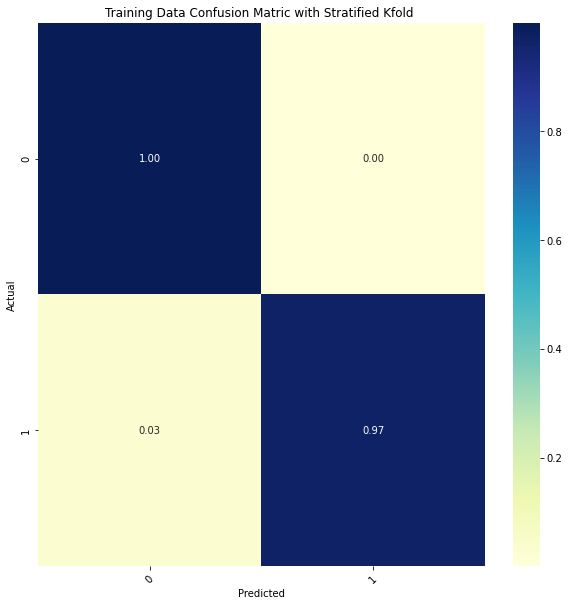


F1 Score: 0.9961251862891207
Precision: 0.9961251862891207
Recall: 0.9961251862891207
Accuracy: 0.9961251862891207


In [ ]:
conf_matrix = confusion_matrix(y_train, predictions)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Training Data Confusion Matric with Stratified Kfold ')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y_train, predictions, average='macro')))
print('Precision: {}'.format(
    precision_score(y_train, predictions, average='weighted'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y_train, predictions, average='macro')))
print('Accuracy: {}'.format(
    accuracy_score(y_train, predictions, )))

**No Cross Validation below:**

In [19]:
model = neural_network
#Fit the model
model.fit(X_train_under, y_train_under, validation_data=(X_test, y_test), epochs=config.epochs, batch_size=config.batch_size, callbacks=[WandbCallback()])
test_pred = model.predict(X_test)
test_proba = model.predict_proba(X_test)
test_accuracy = roc_auc_score(y_test, test_proba[:,1])

print("Test AUC: {}".format(test_accuracy))

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/200
13/13 [==============================] - 4s 64ms/step - loss: 2.7787 - accuracy: 0.5000 - f1_score: 0.0000e+00 - auc_2: 0.4618 - val_loss: 0.4285 - val_accuracy: 0.8769 - val_f1_score: 0.0328 - val_auc_2: 0.4344
Epoch 2/200
13/13 [==============================] - 0s 14ms/step - loss: 0.9394 - accuracy: 0.4552 - f1_score: 0.4326 - auc_2: 0.4575 - val_loss: 1.3701 - val_accuracy: 0.1989 - val_f1_score: 0.1748 - val_auc_2: 0.4418
Epoch 3/200
13/13 [==============================] - 0s 15ms/step - loss: 0.9394 - accuracy: 0.4192 - f1_score: 0.5426 - auc_2: 0.4574 - val_loss: 0.9640 - val_accuracy: 0.3630 - val_f1_score: 0.1642 - val_auc_2: 0.4451
Epoch 4/200
13/13 [==============================] - 0s 25ms/step - loss: 0.8455 - accuracy: 0.4366 - f1_score: 0.4626 - auc_2: 0.4457 - val_loss: 0.6937 - val_accuracy: 0.4784 - val_f1_score: 0.1339 - val_auc_2: 0.4462
Epoch 5/200
13/13 [==============================] - 0s 18ms/step - loss: 0.8389 - accuracy: 0.4353 - f1_score: 0.43

-----------
Train predictions & confusion matrix

In [20]:
prediction_train = (model.predict(X_train) > 0.5).astype("int32")

53/53 [==============================] - 0s 1ms/step


[[2645  308]
 [  24  378]] 



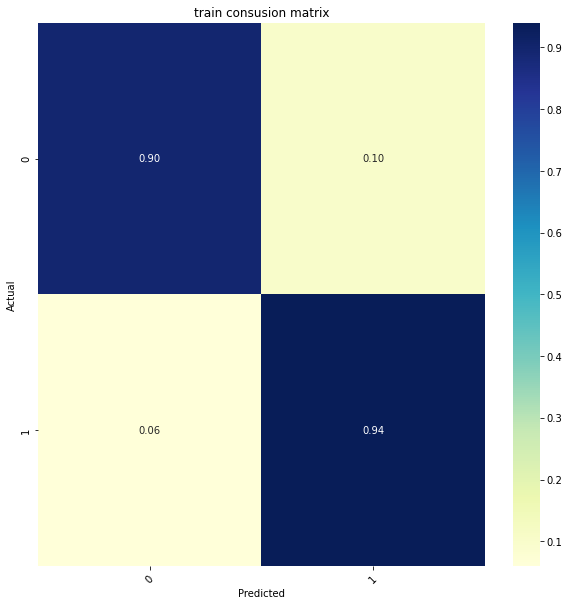


F1 Score: 0.817899611819114
Precision: 0.9382880592031017
Recall: 0.9179988981607372
Accuracy: 0.9010432190760059


In [21]:
##train confusion matrix
conf_matrix = confusion_matrix(y_train, prediction_train)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('train consusion matrix')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y_train, prediction_train, average='macro')))
print('Precision: {}'.format(
    precision_score(y_train, prediction_train, average='weighted'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y_train, prediction_train, average='macro')))
print('Accuracy: {}'.format(
    accuracy_score(y_train, prediction_train, )))

-----------
Undersanpled train predictions & confusion matrix

In [22]:
#undersampling predictions
prediction_train_under = (model.predict(X_train_under) > 0.5).astype("int32")

24/24 [==============================] - 0s 1ms/step


[[342  36]
 [ 29 349]] 



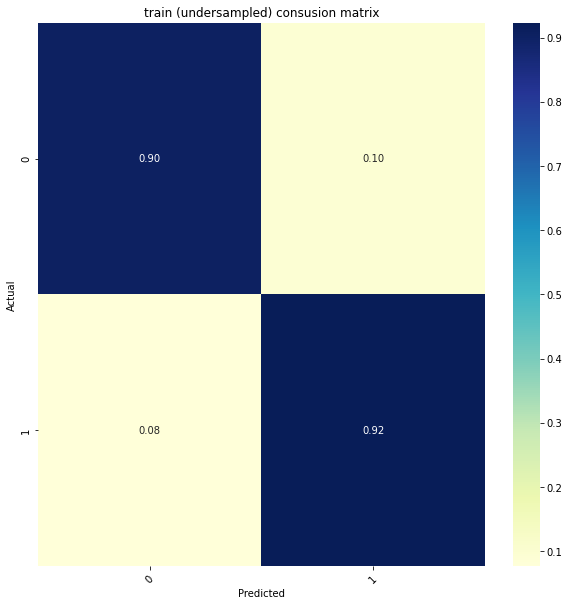


F1 Score: 0.9140137920897589
Precision: 0.9141631952952708
Recall: 0.914021164021164
Accuracy: 0.9140211640211641


In [23]:
##train under confusion matrix
conf_matrix = confusion_matrix(y_train_under, prediction_train_under)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('train (undersampled) consusion matrix')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y_train_under, prediction_train_under, average='macro')))
print('Precision: {}'.format(
    precision_score(y_train_under, prediction_train_under, average='weighted'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y_train_under, prediction_train_under, average='macro')))
print('Accuracy: {}'.format(
    accuracy_score(y_train_under, prediction_train_under, )))

-----------
Test predictions & confusion matrix

In [24]:
prediction_test = (model.predict(X_test) > 0.5).astype("int32")

45/45 [==============================] - 0s 1ms/step


23/23 [==============================] - 0s 1ms/step


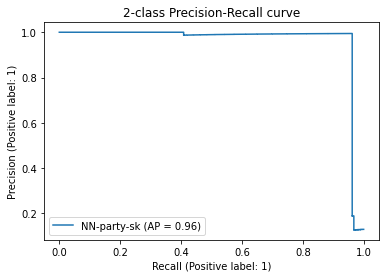

In [43]:
#PR-curve
neural_network.fit(X_train, y_train)

from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    neural_network, X_test, y_test, name="NN-party-sk"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

[[1172   80]
 [  23  163]] 



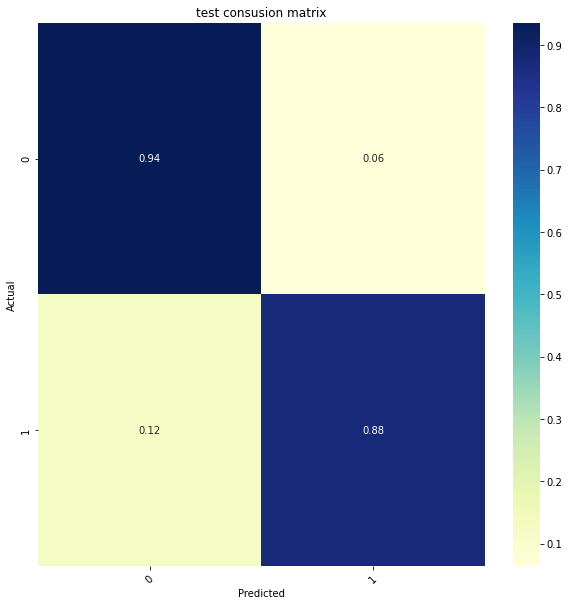


F1 Score: 0.8589072009586927
Precision: 0.9406594999784829
Recall: 0.9062231612216153
Accuracy: 0.9283727399165508


In [26]:
#test confusion matrix
conf_matrix = confusion_matrix(y_test, prediction_test)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('test consusion matrix')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y_test, prediction_test, average='macro')))
print('Precision: {}'.format(
    precision_score(y_test, prediction_test, average='weighted'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y_test, prediction_test, average='macro')))
print('Accuracy: {}'.format(
    accuracy_score(y_test, prediction_test, )))

-----------
Undersanpled test predictions & confusion matrix

In [27]:
#undersampling (test_under) predictions
prediction_test_under = (model.predict(X_test_under) > 0.5).astype("int32")

12/12 [==============================] - 0s 2ms/step


[[173  13]
 [ 23 163]] 



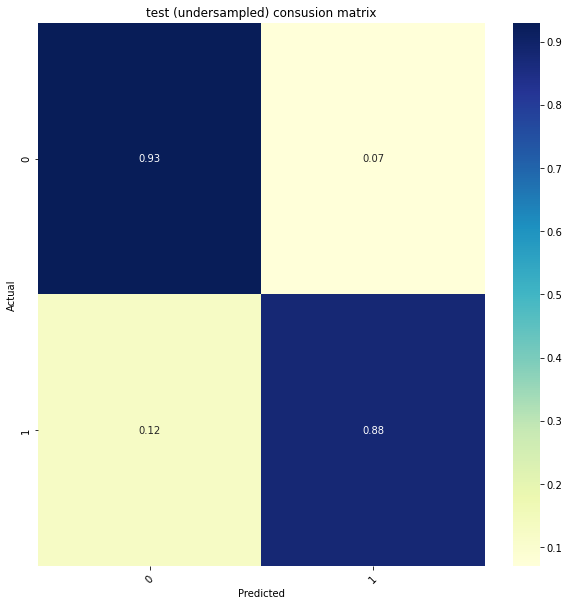


F1 Score: 0.9031558242457551
Precision: 0.9043947124304267
Recall: 0.9032258064516129
Accuracy: 0.9032258064516129


In [28]:
#test confusion matrix
conf_matrix = confusion_matrix(y_test_under, prediction_test_under)
print(conf_matrix, '\n')

conf_matrix_n = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_n, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('test (undersampled) consusion matrix')
plt.xticks(rotation=45)
plt.show(block=False)

print('\nF1 Score: {}'.format(
    f1_score(y_test_under, prediction_test_under, average='macro')))
print('Precision: {}'.format(
    precision_score(y_test_under, prediction_test_under, average='weighted'))) #weighted to show AUC-Precision/Recall curve
print('Recall: {}'.format(
    recall_score(y_test_under, prediction_test_under, average='macro')))
print('Accuracy: {}'.format(
    accuracy_score(y_test_under, prediction_test_under, )))